# Importing relevant libraries

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
import os
from datetime import datetime

# Download and Import Dataset

### Run the first 2 cells if running on Colab

In [3]:
# !pip install kaggle

# # Assuming you have your kaggle.json in your Google Drive
# from google.colab import drive
# drive.mount('/content/drive')
# !mkdir ~/.kaggle
# !cp /content/drive/MyDrive/kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json

# # Download the dataset
# !kaggle datasets download -d shayanfazeli/heartbeat
# !unzip heartbeat.zip

In [4]:
# Download the dataset
# !kaggle datasets download -d sadmansakib7/ecg-arrhythmia-classification-dataset
# !unzip ecg-arrhythmia-classification-dataset.zip

In [5]:
import pandas as pd

mitbih_train = pd.read_csv('mitbih_train.csv', header=None) # 80%
mitbih_test = pd.read_csv('mitbih_test.csv', header=None)   # 20%

In [6]:
print(mitbih_train.shape)
print(mitbih_test.shape)

(87554, 188)
(21892, 188)


# Preprocessing Data

In [8]:
class ECGDataProcessor:
    """
    Class to handle ECG data preprocessing for multiple datasets
    """
    def __init__(self, mitbih_train_path, mitbih_test_path, incart_path):
        self.mitbih_train_path = mitbih_train_path
        self.mitbih_test_path = mitbih_test_path
        self.incart_path = incart_path
        self.scaler = StandardScaler()

    def load_and_preprocess_mitbih(self):
        """
        Load and preprocess MIT-BIH test dataset
        """
        print("Loading MIT-BIH dataset...")
        df_train = pd.read_csv(self.mitbih_train_path, header=None)
        df_test = pd.read_csv(self.mitbih_test_path, header=None)

        # Separate features and labels
        X_train = df_train.iloc[:, :-1].values
        y_train = df_train.iloc[:, -1].values
        X_test = df_test.iloc[:, :-1].values
        y_test = df_test.iloc[:, -1].values

        print(f"MIT-BIH dataset shape: {X_train.shape}")
        self._print_class_distribution("MIT-BIH", y_train)

        return X_train, y_train,X_test, y_test

    def _print_class_distribution(self, dataset_name, y):
        """
        Print class distribution for a dataset
        """
        print(f"\nClass distribution in {dataset_name} dataset:")
        classes = np.unique(y)
        for class_id in classes:
            count = np.sum(y == class_id)
            percentage = (count / len(y)) * 100
            print(f"Class {class_id}: {count} samples ({percentage:.2f}%)")

    def preprocess_mitbih_data(self):
        """
        Load and preprocess MIT-BIH test dataset
        """
        print("Loading MIT-BIH dataset...")
        df_train = pd.read_csv(self.mitbih_train_path, header=None)
        df_test = pd.read_csv(self.mitbih_test_path, header=None)

        # Separate features and labels
        X_train = df_train.iloc[:, :-1].values
        y_train = df_train.iloc[:, -1].values
        X_test = df_test.iloc[:, :-1].values
        y_test = df_test.iloc[:, -1].values

        print(f"MIT-BIH dataset shape: {X_train.shape}")
        self._print_class_distribution("MIT-BIH", y_train)

        #     # Split temp into validation and test sets
        #val_size_adjusted = val_size / (1 - test_size)
        X_train, X_val, y_train, y_val = train_test_split(
            X_train, y_train,
            test_size=0.1,
            random_state=42
        )

        # Reshape for RNN input (batch_size, sequence_length, input_size)
        X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
        X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)
        X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

        return X_train, X_val, X_test, y_train, y_val, y_test



In [9]:
def analyze_dataset(file_path, name):
    """
    Analyze a dataset file and print information about its structure
    """
    print(f"\nAnalyzing {name} dataset...")
    df = pd.read_csv(file_path, header=None, nrows=5)
    print("\nFirst 5 rows:")
    print(df.head())
    print("\nColumn types:")
    print(df.dtypes)
    print("\nMissing values:")
    print(df.isnull().sum())

In [10]:
# Set file paths
incart_path = 'INCART 2-lead Arrhythmia Database.csv'
mitbih_train_path = 'mitbih_train.csv'
mitbih_test_path = 'mitbih_test.csv'

# Create processor instance
processor = ECGDataProcessor(mitbih_train_path, mitbih_test_path, incart_path)

# Load and preprocess data
X_train, X_val, X_test, y_train, y_val, y_test = processor.preprocess_mitbih_data()

# Print final dataset sizes
print("\nFinal dataset sizes:")
print(f"Training set: {X_train.shape}")
print(f"Validation set: {X_val.shape}")
print(f"Test set: {X_test.shape}")

Loading MIT-BIH dataset...
MIT-BIH dataset shape: (87554, 187)

Class distribution in MIT-BIH dataset:
Class 0.0: 72471 samples (82.77%)
Class 1.0: 2223 samples (2.54%)
Class 2.0: 5788 samples (6.61%)
Class 3.0: 641 samples (0.73%)
Class 4.0: 6431 samples (7.35%)

Final dataset sizes:
Training set: (78798, 187, 1)
Validation set: (8756, 187, 1)
Test set: (21892, 187, 1)


In [11]:
class ECGDataset(Dataset):
    """
    Custom Dataset class for ECG data
    """
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X)
        self.y = torch.LongTensor(y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

def create_data_loaders(X_train, X_val, X_test, y_train, y_val, y_test, batch_size=32):
    """
    Create train, validation, and test data loaders
    """
    # Create datasets
    train_dataset = ECGDataset(X_train, y_train)
    val_dataset = ECGDataset(X_val, y_val)
    test_dataset = ECGDataset(X_test, y_test)

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    return train_loader, val_loader, test_loader

def plot_sample_signals(X, y, dataset_name, num_samples=3):
    """
    Plot sample ECG signals from each class
    """
    classes = np.unique(y)
    fig, axes = plt.subplots(len(classes), num_samples, figsize=(15, 3*len(classes)))

    for i, class_id in enumerate(classes):
        # Get indices for current class
        class_indices = np.where(y == class_id)[0]
        # Randomly select samples
        sample_indices = np.random.choice(class_indices,
                                        min(num_samples, len(class_indices)),
                                        replace=False)

        for j, idx in enumerate(sample_indices):
            signal = X[idx].reshape(-1) if len(X[idx].shape) > 1 else X[idx]
            axes[i, j].plot(signal)
            axes[i, j].set_title(f'Class {class_id}')
            axes[i, j].set_xticks([])
            if j == 0:
                axes[i, j].set_ylabel('Amplitude')

    plt.suptitle(f'Sample ECG Signals from {dataset_name} Dataset')
    plt.tight_layout()
    plt.show()


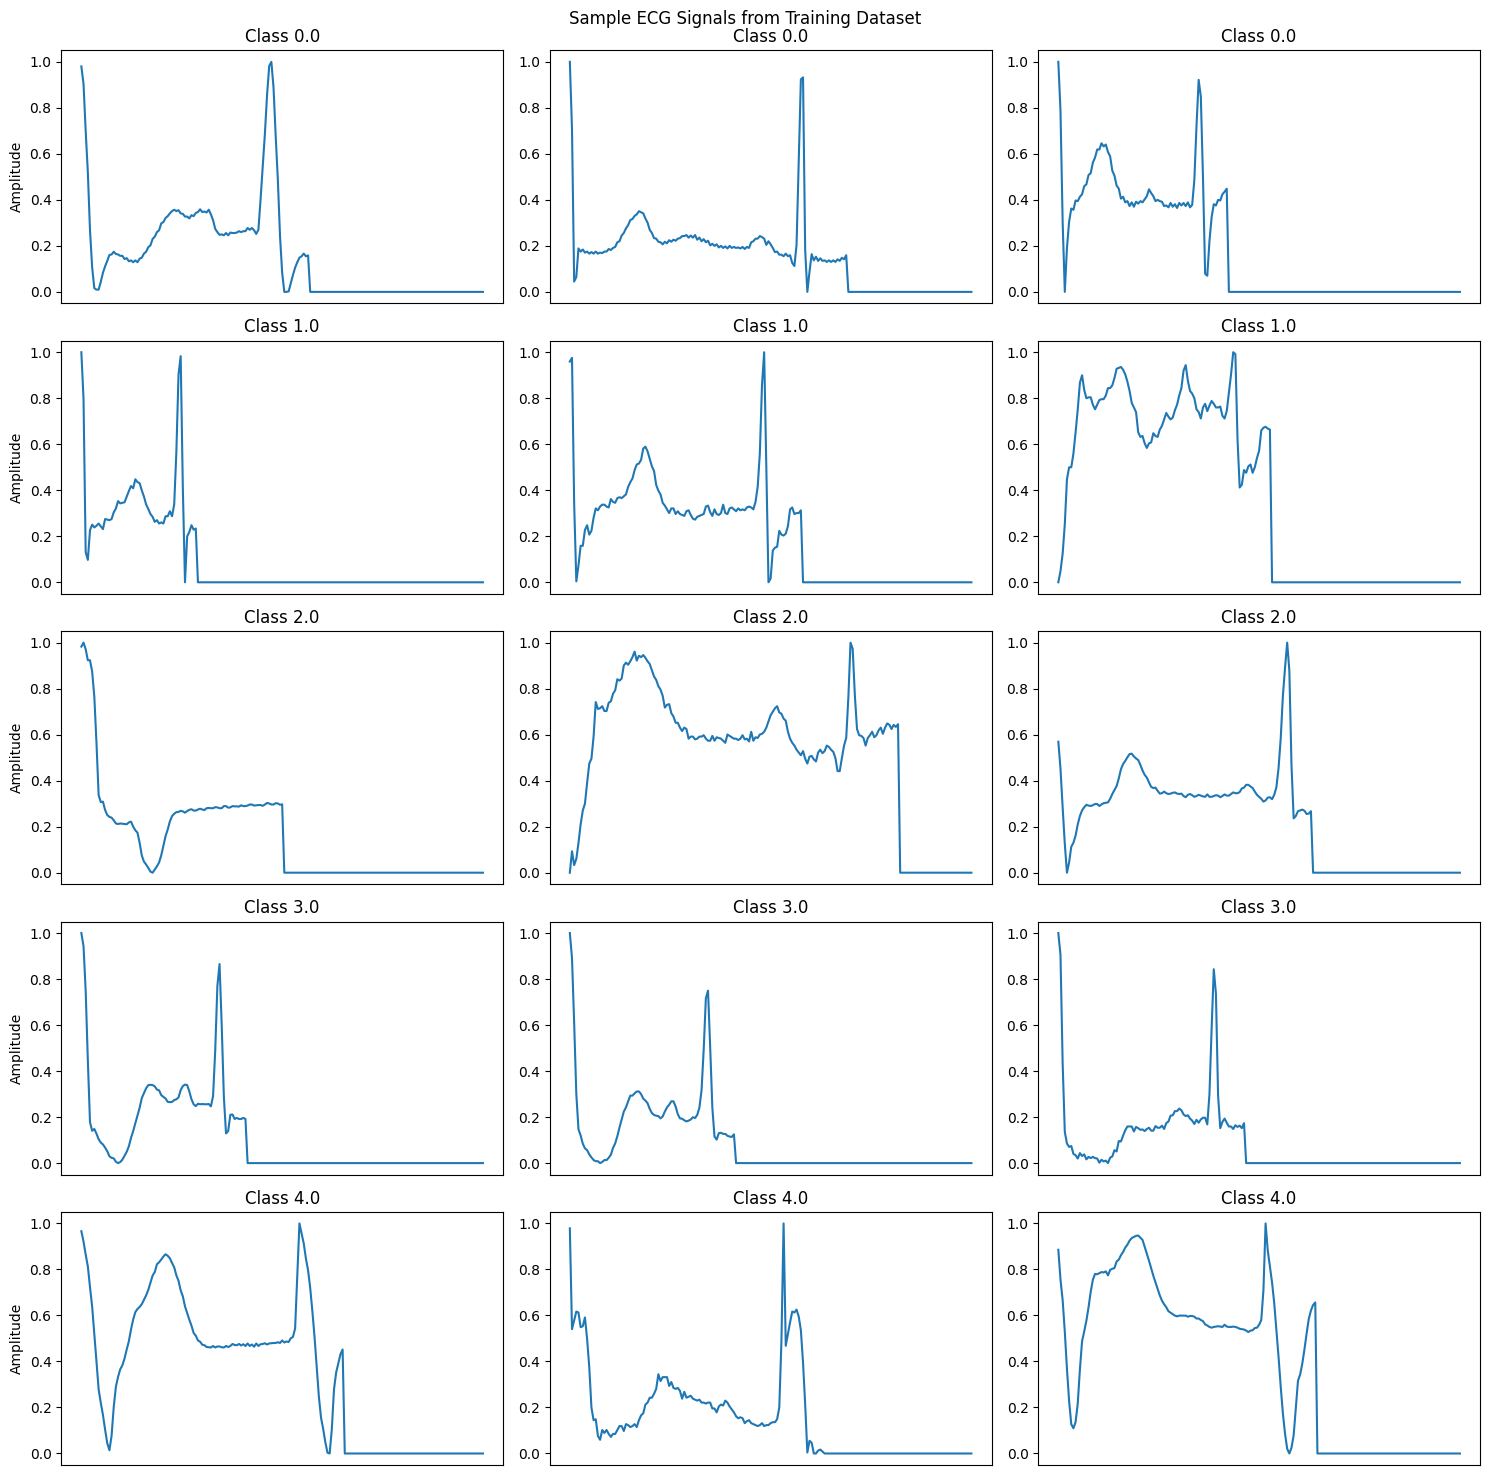


Final dataset sizes:
Training set: (78798, 187, 1)
Validation set: (8756, 187, 1)
Test set: (21892, 187, 1)


In [12]:
 # Create data loaders
train_loader, val_loader, test_loader = create_data_loaders(
    X_train, X_val, X_test, y_train, y_val, y_test
)

# Plot sample signals from each dataset
plot_sample_signals(X_train, y_train, "Training")

# Print final dataset sizes
print("\nFinal dataset sizes:")
print(f"Training set: {X_train.shape}")
print(f"Validation set: {X_val.shape}")
print(f"Test set: {X_test.shape}")

# ECG Dataset on RNN Model

In [14]:
class ECG_RNN(nn.Module):
    def __init__(self, input_size=1, hidden_size=128, num_layers=2, num_classes=5, dropout=0.3):
        """
        RNN model with LSTM layers for ECG classification

        Args:
            input_size (int): Number of input features (1 for single-lead ECG)
            hidden_size (int): Number of features in hidden state
            num_layers (int): Number of stacked LSTM layers
            num_classes (int): Number of output classes
            dropout (float): Dropout rate
        """
        super(ECG_RNN, self).__init__()

        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # LSTM layers
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0,
            bidirectional=True
        )

        # Attention mechanism
        self.attention = nn.Sequential(
            nn.Linear(hidden_size * 2, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, 1)
        )

        # Output layers
        self.fc1 = nn.Linear(hidden_size * 2, hidden_size)
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(hidden_size, num_classes)

        # Layer normalization
        self.layer_norm = nn.LayerNorm(hidden_size * 2)

    def forward(self, x):
        # Input shape: (batch_size, sequence_length, input_size)

        # LSTM forward pass
        lstm_out, _ = self.lstm(x)
        # lstm_out shape: (batch_size, sequence_length, hidden_size * 2)

        # Apply layer normalization
        lstm_out = self.layer_norm(lstm_out)

        # Attention weights
        attention_weights = self.attention(lstm_out)
        attention_weights = F.softmax(attention_weights, dim=1)

        # Apply attention
        context = torch.sum(attention_weights * lstm_out, dim=1)

        # Final classification
        out = self.fc1(context)
        out = F.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)

        return out, attention_weights

In [15]:
# Improved training configuration
def get_training_config():
    """
    Returns improved training configuration with:
    - Cyclical learning rates
    - Gradual warmup
    - Label smoothing
    - Mixed precision training
    """
    config = {
        'CNN': {
            'model_params': {
                'input_channels': 1,
                'sequence_length': 187,
                'num_classes': 5,
            },
            'training_params': {
                'initial_lr': 1e-4,  # Lower initial learning rate
                'max_lr': 3e-3,      # Maximum learning rate for cyclical schedule
                'batch_size': 64,    # Increased batch size
                'num_epochs': 100,   # More epochs for gradual learning
                'warmup_epochs': 5,  # Gradual warmup
                'label_smoothing': 0.1,
                'weight_decay': 1e-4,  # Increased weight decay
                'gradient_clip_val': 0.5,
            }
        }
    }
    return config

In [16]:
class CustomLRScheduler:
    def __init__(self, optimizer, initial_lr, max_lr, warmup_epochs, total_epochs):
        self.optimizer = optimizer
        self.initial_lr = initial_lr
        self.max_lr = max_lr
        self.warmup_epochs = warmup_epochs
        self.total_epochs = total_epochs
        self.current_epoch = 0

    def step(self):
        self.current_epoch += 1
        if self.current_epoch <= self.warmup_epochs:
            # Linear warmup
            lr = self.initial_lr + (self.max_lr - self.initial_lr) * (self.current_epoch / self.warmup_epochs)
        else:
            # Cosine annealing
            progress = (self.current_epoch - self.warmup_epochs) / (self.total_epochs - self.warmup_epochs)
            lr = self.initial_lr + 0.5 * (self.max_lr - self.initial_lr) * (1 + np.cos(progress * np.pi))

        for param_group in self.optimizer.param_groups:
            param_group['lr'] = lr

        return lr

In [17]:
class SmoothCrossEntropyLoss(nn.Module):
    def __init__(self, smoothing=0.1):
        super(SmoothCrossEntropyLoss, self).__init__()
        self.smoothing = smoothing

    def forward(self, pred, target):
        n_classes = pred.size(1)
        target_one_hot = torch.zeros_like(pred).scatter(1, target.unsqueeze(1), 1)
        smoothed_target = target_one_hot * (1 - self.smoothing) + self.smoothing / n_classes
        return torch.mean(torch.sum(-smoothed_target * torch.log_softmax(pred, dim=1), dim=1))

In [18]:
def get_training_config():
    """
    Returns improved training configuration for both RNN and CNN models
    """
    config = {
        'RNN': {
            'model_params': {
                'input_size': 1,
                'hidden_size': 128,
                'num_layers': 2,
                'num_classes': 5,
                'dropout': 0.3,
            },
            'training_params': {
                'initial_lr': 1e-4,
                'max_lr': 3e-3,
                'batch_size': 64,
                'num_epochs': 100,
                'warmup_epochs': 5,
                'label_smoothing': 0.1,
                'weight_decay': 1e-4,
                'gradient_clip_val': 0.5,
            }
        },
        'CNN': {
            'model_params': {
                'input_channels': 1,
                'sequence_length': 187,
                'num_classes': 5,
            },
            'training_params': {
                'initial_lr': 1e-4,
                'max_lr': 3e-3,
                'batch_size': 64,
                'num_epochs': 100,
                'warmup_epochs': 5,
                'label_smoothing': 0.1,
                'weight_decay': 1e-4,
                'gradient_clip_val': 0.5,
            }
        }
    }
    return config

In [19]:
# Initialize RNN model
rnn_model = ECG_RNN(
    input_size=1,
    hidden_size=128,
    num_layers=2,
    num_classes=5,
    dropout=0.3
)

# Get recommended training configurations
config = get_training_config()

In [20]:
class ECGDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X)
        self.y = torch.LongTensor(y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [21]:
class ModelTrainer:
    def __init__(self, model, model_name, device, criterion, config):
        self.model = model.to(device)
        self.model_name = model_name
        self.device = device
        self.criterion = criterion
        self.config = config

        # Initialize optimizer with weight decay
        self.optimizer = optim.AdamW(
            self.model.parameters(),
            lr=config['initial_lr'],
            weight_decay=config['weight_decay']
        )

        # Initialize learning rate scheduler
        self.scheduler = CustomLRScheduler(
            self.optimizer,
            config['initial_lr'],
            config['max_lr'],
            config['warmup_epochs'],
            config['num_epochs']
        )

        # Initialize tracking metrics
        self.train_losses = []
        self.val_losses = []
        self.train_accuracies = []
        self.val_accuracies = []
        self.best_val_loss = float('inf')

        # Create directory for saving models
        timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
        self.save_dir = os.path.join('models', f"{model_name}_{timestamp}")
        os.makedirs(self.save_dir, exist_ok=True)

    def train_epoch(self, train_loader):
        """Train for one epoch"""
        self.model.train()
        total_loss = 0
        correct = 0
        total = 0

        for batch_X, batch_y in tqdm(train_loader, desc='Training'):
            batch_X, batch_y = batch_X.to(self.device), batch_y.to(self.device)

            self.optimizer.zero_grad()

            # Handle different model outputs
            if self.model_name == 'RNN':
                outputs, _ = self.model(batch_X)
            else:
                outputs = self.model(batch_X)

            loss = self.criterion(outputs, batch_y)
            loss.backward()

            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)

            self.optimizer.step()

            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += batch_y.size(0)
            correct += (predicted == batch_y).sum().item()

        epoch_loss = total_loss / len(train_loader)
        epoch_acc = 100 * correct / total
        return epoch_loss, epoch_acc

    def validate(self, val_loader):
        """Validate the model"""
        self.model.eval()
        total_loss = 0
        correct = 0
        total = 0

        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                batch_X, batch_y = batch_X.to(self.device), batch_y.to(self.device)

                if self.model_name == 'RNN':
                    outputs, _ = self.model(batch_X)
                else:
                    outputs = self.model(batch_X)

                loss = self.criterion(outputs, batch_y)
                total_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                total += batch_y.size(0)
                correct += (predicted == batch_y).sum().item()

        epoch_loss = total_loss / len(val_loader)
        epoch_acc = 100 * correct / total
        return epoch_loss, epoch_acc

    def train(self, train_loader, val_loader, num_epochs):
        """Complete training process"""
        print(f"\nStarting training for {self.model_name}...")

        for epoch in range(num_epochs):
            # Training phase
            train_loss, train_acc = self.train_epoch(train_loader)

            # Validation phase
            val_loss, val_acc = self.validate(val_loader)

            # Update learning rate
            self.scheduler.step()  # Removed val_loss parameter
            current_lr = self.optimizer.param_groups[0]['lr']

            # Save metrics
            self.train_losses.append(train_loss)
            self.val_losses.append(val_loss)
            self.train_accuracies.append(train_acc)
            self.val_accuracies.append(val_acc)

            # Print epoch results
            print(f'\nEpoch [{epoch+1}/{num_epochs}]')
            print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
            print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
            print(f'Learning Rate: {current_lr:.6f}')

            # Save best model
            if val_loss < self.best_val_loss:
                self.best_val_loss = val_loss
                self.save_model('best_model.pth')
                print(f'New best model saved! (Val Loss: {val_loss:.4f})')

        # Save final model
        self.save_model('rnn_final_model.pth')

    def save_model(self, filename):
        """Save model checkpoint"""
        path = os.path.join(self.save_dir, filename)
        torch.save({
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'train_losses': self.train_losses,
            'val_losses': self.val_losses,
            'train_accuracies': self.train_accuracies,
            'val_accuracies': self.val_accuracies,
            'config': self.config
        }, path)

    def plot_training_history(self):
        """Plot training metrics"""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

        # Plot losses
        ax1.plot(self.train_losses, label='Training Loss')
        ax1.plot(self.val_losses, label='Validation Loss')
        ax1.set_title(f'{self.model_name} - Training History (Loss)')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.legend()

        # Plot accuracies
        ax2.plot(self.train_accuracies, label='Training Accuracy')
        ax2.plot(self.val_accuracies, label='Validation Accuracy')
        ax2.set_title(f'{self.model_name} - Training History (Accuracy)')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy (%)')
        ax2.legend()

        plt.tight_layout()
        plt.savefig(os.path.join(self.save_dir, 'training_history.png'))
        plt.show()

    def evaluate(self, test_loader):
        """Evaluate model on test set"""
        self.model.eval()
        predictions = []
        true_labels = []

        with torch.no_grad():
            for batch_X, batch_y in tqdm(test_loader, desc='Testing'):
                batch_X, batch_y = batch_X.to(self.device), batch_y.to(self.device)

                if self.model_name == 'RNN':
                    outputs, _ = self.model(batch_X)
                else:
                    outputs = self.model(batch_X)

                _, predicted = torch.max(outputs.data, 1)
                predictions.extend(predicted.cpu().numpy())
                true_labels.extend(batch_y.cpu().numpy())

        # Print classification report
        print(f"\nClassification Report ({self.model_name}):")
        print(classification_report(true_labels, predictions))

        # Plot confusion matrix
        cm = confusion_matrix(true_labels, predictions)
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(f'Confusion Matrix ({self.model_name})')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.savefig(os.path.join(self.save_dir, 'confusion_matrix.png'))
        plt.show()

In [22]:
def train_rnn_model(X_train, X_val, X_test, y_train, y_val, y_test):
    """Train both RNN and CNN models"""
    # Set device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Get configurations
    config = get_training_config()

    # Create data loaders
    train_dataset = ECGDataset(X_train, y_train)
    val_dataset = ECGDataset(X_val, y_val)
    test_dataset = ECGDataset(X_test, y_test)

    batch_size = config['RNN']['training_params']['batch_size']
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    # Initialize models
    rnn_model = ECG_RNN(**config['RNN']['model_params'])

    # Initialize criterion with label smoothing
    rnn_criterion = SmoothCrossEntropyLoss(smoothing=config['RNN']['training_params']['label_smoothing'])

    # Train RNN
    rnn_trainer = ModelTrainer(
        model=rnn_model,
        model_name='RNN',
        device=device,
        criterion=rnn_criterion,
        config=config['RNN']['training_params']
    )
    rnn_trainer.train(
        train_loader,
        val_loader,
        config['RNN']['training_params']['num_epochs']
    )
    rnn_trainer.plot_training_history()
    rnn_trainer.evaluate(test_loader)

    return rnn_trainer


Updated configuration:
Number of classes: 5
Sequence length: 187
Using device: cuda

Starting training for RNN...


Training: 100%|██████████| 1232/1232 [00:08<00:00, 146.04it/s]



Epoch [1/100]
Train Loss: 0.7476, Train Acc: 85.57%
Val Loss: 0.6633, Val Acc: 88.61%
Learning Rate: 0.000680
New best model saved! (Val Loss: 0.6633)


Training: 100%|██████████| 1232/1232 [00:08<00:00, 147.12it/s]



Epoch [2/100]
Train Loss: 0.5964, Train Acc: 92.22%
Val Loss: 0.5253, Val Acc: 94.66%
Learning Rate: 0.001260
New best model saved! (Val Loss: 0.5253)


Training: 100%|██████████| 1232/1232 [00:08<00:00, 148.35it/s]



Epoch [3/100]
Train Loss: 0.5329, Train Acc: 94.57%
Val Loss: 0.4967, Val Acc: 95.66%
Learning Rate: 0.001840
New best model saved! (Val Loss: 0.4967)


Training: 100%|██████████| 1232/1232 [00:08<00:00, 148.31it/s]



Epoch [4/100]
Train Loss: 0.5135, Train Acc: 95.42%
Val Loss: 0.4851, Val Acc: 96.13%
Learning Rate: 0.002420
New best model saved! (Val Loss: 0.4851)


Training: 100%|██████████| 1232/1232 [00:08<00:00, 148.06it/s]



Epoch [5/100]
Train Loss: 0.4994, Train Acc: 95.91%
Val Loss: 0.4766, Val Acc: 96.43%
Learning Rate: 0.003000
New best model saved! (Val Loss: 0.4766)


Training: 100%|██████████| 1232/1232 [00:08<00:00, 146.48it/s]



Epoch [6/100]
Train Loss: 0.4871, Train Acc: 96.43%
Val Loss: 0.4824, Val Acc: 96.44%
Learning Rate: 0.002999


Training: 100%|██████████| 1232/1232 [00:08<00:00, 145.13it/s]



Epoch [7/100]
Train Loss: 0.4791, Train Acc: 96.58%
Val Loss: 0.4688, Val Acc: 96.75%
Learning Rate: 0.002997
New best model saved! (Val Loss: 0.4688)


Training: 100%|██████████| 1232/1232 [00:08<00:00, 148.28it/s]



Epoch [8/100]
Train Loss: 0.4667, Train Acc: 97.08%
Val Loss: 0.4485, Val Acc: 97.69%
Learning Rate: 0.002993
New best model saved! (Val Loss: 0.4485)


Training: 100%|██████████| 1232/1232 [00:08<00:00, 147.91it/s]



Epoch [9/100]
Train Loss: 0.4580, Train Acc: 97.46%
Val Loss: 0.4486, Val Acc: 97.44%
Learning Rate: 0.002987


Training: 100%|██████████| 1232/1232 [00:08<00:00, 147.91it/s]



Epoch [10/100]
Train Loss: 0.4532, Train Acc: 97.58%
Val Loss: 0.4418, Val Acc: 97.99%
Learning Rate: 0.002980
New best model saved! (Val Loss: 0.4418)


Training: 100%|██████████| 1232/1232 [00:08<00:00, 148.00it/s]



Epoch [11/100]
Train Loss: 0.4455, Train Acc: 97.93%
Val Loss: 0.4411, Val Acc: 97.86%
Learning Rate: 0.002972
New best model saved! (Val Loss: 0.4411)


Training: 100%|██████████| 1232/1232 [00:08<00:00, 148.40it/s]



Epoch [12/100]
Train Loss: 0.4450, Train Acc: 97.95%
Val Loss: 0.4444, Val Acc: 97.77%
Learning Rate: 0.002961


Training: 100%|██████████| 1232/1232 [00:08<00:00, 147.80it/s]



Epoch [13/100]
Train Loss: 0.4414, Train Acc: 98.08%
Val Loss: 0.4474, Val Acc: 97.74%
Learning Rate: 0.002950


Training: 100%|██████████| 1232/1232 [00:08<00:00, 147.86it/s]



Epoch [14/100]
Train Loss: 0.4396, Train Acc: 98.11%
Val Loss: 0.4569, Val Acc: 97.27%
Learning Rate: 0.002936


Training: 100%|██████████| 1232/1232 [00:08<00:00, 147.76it/s]



Epoch [15/100]
Train Loss: 0.4386, Train Acc: 98.17%
Val Loss: 0.4331, Val Acc: 98.17%
Learning Rate: 0.002921
New best model saved! (Val Loss: 0.4331)


Training: 100%|██████████| 1232/1232 [00:08<00:00, 147.70it/s]



Epoch [16/100]
Train Loss: 0.4684, Train Acc: 96.95%
Val Loss: 0.4339, Val Acc: 98.24%
Learning Rate: 0.002905


Training: 100%|██████████| 1232/1232 [00:08<00:00, 148.17it/s]



Epoch [17/100]
Train Loss: 0.4332, Train Acc: 98.39%
Val Loss: 0.4312, Val Acc: 98.32%
Learning Rate: 0.002887
New best model saved! (Val Loss: 0.4312)


Training: 100%|██████████| 1232/1232 [00:08<00:00, 147.55it/s]



Epoch [18/100]
Train Loss: 0.4317, Train Acc: 98.41%
Val Loss: 0.4373, Val Acc: 98.12%
Learning Rate: 0.002868


Training: 100%|██████████| 1232/1232 [00:08<00:00, 148.00it/s]



Epoch [19/100]
Train Loss: 0.4301, Train Acc: 98.50%
Val Loss: 0.4306, Val Acc: 98.47%
Learning Rate: 0.002847
New best model saved! (Val Loss: 0.4306)


Training: 100%|██████████| 1232/1232 [00:08<00:00, 147.93it/s]



Epoch [20/100]
Train Loss: 0.4279, Train Acc: 98.60%
Val Loss: 0.4278, Val Acc: 98.49%
Learning Rate: 0.002825
New best model saved! (Val Loss: 0.4278)


Training: 100%|██████████| 1232/1232 [00:08<00:00, 148.00it/s]



Epoch [21/100]
Train Loss: 0.4273, Train Acc: 98.62%
Val Loss: 0.4287, Val Acc: 98.34%
Learning Rate: 0.002802


Training: 100%|██████████| 1232/1232 [00:08<00:00, 147.76it/s]



Epoch [22/100]
Train Loss: 0.4270, Train Acc: 98.64%
Val Loss: 0.4254, Val Acc: 98.54%
Learning Rate: 0.002777
New best model saved! (Val Loss: 0.4254)


Training: 100%|██████████| 1232/1232 [00:08<00:00, 148.17it/s]



Epoch [23/100]
Train Loss: 0.4271, Train Acc: 98.63%
Val Loss: 0.4243, Val Acc: 98.63%
Learning Rate: 0.002751
New best model saved! (Val Loss: 0.4243)


Training: 100%|██████████| 1232/1232 [00:08<00:00, 147.86it/s]



Epoch [24/100]
Train Loss: 0.4224, Train Acc: 98.81%
Val Loss: 0.4236, Val Acc: 98.65%
Learning Rate: 0.002723
New best model saved! (Val Loss: 0.4236)


Training: 100%|██████████| 1232/1232 [00:08<00:00, 147.57it/s]



Epoch [25/100]
Train Loss: 0.4222, Train Acc: 98.82%
Val Loss: 0.4290, Val Acc: 98.50%
Learning Rate: 0.002694


Training: 100%|██████████| 1232/1232 [00:08<00:00, 147.96it/s]



Epoch [26/100]
Train Loss: 0.4215, Train Acc: 98.85%
Val Loss: 0.4263, Val Acc: 98.52%
Learning Rate: 0.002664


Training: 100%|██████████| 1232/1232 [00:08<00:00, 147.89it/s]



Epoch [27/100]
Train Loss: 0.4200, Train Acc: 98.91%
Val Loss: 0.4235, Val Acc: 98.64%
Learning Rate: 0.002633
New best model saved! (Val Loss: 0.4235)


Training: 100%|██████████| 1232/1232 [00:08<00:00, 148.00it/s]



Epoch [28/100]
Train Loss: 0.4202, Train Acc: 98.88%
Val Loss: 0.4273, Val Acc: 98.49%
Learning Rate: 0.002600


Training: 100%|██████████| 1232/1232 [00:08<00:00, 147.51it/s]



Epoch [29/100]
Train Loss: 0.4177, Train Acc: 99.01%
Val Loss: 0.4212, Val Acc: 98.71%
Learning Rate: 0.002567
New best model saved! (Val Loss: 0.4212)


Training: 100%|██████████| 1232/1232 [00:08<00:00, 148.23it/s]



Epoch [30/100]
Train Loss: 0.4187, Train Acc: 98.97%
Val Loss: 0.4222, Val Acc: 98.65%
Learning Rate: 0.002532


Training: 100%|██████████| 1232/1232 [00:08<00:00, 147.48it/s]



Epoch [31/100]
Train Loss: 0.4179, Train Acc: 99.00%
Val Loss: 0.4230, Val Acc: 98.65%
Learning Rate: 0.002496


Training: 100%|██████████| 1232/1232 [00:08<00:00, 147.51it/s]



Epoch [32/100]
Train Loss: 0.4150, Train Acc: 99.10%
Val Loss: 0.4231, Val Acc: 98.57%
Learning Rate: 0.002459


Training: 100%|██████████| 1232/1232 [00:08<00:00, 147.92it/s]



Epoch [33/100]
Train Loss: 0.4153, Train Acc: 99.08%
Val Loss: 0.4281, Val Acc: 98.46%
Learning Rate: 0.002422


Training: 100%|██████████| 1232/1232 [00:08<00:00, 148.12it/s]



Epoch [34/100]
Train Loss: 0.4141, Train Acc: 99.13%
Val Loss: 0.4187, Val Acc: 98.81%
Learning Rate: 0.002383
New best model saved! (Val Loss: 0.4187)


Training: 100%|██████████| 1232/1232 [00:08<00:00, 147.52it/s]



Epoch [35/100]
Train Loss: 0.4143, Train Acc: 99.16%
Val Loss: 0.4211, Val Acc: 98.80%
Learning Rate: 0.002343


Training: 100%|██████████| 1232/1232 [00:08<00:00, 147.61it/s]



Epoch [36/100]
Train Loss: 0.4138, Train Acc: 99.15%
Val Loss: 0.4242, Val Acc: 98.66%
Learning Rate: 0.002303


Training: 100%|██████████| 1232/1232 [00:08<00:00, 147.73it/s]



Epoch [37/100]
Train Loss: 0.4131, Train Acc: 99.18%
Val Loss: 0.4224, Val Acc: 98.72%
Learning Rate: 0.002261


Training: 100%|██████████| 1232/1232 [00:08<00:00, 147.91it/s]



Epoch [38/100]
Train Loss: 0.4115, Train Acc: 99.25%
Val Loss: 0.4242, Val Acc: 98.55%
Learning Rate: 0.002219


Training: 100%|██████████| 1232/1232 [00:08<00:00, 147.84it/s]



Epoch [39/100]
Train Loss: 0.4119, Train Acc: 99.24%
Val Loss: 0.4208, Val Acc: 98.93%
Learning Rate: 0.002176


Training: 100%|██████████| 1232/1232 [00:08<00:00, 147.81it/s]



Epoch [40/100]
Train Loss: 0.4105, Train Acc: 99.29%
Val Loss: 0.4212, Val Acc: 98.78%
Learning Rate: 0.002132


Training: 100%|██████████| 1232/1232 [00:08<00:00, 147.76it/s]



Epoch [41/100]
Train Loss: 0.4105, Train Acc: 99.28%
Val Loss: 0.4225, Val Acc: 98.71%
Learning Rate: 0.002088


Training: 100%|██████████| 1232/1232 [00:08<00:00, 147.52it/s]



Epoch [42/100]
Train Loss: 0.4095, Train Acc: 99.34%
Val Loss: 0.4216, Val Acc: 98.74%
Learning Rate: 0.002043


Training: 100%|██████████| 1232/1232 [00:08<00:00, 147.83it/s]



Epoch [43/100]
Train Loss: 0.4085, Train Acc: 99.37%
Val Loss: 0.4202, Val Acc: 98.73%
Learning Rate: 0.001998


Training: 100%|██████████| 1232/1232 [00:08<00:00, 147.92it/s]



Epoch [44/100]
Train Loss: 0.4072, Train Acc: 99.42%
Val Loss: 0.4212, Val Acc: 98.68%
Learning Rate: 0.001952


Training: 100%|██████████| 1232/1232 [00:08<00:00, 147.71it/s]



Epoch [45/100]
Train Loss: 0.4077, Train Acc: 99.42%
Val Loss: 0.4223, Val Acc: 98.76%
Learning Rate: 0.001906


Training: 100%|██████████| 1232/1232 [00:08<00:00, 147.68it/s]



Epoch [46/100]
Train Loss: 0.4068, Train Acc: 99.43%
Val Loss: 0.4194, Val Acc: 98.77%
Learning Rate: 0.001859


Training: 100%|██████████| 1232/1232 [00:08<00:00, 148.23it/s]



Epoch [47/100]
Train Loss: 0.4066, Train Acc: 99.45%
Val Loss: 0.4207, Val Acc: 98.82%
Learning Rate: 0.001812


Training: 100%|██████████| 1232/1232 [00:08<00:00, 147.91it/s]



Epoch [48/100]
Train Loss: 0.4067, Train Acc: 99.44%
Val Loss: 0.4180, Val Acc: 98.87%
Learning Rate: 0.001765
New best model saved! (Val Loss: 0.4180)


Training: 100%|██████████| 1232/1232 [00:08<00:00, 147.67it/s]



Epoch [49/100]
Train Loss: 0.4058, Train Acc: 99.49%
Val Loss: 0.4201, Val Acc: 98.84%
Learning Rate: 0.001717


Training: 100%|██████████| 1232/1232 [00:08<00:00, 147.99it/s]



Epoch [50/100]
Train Loss: 0.4048, Train Acc: 99.50%
Val Loss: 0.4200, Val Acc: 98.74%
Learning Rate: 0.001670


Training: 100%|██████████| 1232/1232 [00:08<00:00, 147.70it/s]



Epoch [51/100]
Train Loss: 0.4039, Train Acc: 99.53%
Val Loss: 0.4200, Val Acc: 98.79%
Learning Rate: 0.001622


Training: 100%|██████████| 1232/1232 [00:08<00:00, 147.67it/s]



Epoch [52/100]
Train Loss: 0.4038, Train Acc: 99.56%
Val Loss: 0.4208, Val Acc: 98.78%
Learning Rate: 0.001574


Training: 100%|██████████| 1232/1232 [00:08<00:00, 147.97it/s]



Epoch [53/100]
Train Loss: 0.4035, Train Acc: 99.57%
Val Loss: 0.4185, Val Acc: 98.79%
Learning Rate: 0.001526


Training: 100%|██████████| 1232/1232 [00:08<00:00, 148.06it/s]



Epoch [54/100]
Train Loss: 0.4028, Train Acc: 99.60%
Val Loss: 0.4224, Val Acc: 98.74%
Learning Rate: 0.001478


Training: 100%|██████████| 1232/1232 [00:08<00:00, 147.92it/s]



Epoch [55/100]
Train Loss: 0.4021, Train Acc: 99.63%
Val Loss: 0.4193, Val Acc: 98.93%
Learning Rate: 0.001430


Training: 100%|██████████| 1232/1232 [00:08<00:00, 147.86it/s]



Epoch [56/100]
Train Loss: 0.4020, Train Acc: 99.65%
Val Loss: 0.4218, Val Acc: 98.74%
Learning Rate: 0.001383


Training: 100%|██████████| 1232/1232 [00:08<00:00, 147.69it/s]



Epoch [57/100]
Train Loss: 0.4022, Train Acc: 99.63%
Val Loss: 0.4213, Val Acc: 98.74%
Learning Rate: 0.001335


Training: 100%|██████████| 1232/1232 [00:08<00:00, 148.00it/s]



Epoch [58/100]
Train Loss: 0.4007, Train Acc: 99.68%
Val Loss: 0.4199, Val Acc: 98.88%
Learning Rate: 0.001288


Training: 100%|██████████| 1232/1232 [00:08<00:00, 147.96it/s]



Epoch [59/100]
Train Loss: 0.4013, Train Acc: 99.68%
Val Loss: 0.4205, Val Acc: 98.80%
Learning Rate: 0.001241


Training: 100%|██████████| 1232/1232 [00:08<00:00, 147.91it/s]



Epoch [60/100]
Train Loss: 0.4002, Train Acc: 99.70%
Val Loss: 0.4207, Val Acc: 98.72%
Learning Rate: 0.001194


Training: 100%|██████████| 1232/1232 [00:08<00:00, 148.00it/s]



Epoch [61/100]
Train Loss: 0.4001, Train Acc: 99.70%
Val Loss: 0.4160, Val Acc: 98.95%
Learning Rate: 0.001148
New best model saved! (Val Loss: 0.4160)


Training: 100%|██████████| 1232/1232 [00:08<00:00, 147.87it/s]



Epoch [62/100]
Train Loss: 0.3996, Train Acc: 99.74%
Val Loss: 0.4182, Val Acc: 98.89%
Learning Rate: 0.001102


Training: 100%|██████████| 1232/1232 [00:08<00:00, 147.73it/s]



Epoch [63/100]
Train Loss: 0.3991, Train Acc: 99.75%
Val Loss: 0.4187, Val Acc: 98.81%
Learning Rate: 0.001057


Training: 100%|██████████| 1232/1232 [00:08<00:00, 148.11it/s]



Epoch [64/100]
Train Loss: 0.3990, Train Acc: 99.76%
Val Loss: 0.4205, Val Acc: 98.84%
Learning Rate: 0.001012


Training: 100%|██████████| 1232/1232 [00:08<00:00, 148.10it/s]



Epoch [65/100]
Train Loss: 0.3989, Train Acc: 99.76%
Val Loss: 0.4203, Val Acc: 98.78%
Learning Rate: 0.000968


Training: 100%|██████████| 1232/1232 [00:08<00:00, 147.90it/s]



Epoch [66/100]
Train Loss: 0.3981, Train Acc: 99.82%
Val Loss: 0.4196, Val Acc: 98.89%
Learning Rate: 0.000924


Training: 100%|██████████| 1232/1232 [00:08<00:00, 147.60it/s]



Epoch [67/100]
Train Loss: 0.3982, Train Acc: 99.78%
Val Loss: 0.4192, Val Acc: 98.81%
Learning Rate: 0.000881


Training: 100%|██████████| 1232/1232 [00:08<00:00, 148.15it/s]



Epoch [68/100]
Train Loss: 0.3975, Train Acc: 99.82%
Val Loss: 0.4206, Val Acc: 98.87%
Learning Rate: 0.000839


Training: 100%|██████████| 1232/1232 [00:08<00:00, 148.06it/s]



Epoch [69/100]
Train Loss: 0.3976, Train Acc: 99.81%
Val Loss: 0.4204, Val Acc: 98.89%
Learning Rate: 0.000797


Training: 100%|██████████| 1232/1232 [00:08<00:00, 147.82it/s]



Epoch [70/100]
Train Loss: 0.3972, Train Acc: 99.82%
Val Loss: 0.4205, Val Acc: 98.80%
Learning Rate: 0.000757


Training: 100%|██████████| 1232/1232 [00:08<00:00, 148.08it/s]



Epoch [71/100]
Train Loss: 0.3970, Train Acc: 99.85%
Val Loss: 0.4190, Val Acc: 98.90%
Learning Rate: 0.000717


Training: 100%|██████████| 1232/1232 [00:08<00:00, 148.11it/s]



Epoch [72/100]
Train Loss: 0.3968, Train Acc: 99.84%
Val Loss: 0.4196, Val Acc: 98.87%
Learning Rate: 0.000678


Training: 100%|██████████| 1232/1232 [00:08<00:00, 147.92it/s]



Epoch [73/100]
Train Loss: 0.3964, Train Acc: 99.87%
Val Loss: 0.4176, Val Acc: 98.89%
Learning Rate: 0.000641


Training: 100%|██████████| 1232/1232 [00:08<00:00, 147.43it/s]



Epoch [74/100]
Train Loss: 0.3963, Train Acc: 99.86%
Val Loss: 0.4168, Val Acc: 99.05%
Learning Rate: 0.000604


Training: 100%|██████████| 1232/1232 [00:08<00:00, 148.56it/s]



Epoch [75/100]
Train Loss: 0.3961, Train Acc: 99.86%
Val Loss: 0.4214, Val Acc: 98.87%
Learning Rate: 0.000568


Training: 100%|██████████| 1232/1232 [00:08<00:00, 148.37it/s]



Epoch [76/100]
Train Loss: 0.3959, Train Acc: 99.88%
Val Loss: 0.4187, Val Acc: 98.86%
Learning Rate: 0.000533


Training: 100%|██████████| 1232/1232 [00:08<00:00, 148.16it/s]



Epoch [77/100]
Train Loss: 0.3956, Train Acc: 99.89%
Val Loss: 0.4198, Val Acc: 98.88%
Learning Rate: 0.000500


Training: 100%|██████████| 1232/1232 [00:08<00:00, 148.40it/s]



Epoch [78/100]
Train Loss: 0.3957, Train Acc: 99.88%
Val Loss: 0.4175, Val Acc: 98.94%
Learning Rate: 0.000467


Training: 100%|██████████| 1232/1232 [00:08<00:00, 148.29it/s]



Epoch [79/100]
Train Loss: 0.3954, Train Acc: 99.90%
Val Loss: 0.4175, Val Acc: 98.98%
Learning Rate: 0.000436


Training: 100%|██████████| 1232/1232 [00:08<00:00, 148.14it/s]



Epoch [80/100]
Train Loss: 0.3951, Train Acc: 99.91%
Val Loss: 0.4187, Val Acc: 98.85%
Learning Rate: 0.000406


Training: 100%|██████████| 1232/1232 [00:08<00:00, 148.38it/s]



Epoch [81/100]
Train Loss: 0.3950, Train Acc: 99.93%
Val Loss: 0.4181, Val Acc: 98.89%
Learning Rate: 0.000377


Training: 100%|██████████| 1232/1232 [00:08<00:00, 148.15it/s]



Epoch [82/100]
Train Loss: 0.3948, Train Acc: 99.93%
Val Loss: 0.4200, Val Acc: 98.86%
Learning Rate: 0.000349


Training: 100%|██████████| 1232/1232 [00:08<00:00, 148.30it/s]



Epoch [83/100]
Train Loss: 0.3948, Train Acc: 99.93%
Val Loss: 0.4199, Val Acc: 98.84%
Learning Rate: 0.000323


Training: 100%|██████████| 1232/1232 [00:08<00:00, 147.96it/s]



Epoch [84/100]
Train Loss: 0.3947, Train Acc: 99.92%
Val Loss: 0.4190, Val Acc: 98.85%
Learning Rate: 0.000298


Training: 100%|██████████| 1232/1232 [00:08<00:00, 148.32it/s]



Epoch [85/100]
Train Loss: 0.3947, Train Acc: 99.92%
Val Loss: 0.4190, Val Acc: 98.92%
Learning Rate: 0.000275


Training: 100%|██████████| 1232/1232 [00:08<00:00, 146.89it/s]



Epoch [86/100]
Train Loss: 0.3945, Train Acc: 99.95%
Val Loss: 0.4190, Val Acc: 98.87%
Learning Rate: 0.000253


Training: 100%|██████████| 1232/1232 [00:08<00:00, 145.96it/s]



Epoch [87/100]
Train Loss: 0.3944, Train Acc: 99.94%
Val Loss: 0.4181, Val Acc: 98.90%
Learning Rate: 0.000232


Training: 100%|██████████| 1232/1232 [00:08<00:00, 147.44it/s]



Epoch [88/100]
Train Loss: 0.3943, Train Acc: 99.94%
Val Loss: 0.4188, Val Acc: 98.89%
Learning Rate: 0.000213


Training: 100%|██████████| 1232/1232 [00:08<00:00, 145.60it/s]



Epoch [89/100]
Train Loss: 0.3944, Train Acc: 99.93%
Val Loss: 0.4183, Val Acc: 98.97%
Learning Rate: 0.000195


Training: 100%|██████████| 1232/1232 [00:08<00:00, 146.22it/s]



Epoch [90/100]
Train Loss: 0.3941, Train Acc: 99.95%
Val Loss: 0.4175, Val Acc: 98.98%
Learning Rate: 0.000179


Training: 100%|██████████| 1232/1232 [00:08<00:00, 146.45it/s]



Epoch [91/100]
Train Loss: 0.3941, Train Acc: 99.95%
Val Loss: 0.4175, Val Acc: 98.98%
Learning Rate: 0.000164


Training: 100%|██████████| 1232/1232 [00:08<00:00, 146.28it/s]



Epoch [92/100]
Train Loss: 0.3940, Train Acc: 99.95%
Val Loss: 0.4174, Val Acc: 98.96%
Learning Rate: 0.000150


Training: 100%|██████████| 1232/1232 [00:08<00:00, 148.07it/s]



Epoch [93/100]
Train Loss: 0.3941, Train Acc: 99.95%
Val Loss: 0.4171, Val Acc: 98.96%
Learning Rate: 0.000139


Training: 100%|██████████| 1232/1232 [00:08<00:00, 147.81it/s]



Epoch [94/100]
Train Loss: 0.3940, Train Acc: 99.95%
Val Loss: 0.4176, Val Acc: 98.98%
Learning Rate: 0.000128


Training: 100%|██████████| 1232/1232 [00:08<00:00, 148.09it/s]



Epoch [95/100]
Train Loss: 0.3939, Train Acc: 99.95%
Val Loss: 0.4175, Val Acc: 98.99%
Learning Rate: 0.000120


Training: 100%|██████████| 1232/1232 [00:08<00:00, 148.37it/s]



Epoch [96/100]
Train Loss: 0.3940, Train Acc: 99.96%
Val Loss: 0.4176, Val Acc: 98.97%
Learning Rate: 0.000113


Training: 100%|██████████| 1232/1232 [00:08<00:00, 147.75it/s]



Epoch [97/100]
Train Loss: 0.3939, Train Acc: 99.96%
Val Loss: 0.4175, Val Acc: 98.97%
Learning Rate: 0.000107


Training: 100%|██████████| 1232/1232 [00:08<00:00, 148.24it/s]



Epoch [98/100]
Train Loss: 0.3939, Train Acc: 99.96%
Val Loss: 0.4180, Val Acc: 98.95%
Learning Rate: 0.000103


Training: 100%|██████████| 1232/1232 [00:08<00:00, 147.88it/s]



Epoch [99/100]
Train Loss: 0.3939, Train Acc: 99.96%
Val Loss: 0.4174, Val Acc: 99.02%
Learning Rate: 0.000101


Training: 100%|██████████| 1232/1232 [00:08<00:00, 148.17it/s]



Epoch [100/100]
Train Loss: 0.3939, Train Acc: 99.96%
Val Loss: 0.4173, Val Acc: 98.99%
Learning Rate: 0.000100


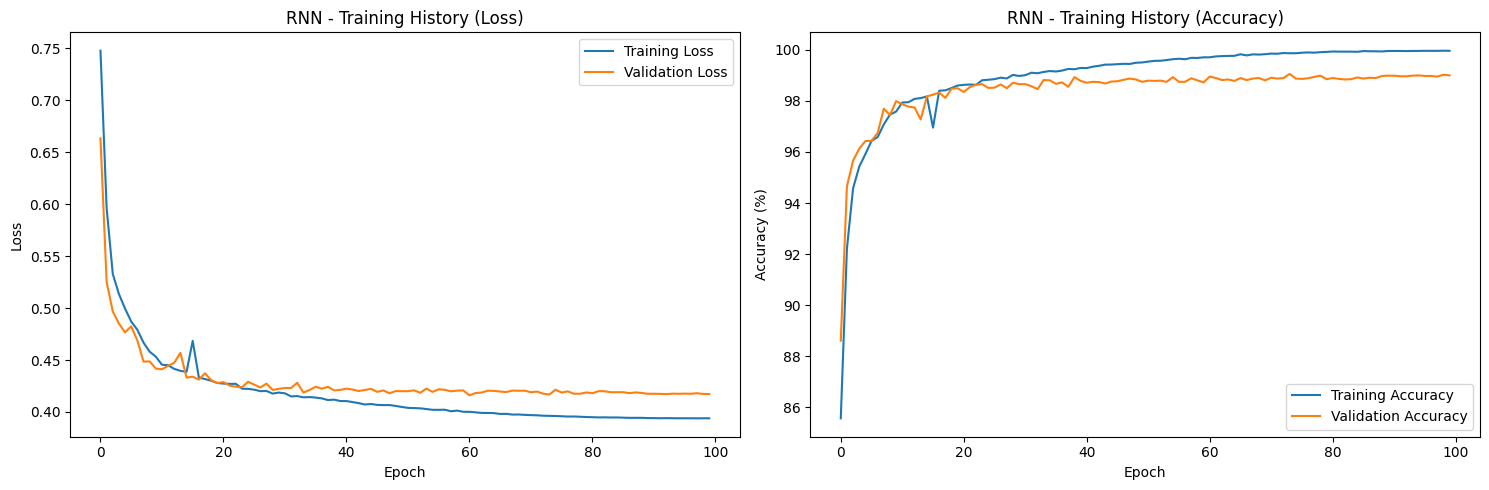

Testing: 100%|██████████| 343/343 [00:00<00:00, 390.37it/s]



Classification Report (RNN):
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     18118
           1       0.93      0.83      0.87       556
           2       0.97      0.96      0.97      1448
           3       0.86      0.84      0.85       162
           4       1.00      0.99      0.99      1608

    accuracy                           0.99     21892
   macro avg       0.95      0.92      0.94     21892
weighted avg       0.99      0.99      0.99     21892



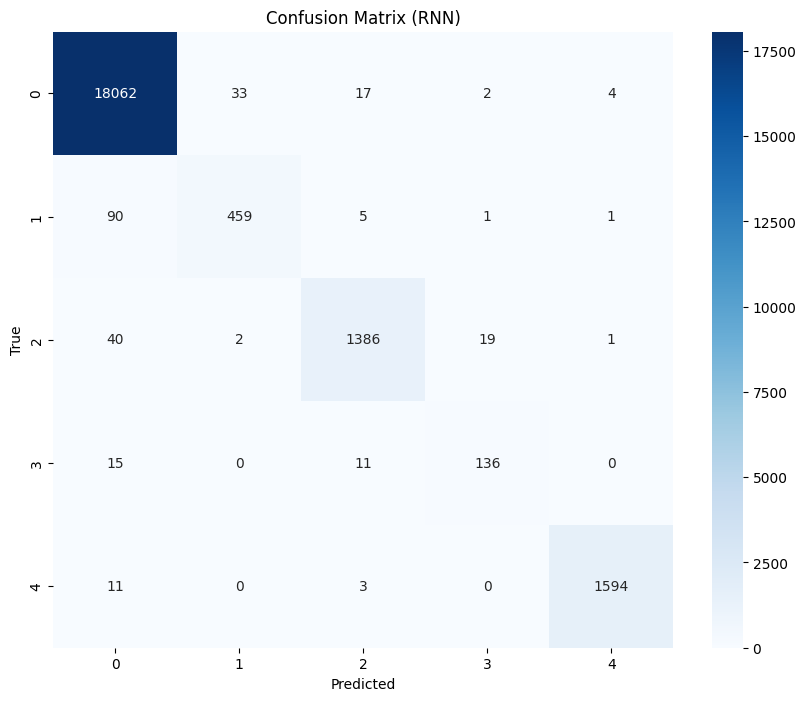

In [23]:
 # Update configuration based on actual data
config = get_training_config()
num_classes = len(np.unique(y_train))
sequence_length = X_train.shape[1]

# Update both model configurations
config['RNN']['model_params']['num_classes'] = num_classes
config['CNN']['model_params']['num_classes'] = num_classes
config['CNN']['model_params']['sequence_length'] = sequence_length

print("\nUpdated configuration:")
print(f"Number of classes: {num_classes}")
print(f"Sequence length: {sequence_length}")

# Train models
rnn_trainer = train_rnn_model(X_train, X_val, X_test, y_train, y_val, y_test)

In [24]:
def get_test_accuracy(model, test_loader, device, model_name=''):
    model.eval()
    correct = 0
    total = 0
    
    print(f"\nEvaluating {model_name} model...")
    
    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            
            # Handle different model outputs
            if model_name == 'RNN':
                outputs, _ = model(batch_X)
            else:
                outputs = model(batch_X)
            
            _, predicted = torch.max(outputs.data, 1)
            total += batch_y.size(0)
            correct += (predicted == batch_y).sum().item()
    
    accuracy = 100 * correct / total
    print(f"{model_name} Test Accuracy: {accuracy:.2f}%")
    return accuracy

In [25]:
# Create test loader
test_dataset = ECGDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=32)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Get accuracies
rnn_accuracy = get_test_accuracy(rnn_trainer.model, test_loader, device, "RNN")

print("\nSummary:")
print(f"RNN Test Accuracy: {rnn_accuracy:.2f}%")


Evaluating RNN model...
RNN Test Accuracy: 98.84%

Summary:
RNN Test Accuracy: 98.84%


In [26]:
#save RNN model
# torch.save(rnn_trainer.model.state_dict(), 'rnn_final_model.pth')

torch.save({
            'model_state_dict': rnn_trainer.model.state_dict(),
            'optimizer_state_dict': rnn_trainer.optimizer.state_dict(),
            'train_losses': rnn_trainer.train_losses,
            'val_losses': rnn_trainer.val_losses,
            'train_accuracies': rnn_trainer.train_accuracies,
            'val_accuracies': rnn_trainer.val_accuracies,
            'config': rnn_trainer.config
        }, 'rnn_final_model.pth')

# ECG on CNN Model

In [28]:
class ECG_CNN(nn.Module):
    def __init__(self, input_channels=1, sequence_length=187, num_classes=5):
        """
        Improved CNN model for ECG classification with:
        - Increased regularization
        - Label smoothing
        - Larger kernel sizes for ECG patterns
        - Spatial dropout
        """
        super(ECG_CNN, self).__init__()
        
        # First convolutional block with larger kernel
        self.conv1 = nn.Sequential(
            nn.Conv1d(input_channels, 32, kernel_size=15, stride=1, padding=7),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout1d(0.2),  # Spatial dropout
            nn.MaxPool1d(kernel_size=2, stride=2)
        )
        
        # Improved residual blocks with increased regularization
        self.res_block1 = ImprovedResidualBlock(32, 64, dropout_rate=0.3)
        self.res_block2 = ImprovedResidualBlock(64, 128, dropout_rate=0.3)
        self.res_block3 = ImprovedResidualBlock(128, 256, dropout_rate=0.3)
        
        # Calculate the size of flattened features
        self._feature_size = self._get_feature_size(input_channels, sequence_length)
        
        # Improved fully connected layers with stronger regularization
        self.fc_layers = nn.Sequential(
            nn.Linear(self._feature_size, 512),
            nn.LayerNorm(512),  # Layer normalization
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.LayerNorm(256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, num_classes)
        )
        
        # Initialize weights with a better scaling factor
        self.apply(self._init_weights)
    
    def _get_feature_size(self, input_channels, sequence_length):
        """Calculate the size of flattened features after convolutions"""
        # Create a dummy tensor to forward through the network
        x = torch.randn(1, input_channels, sequence_length)
        x = self.conv1(x)
        x = self.res_block1(x)
        x = self.res_block2(x)
        x = self.res_block3(x)
        
        # Return the flattened size
        return x.view(1, -1).size(1)
    
    def _init_weights(self, m):
        if isinstance(m, nn.Conv1d):
            nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu', a=0.1)
        elif isinstance(m, nn.BatchNorm1d):
            nn.init.constant_(m.weight, 1)
            nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.Linear):
            nn.init.xavier_normal_(m.weight)
            nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        # Input shape: (batch_size, sequence_length, input_channels)
        # Reshape for 1D convolution
        x = x.transpose(1, 2)
        
        # Convolutional layers
        x = self.conv1(x)
        x = self.res_block1(x)
        x = self.res_block2(x)
        x = self.res_block3(x)
        
        # Flatten
        batch_size = x.size(0)
        x = x.view(batch_size, -1)
        
        # Fully connected layers
        x = self.fc_layers(x)
        
        return x

In [29]:
class ImprovedResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, dropout_rate=0.3):
        super(ImprovedResidualBlock, self).__init__()
        
        self.conv_block = nn.Sequential(
            nn.Conv1d(in_channels, out_channels, kernel_size=7, stride=1, padding=3),
            nn.BatchNorm1d(out_channels),
            nn.ReLU(),
            nn.Dropout1d(dropout_rate),
            nn.Conv1d(out_channels, out_channels, kernel_size=7, stride=1, padding=3),
            nn.BatchNorm1d(out_channels)
        )
        
        self.skip_connection = nn.Sequential(
            nn.Conv1d(in_channels, out_channels, kernel_size=1, stride=1),
            nn.BatchNorm1d(out_channels)
        ) if in_channels != out_channels else nn.Identity()
        
        self.dropout = nn.Dropout1d(dropout_rate)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        residual = self.skip_connection(x)
        x = self.conv_block(x)
        x = self.dropout(x + residual)
        x = self.relu(x)
        return x

In [30]:
def train_cnn_model(X_train, X_val, X_test, y_train, y_val, y_test):
    """Train CNN models"""
    # Set device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    # Get configurations
    config = get_training_config()
    
    # Create data loaders
    train_dataset = ECGDataset(X_train, y_train)
    val_dataset = ECGDataset(X_val, y_val)
    test_dataset = ECGDataset(X_test, y_test)
    
    batch_size = config['RNN']['training_params']['batch_size']
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)
    
    # Initialize models
    cnn_model = ECG_CNN(**config['CNN']['model_params'])
    
    # Initialize criterion with label smoothing
    cnn_criterion = SmoothCrossEntropyLoss(smoothing=config['CNN']['training_params']['label_smoothing'])
   
    # Train CNN
    cnn_trainer = ModelTrainer(
        model=cnn_model,
        model_name='CNN',
        device=device,
        criterion=cnn_criterion,
        config=config['CNN']['training_params']
    )
    cnn_trainer.train(
        train_loader,
        val_loader,
        config['CNN']['training_params']['num_epochs']
    )
    cnn_trainer.plot_training_history()
    cnn_trainer.evaluate(test_loader)
    
    return cnn_trainer


Updated configuration:
Number of classes: 5
Sequence length: 187
Using device: cuda

Starting training for CNN...


Training: 100%|██████████| 1232/1232 [00:08<00:00, 142.30it/s]



Epoch [1/100]
Train Loss: 0.6330, Train Acc: 91.06%
Val Loss: 0.5399, Val Acc: 93.97%
Learning Rate: 0.000680
New best model saved! (Val Loss: 0.5399)


Training: 100%|██████████| 1232/1232 [00:08<00:00, 146.02it/s]



Epoch [2/100]
Train Loss: 0.5099, Train Acc: 95.49%
Val Loss: 0.4602, Val Acc: 97.08%
Learning Rate: 0.001260
New best model saved! (Val Loss: 0.4602)


Training: 100%|██████████| 1232/1232 [00:08<00:00, 146.23it/s]



Epoch [3/100]
Train Loss: 0.4818, Train Acc: 96.53%
Val Loss: 0.4565, Val Acc: 97.36%
Learning Rate: 0.001840
New best model saved! (Val Loss: 0.4565)


Training: 100%|██████████| 1232/1232 [00:08<00:00, 145.93it/s]



Epoch [4/100]
Train Loss: 0.4706, Train Acc: 96.92%
Val Loss: 0.4499, Val Acc: 97.78%
Learning Rate: 0.002420
New best model saved! (Val Loss: 0.4499)


Training: 100%|██████████| 1232/1232 [00:08<00:00, 146.72it/s]



Epoch [5/100]
Train Loss: 0.4622, Train Acc: 97.23%
Val Loss: 0.4411, Val Acc: 97.74%
Learning Rate: 0.003000
New best model saved! (Val Loss: 0.4411)


Training: 100%|██████████| 1232/1232 [00:08<00:00, 146.20it/s]



Epoch [6/100]
Train Loss: 0.4562, Train Acc: 97.38%
Val Loss: 0.4405, Val Acc: 97.93%
Learning Rate: 0.002999
New best model saved! (Val Loss: 0.4405)


Training: 100%|██████████| 1232/1232 [00:08<00:00, 146.22it/s]



Epoch [7/100]
Train Loss: 0.4493, Train Acc: 97.63%
Val Loss: 0.4320, Val Acc: 98.13%
Learning Rate: 0.002997
New best model saved! (Val Loss: 0.4320)


Training: 100%|██████████| 1232/1232 [00:08<00:00, 146.34it/s]



Epoch [8/100]
Train Loss: 0.4424, Train Acc: 97.93%
Val Loss: 0.4316, Val Acc: 98.12%
Learning Rate: 0.002993
New best model saved! (Val Loss: 0.4316)


Training: 100%|██████████| 1232/1232 [00:08<00:00, 146.90it/s]



Epoch [9/100]
Train Loss: 0.4379, Train Acc: 98.06%
Val Loss: 0.4277, Val Acc: 98.40%
Learning Rate: 0.002987
New best model saved! (Val Loss: 0.4277)


Training: 100%|██████████| 1232/1232 [00:08<00:00, 146.24it/s]



Epoch [10/100]
Train Loss: 0.4343, Train Acc: 98.21%
Val Loss: 0.4271, Val Acc: 98.44%
Learning Rate: 0.002980
New best model saved! (Val Loss: 0.4271)


Training: 100%|██████████| 1232/1232 [00:08<00:00, 145.79it/s]



Epoch [11/100]
Train Loss: 0.4314, Train Acc: 98.35%
Val Loss: 0.4265, Val Acc: 98.38%
Learning Rate: 0.002972
New best model saved! (Val Loss: 0.4265)


Training: 100%|██████████| 1232/1232 [00:08<00:00, 146.52it/s]



Epoch [12/100]
Train Loss: 0.4282, Train Acc: 98.48%
Val Loss: 0.4233, Val Acc: 98.55%
Learning Rate: 0.002961
New best model saved! (Val Loss: 0.4233)


Training: 100%|██████████| 1232/1232 [00:08<00:00, 146.26it/s]



Epoch [13/100]
Train Loss: 0.4242, Train Acc: 98.63%
Val Loss: 0.4222, Val Acc: 98.70%
Learning Rate: 0.002950
New best model saved! (Val Loss: 0.4222)


Training: 100%|██████████| 1232/1232 [00:08<00:00, 145.35it/s]



Epoch [14/100]
Train Loss: 0.4227, Train Acc: 98.71%
Val Loss: 0.4224, Val Acc: 98.58%
Learning Rate: 0.002936


Training: 100%|██████████| 1232/1232 [00:08<00:00, 144.84it/s]



Epoch [15/100]
Train Loss: 0.4203, Train Acc: 98.76%
Val Loss: 0.4283, Val Acc: 98.48%
Learning Rate: 0.002921


Training: 100%|██████████| 1232/1232 [00:08<00:00, 146.05it/s]



Epoch [16/100]
Train Loss: 0.4187, Train Acc: 98.84%
Val Loss: 0.4235, Val Acc: 98.57%
Learning Rate: 0.002905


Training: 100%|██████████| 1232/1232 [00:08<00:00, 144.82it/s]



Epoch [17/100]
Train Loss: 0.4168, Train Acc: 98.92%
Val Loss: 0.4213, Val Acc: 98.74%
Learning Rate: 0.002887
New best model saved! (Val Loss: 0.4213)


Training: 100%|██████████| 1232/1232 [00:08<00:00, 145.27it/s]



Epoch [18/100]
Train Loss: 0.4166, Train Acc: 98.90%
Val Loss: 0.4200, Val Acc: 98.76%
Learning Rate: 0.002868
New best model saved! (Val Loss: 0.4200)


Training: 100%|██████████| 1232/1232 [00:08<00:00, 145.37it/s]



Epoch [19/100]
Train Loss: 0.4148, Train Acc: 99.01%
Val Loss: 0.4218, Val Acc: 98.69%
Learning Rate: 0.002847


Training: 100%|██████████| 1232/1232 [00:08<00:00, 144.46it/s]



Epoch [20/100]
Train Loss: 0.4133, Train Acc: 99.06%
Val Loss: 0.4221, Val Acc: 98.72%
Learning Rate: 0.002825


Training: 100%|██████████| 1232/1232 [00:08<00:00, 145.55it/s]



Epoch [21/100]
Train Loss: 0.4120, Train Acc: 99.12%
Val Loss: 0.4238, Val Acc: 98.65%
Learning Rate: 0.002802


Training: 100%|██████████| 1232/1232 [00:08<00:00, 144.96it/s]



Epoch [22/100]
Train Loss: 0.4113, Train Acc: 99.14%
Val Loss: 0.4214, Val Acc: 98.79%
Learning Rate: 0.002777


Training: 100%|██████████| 1232/1232 [00:08<00:00, 145.99it/s]



Epoch [23/100]
Train Loss: 0.4099, Train Acc: 99.21%
Val Loss: 0.4225, Val Acc: 98.72%
Learning Rate: 0.002751


Training: 100%|██████████| 1232/1232 [00:08<00:00, 145.07it/s]



Epoch [24/100]
Train Loss: 0.4089, Train Acc: 99.26%
Val Loss: 0.4247, Val Acc: 98.60%
Learning Rate: 0.002723


Training: 100%|██████████| 1232/1232 [00:08<00:00, 145.45it/s]



Epoch [25/100]
Train Loss: 0.4087, Train Acc: 99.27%
Val Loss: 0.4205, Val Acc: 98.79%
Learning Rate: 0.002694


Training: 100%|██████████| 1232/1232 [00:08<00:00, 145.34it/s]



Epoch [26/100]
Train Loss: 0.4081, Train Acc: 99.27%
Val Loss: 0.4199, Val Acc: 98.86%
Learning Rate: 0.002664
New best model saved! (Val Loss: 0.4199)


Training: 100%|██████████| 1232/1232 [00:08<00:00, 145.73it/s]



Epoch [27/100]
Train Loss: 0.4064, Train Acc: 99.38%
Val Loss: 0.4212, Val Acc: 98.73%
Learning Rate: 0.002633


Training: 100%|██████████| 1232/1232 [00:08<00:00, 144.29it/s]



Epoch [28/100]
Train Loss: 0.4066, Train Acc: 99.35%
Val Loss: 0.4207, Val Acc: 98.80%
Learning Rate: 0.002600


Training: 100%|██████████| 1232/1232 [00:08<00:00, 145.60it/s]



Epoch [29/100]
Train Loss: 0.4053, Train Acc: 99.42%
Val Loss: 0.4222, Val Acc: 98.77%
Learning Rate: 0.002567


Training: 100%|██████████| 1232/1232 [00:08<00:00, 145.55it/s]



Epoch [30/100]
Train Loss: 0.4049, Train Acc: 99.43%
Val Loss: 0.4230, Val Acc: 98.68%
Learning Rate: 0.002532


Training: 100%|██████████| 1232/1232 [00:08<00:00, 145.30it/s]



Epoch [31/100]
Train Loss: 0.4041, Train Acc: 99.48%
Val Loss: 0.4219, Val Acc: 98.77%
Learning Rate: 0.002496


Training: 100%|██████████| 1232/1232 [00:08<00:00, 145.99it/s]



Epoch [32/100]
Train Loss: 0.4043, Train Acc: 99.45%
Val Loss: 0.4223, Val Acc: 98.78%
Learning Rate: 0.002459


Training: 100%|██████████| 1232/1232 [00:08<00:00, 145.03it/s]



Epoch [33/100]
Train Loss: 0.4035, Train Acc: 99.51%
Val Loss: 0.4195, Val Acc: 98.92%
Learning Rate: 0.002422
New best model saved! (Val Loss: 0.4195)


Training: 100%|██████████| 1232/1232 [00:08<00:00, 145.30it/s]



Epoch [34/100]
Train Loss: 0.4029, Train Acc: 99.51%
Val Loss: 0.4196, Val Acc: 98.85%
Learning Rate: 0.002383


Training: 100%|██████████| 1232/1232 [00:08<00:00, 145.28it/s]



Epoch [35/100]
Train Loss: 0.4020, Train Acc: 99.56%
Val Loss: 0.4208, Val Acc: 98.76%
Learning Rate: 0.002343


Training: 100%|██████████| 1232/1232 [00:08<00:00, 145.96it/s]



Epoch [36/100]
Train Loss: 0.4021, Train Acc: 99.54%
Val Loss: 0.4229, Val Acc: 98.79%
Learning Rate: 0.002303


Training: 100%|██████████| 1232/1232 [00:08<00:00, 145.61it/s]



Epoch [37/100]
Train Loss: 0.4019, Train Acc: 99.54%
Val Loss: 0.4225, Val Acc: 98.84%
Learning Rate: 0.002261


Training: 100%|██████████| 1232/1232 [00:08<00:00, 145.44it/s]



Epoch [38/100]
Train Loss: 0.4015, Train Acc: 99.57%
Val Loss: 0.4237, Val Acc: 98.78%
Learning Rate: 0.002219


Training: 100%|██████████| 1232/1232 [00:08<00:00, 142.52it/s]



Epoch [39/100]
Train Loss: 0.4018, Train Acc: 99.57%
Val Loss: 0.4216, Val Acc: 98.77%
Learning Rate: 0.002176


Training: 100%|██████████| 1232/1232 [00:08<00:00, 145.03it/s]



Epoch [40/100]
Train Loss: 0.4005, Train Acc: 99.61%
Val Loss: 0.4215, Val Acc: 98.76%
Learning Rate: 0.002132


Training: 100%|██████████| 1232/1232 [00:08<00:00, 145.62it/s]



Epoch [41/100]
Train Loss: 0.4004, Train Acc: 99.61%
Val Loss: 0.4230, Val Acc: 98.70%
Learning Rate: 0.002088


Training: 100%|██████████| 1232/1232 [00:08<00:00, 147.06it/s]



Epoch [42/100]
Train Loss: 0.3998, Train Acc: 99.64%
Val Loss: 0.4219, Val Acc: 98.72%
Learning Rate: 0.002043


Training: 100%|██████████| 1232/1232 [00:08<00:00, 145.47it/s]



Epoch [43/100]
Train Loss: 0.3994, Train Acc: 99.67%
Val Loss: 0.4228, Val Acc: 98.80%
Learning Rate: 0.001998


Training: 100%|██████████| 1232/1232 [00:08<00:00, 146.85it/s]



Epoch [44/100]
Train Loss: 0.3987, Train Acc: 99.68%
Val Loss: 0.4202, Val Acc: 98.82%
Learning Rate: 0.001952


Training: 100%|██████████| 1232/1232 [00:08<00:00, 146.87it/s]



Epoch [45/100]
Train Loss: 0.3996, Train Acc: 99.66%
Val Loss: 0.4215, Val Acc: 98.74%
Learning Rate: 0.001906


Training: 100%|██████████| 1232/1232 [00:08<00:00, 146.83it/s]



Epoch [46/100]
Train Loss: 0.3987, Train Acc: 99.69%
Val Loss: 0.4223, Val Acc: 98.73%
Learning Rate: 0.001859


Training: 100%|██████████| 1232/1232 [00:08<00:00, 147.49it/s]



Epoch [47/100]
Train Loss: 0.3980, Train Acc: 99.72%
Val Loss: 0.4222, Val Acc: 98.84%
Learning Rate: 0.001812


Training: 100%|██████████| 1232/1232 [00:08<00:00, 146.61it/s]



Epoch [48/100]
Train Loss: 0.3986, Train Acc: 99.68%
Val Loss: 0.4239, Val Acc: 98.77%
Learning Rate: 0.001765


Training: 100%|██████████| 1232/1232 [00:08<00:00, 147.37it/s]



Epoch [49/100]
Train Loss: 0.3985, Train Acc: 99.70%
Val Loss: 0.4229, Val Acc: 98.85%
Learning Rate: 0.001717


Training: 100%|██████████| 1232/1232 [00:08<00:00, 146.89it/s]



Epoch [50/100]
Train Loss: 0.3979, Train Acc: 99.72%
Val Loss: 0.4216, Val Acc: 98.80%
Learning Rate: 0.001670


Training: 100%|██████████| 1232/1232 [00:08<00:00, 146.90it/s]



Epoch [51/100]
Train Loss: 0.3979, Train Acc: 99.72%
Val Loss: 0.4235, Val Acc: 98.74%
Learning Rate: 0.001622


Training: 100%|██████████| 1232/1232 [00:08<00:00, 146.54it/s]



Epoch [52/100]
Train Loss: 0.3971, Train Acc: 99.75%
Val Loss: 0.4221, Val Acc: 98.86%
Learning Rate: 0.001574


Training: 100%|██████████| 1232/1232 [00:08<00:00, 146.97it/s]



Epoch [53/100]
Train Loss: 0.3973, Train Acc: 99.73%
Val Loss: 0.4213, Val Acc: 98.82%
Learning Rate: 0.001526


Training: 100%|██████████| 1232/1232 [00:08<00:00, 146.83it/s]



Epoch [54/100]
Train Loss: 0.3968, Train Acc: 99.77%
Val Loss: 0.4210, Val Acc: 98.88%
Learning Rate: 0.001478


Training: 100%|██████████| 1232/1232 [00:08<00:00, 146.62it/s]



Epoch [55/100]
Train Loss: 0.3970, Train Acc: 99.75%
Val Loss: 0.4200, Val Acc: 98.87%
Learning Rate: 0.001430


Training: 100%|██████████| 1232/1232 [00:08<00:00, 147.00it/s]



Epoch [56/100]
Train Loss: 0.3965, Train Acc: 99.79%
Val Loss: 0.4211, Val Acc: 98.90%
Learning Rate: 0.001383


Training: 100%|██████████| 1232/1232 [00:08<00:00, 147.03it/s]



Epoch [57/100]
Train Loss: 0.3966, Train Acc: 99.77%
Val Loss: 0.4219, Val Acc: 98.85%
Learning Rate: 0.001335


Training: 100%|██████████| 1232/1232 [00:08<00:00, 147.04it/s]



Epoch [58/100]
Train Loss: 0.3960, Train Acc: 99.80%
Val Loss: 0.4232, Val Acc: 98.82%
Learning Rate: 0.001288


Training: 100%|██████████| 1232/1232 [00:08<00:00, 146.49it/s]



Epoch [59/100]
Train Loss: 0.3961, Train Acc: 99.81%
Val Loss: 0.4207, Val Acc: 98.84%
Learning Rate: 0.001241


Training: 100%|██████████| 1232/1232 [00:08<00:00, 147.21it/s]



Epoch [60/100]
Train Loss: 0.3967, Train Acc: 99.77%
Val Loss: 0.4223, Val Acc: 98.79%
Learning Rate: 0.001194


Training: 100%|██████████| 1232/1232 [00:08<00:00, 146.89it/s]



Epoch [61/100]
Train Loss: 0.3958, Train Acc: 99.83%
Val Loss: 0.4243, Val Acc: 98.85%
Learning Rate: 0.001148


Training: 100%|██████████| 1232/1232 [00:08<00:00, 146.20it/s]



Epoch [62/100]
Train Loss: 0.3957, Train Acc: 99.82%
Val Loss: 0.4231, Val Acc: 98.78%
Learning Rate: 0.001102


Training: 100%|██████████| 1232/1232 [00:08<00:00, 146.54it/s]



Epoch [63/100]
Train Loss: 0.3961, Train Acc: 99.79%
Val Loss: 0.4227, Val Acc: 98.76%
Learning Rate: 0.001057


Training: 100%|██████████| 1232/1232 [00:08<00:00, 147.39it/s]



Epoch [64/100]
Train Loss: 0.3955, Train Acc: 99.82%
Val Loss: 0.4239, Val Acc: 98.77%
Learning Rate: 0.001012


Training: 100%|██████████| 1232/1232 [00:08<00:00, 147.12it/s]



Epoch [65/100]
Train Loss: 0.3954, Train Acc: 99.84%
Val Loss: 0.4237, Val Acc: 98.76%
Learning Rate: 0.000968


Training: 100%|██████████| 1232/1232 [00:08<00:00, 145.50it/s]



Epoch [66/100]
Train Loss: 0.3951, Train Acc: 99.83%
Val Loss: 0.4255, Val Acc: 98.72%
Learning Rate: 0.000924


Training: 100%|██████████| 1232/1232 [00:08<00:00, 147.40it/s]



Epoch [67/100]
Train Loss: 0.3949, Train Acc: 99.84%
Val Loss: 0.4239, Val Acc: 98.76%
Learning Rate: 0.000881


Training: 100%|██████████| 1232/1232 [00:08<00:00, 146.75it/s]



Epoch [68/100]
Train Loss: 0.3951, Train Acc: 99.83%
Val Loss: 0.4241, Val Acc: 98.84%
Learning Rate: 0.000839


Training: 100%|██████████| 1232/1232 [00:08<00:00, 146.14it/s]



Epoch [69/100]
Train Loss: 0.3950, Train Acc: 99.84%
Val Loss: 0.4241, Val Acc: 98.79%
Learning Rate: 0.000797


Training: 100%|██████████| 1232/1232 [00:08<00:00, 146.90it/s]



Epoch [70/100]
Train Loss: 0.3947, Train Acc: 99.85%
Val Loss: 0.4239, Val Acc: 98.80%
Learning Rate: 0.000757


Training: 100%|██████████| 1232/1232 [00:08<00:00, 143.73it/s]



Epoch [71/100]
Train Loss: 0.3947, Train Acc: 99.86%
Val Loss: 0.4248, Val Acc: 98.74%
Learning Rate: 0.000717


Training: 100%|██████████| 1232/1232 [00:08<00:00, 143.24it/s]



Epoch [72/100]
Train Loss: 0.3949, Train Acc: 99.85%
Val Loss: 0.4231, Val Acc: 98.78%
Learning Rate: 0.000678


Training: 100%|██████████| 1232/1232 [00:08<00:00, 144.65it/s]



Epoch [73/100]
Train Loss: 0.3946, Train Acc: 99.86%
Val Loss: 0.4246, Val Acc: 98.79%
Learning Rate: 0.000641


Training: 100%|██████████| 1232/1232 [00:08<00:00, 138.90it/s]



Epoch [74/100]
Train Loss: 0.3947, Train Acc: 99.86%
Val Loss: 0.4242, Val Acc: 98.85%
Learning Rate: 0.000604


Training: 100%|██████████| 1232/1232 [00:08<00:00, 143.33it/s]



Epoch [75/100]
Train Loss: 0.3946, Train Acc: 99.87%
Val Loss: 0.4238, Val Acc: 98.81%
Learning Rate: 0.000568


Training: 100%|██████████| 1232/1232 [00:08<00:00, 144.06it/s]



Epoch [76/100]
Train Loss: 0.3943, Train Acc: 99.88%
Val Loss: 0.4244, Val Acc: 98.78%
Learning Rate: 0.000533


Training: 100%|██████████| 1232/1232 [00:08<00:00, 143.10it/s]



Epoch [77/100]
Train Loss: 0.3939, Train Acc: 99.89%
Val Loss: 0.4245, Val Acc: 98.81%
Learning Rate: 0.000500


Training: 100%|██████████| 1232/1232 [00:08<00:00, 144.59it/s]



Epoch [78/100]
Train Loss: 0.3939, Train Acc: 99.89%
Val Loss: 0.4244, Val Acc: 98.73%
Learning Rate: 0.000467


Training: 100%|██████████| 1232/1232 [00:08<00:00, 145.51it/s]



Epoch [79/100]
Train Loss: 0.3939, Train Acc: 99.89%
Val Loss: 0.4241, Val Acc: 98.80%
Learning Rate: 0.000436


Training: 100%|██████████| 1232/1232 [00:08<00:00, 145.94it/s]



Epoch [80/100]
Train Loss: 0.3937, Train Acc: 99.90%
Val Loss: 0.4242, Val Acc: 98.74%
Learning Rate: 0.000406


Training: 100%|██████████| 1232/1232 [00:08<00:00, 144.76it/s]



Epoch [81/100]
Train Loss: 0.3939, Train Acc: 99.88%
Val Loss: 0.4239, Val Acc: 98.73%
Learning Rate: 0.000377


Training: 100%|██████████| 1232/1232 [00:08<00:00, 144.23it/s]



Epoch [82/100]
Train Loss: 0.3939, Train Acc: 99.89%
Val Loss: 0.4246, Val Acc: 98.78%
Learning Rate: 0.000349


Training: 100%|██████████| 1232/1232 [00:08<00:00, 143.73it/s]



Epoch [83/100]
Train Loss: 0.3939, Train Acc: 99.89%
Val Loss: 0.4248, Val Acc: 98.78%
Learning Rate: 0.000323


Training: 100%|██████████| 1232/1232 [00:08<00:00, 144.38it/s]



Epoch [84/100]
Train Loss: 0.3937, Train Acc: 99.91%
Val Loss: 0.4245, Val Acc: 98.76%
Learning Rate: 0.000298


Training: 100%|██████████| 1232/1232 [00:08<00:00, 143.26it/s]



Epoch [85/100]
Train Loss: 0.3935, Train Acc: 99.91%
Val Loss: 0.4245, Val Acc: 98.77%
Learning Rate: 0.000275


Training: 100%|██████████| 1232/1232 [00:08<00:00, 143.27it/s]



Epoch [86/100]
Train Loss: 0.3934, Train Acc: 99.90%
Val Loss: 0.4251, Val Acc: 98.74%
Learning Rate: 0.000253


Training: 100%|██████████| 1232/1232 [00:08<00:00, 144.50it/s]



Epoch [87/100]
Train Loss: 0.3933, Train Acc: 99.91%
Val Loss: 0.4239, Val Acc: 98.76%
Learning Rate: 0.000232


Training: 100%|██████████| 1232/1232 [00:08<00:00, 144.40it/s]



Epoch [88/100]
Train Loss: 0.3935, Train Acc: 99.90%
Val Loss: 0.4238, Val Acc: 98.80%
Learning Rate: 0.000213


Training: 100%|██████████| 1232/1232 [00:08<00:00, 142.77it/s]



Epoch [89/100]
Train Loss: 0.3933, Train Acc: 99.91%
Val Loss: 0.4240, Val Acc: 98.78%
Learning Rate: 0.000195


Training: 100%|██████████| 1232/1232 [00:08<00:00, 140.84it/s]



Epoch [90/100]
Train Loss: 0.3933, Train Acc: 99.91%
Val Loss: 0.4243, Val Acc: 98.77%
Learning Rate: 0.000179


Training: 100%|██████████| 1232/1232 [00:08<00:00, 143.88it/s]



Epoch [91/100]
Train Loss: 0.3935, Train Acc: 99.90%
Val Loss: 0.4242, Val Acc: 98.74%
Learning Rate: 0.000164


Training: 100%|██████████| 1232/1232 [00:08<00:00, 143.71it/s]



Epoch [92/100]
Train Loss: 0.3936, Train Acc: 99.90%
Val Loss: 0.4243, Val Acc: 98.76%
Learning Rate: 0.000150


Training: 100%|██████████| 1232/1232 [00:08<00:00, 142.85it/s]



Epoch [93/100]
Train Loss: 0.3933, Train Acc: 99.91%
Val Loss: 0.4241, Val Acc: 98.79%
Learning Rate: 0.000139


Training: 100%|██████████| 1232/1232 [00:08<00:00, 142.08it/s]



Epoch [94/100]
Train Loss: 0.3932, Train Acc: 99.91%
Val Loss: 0.4248, Val Acc: 98.80%
Learning Rate: 0.000128


Training: 100%|██████████| 1232/1232 [00:08<00:00, 137.76it/s]



Epoch [95/100]
Train Loss: 0.3934, Train Acc: 99.92%
Val Loss: 0.4245, Val Acc: 98.79%
Learning Rate: 0.000120


Training: 100%|██████████| 1232/1232 [00:08<00:00, 143.80it/s]



Epoch [96/100]
Train Loss: 0.3932, Train Acc: 99.92%
Val Loss: 0.4244, Val Acc: 98.79%
Learning Rate: 0.000113


Training: 100%|██████████| 1232/1232 [00:08<00:00, 146.14it/s]



Epoch [97/100]
Train Loss: 0.3934, Train Acc: 99.91%
Val Loss: 0.4245, Val Acc: 98.81%
Learning Rate: 0.000107


Training: 100%|██████████| 1232/1232 [00:08<00:00, 146.71it/s]



Epoch [98/100]
Train Loss: 0.3931, Train Acc: 99.93%
Val Loss: 0.4243, Val Acc: 98.81%
Learning Rate: 0.000103


Training: 100%|██████████| 1232/1232 [00:08<00:00, 146.49it/s]



Epoch [99/100]
Train Loss: 0.3935, Train Acc: 99.90%
Val Loss: 0.4245, Val Acc: 98.81%
Learning Rate: 0.000101


Training: 100%|██████████| 1232/1232 [00:08<00:00, 146.33it/s]



Epoch [100/100]
Train Loss: 0.3935, Train Acc: 99.90%
Val Loss: 0.4243, Val Acc: 98.81%
Learning Rate: 0.000100


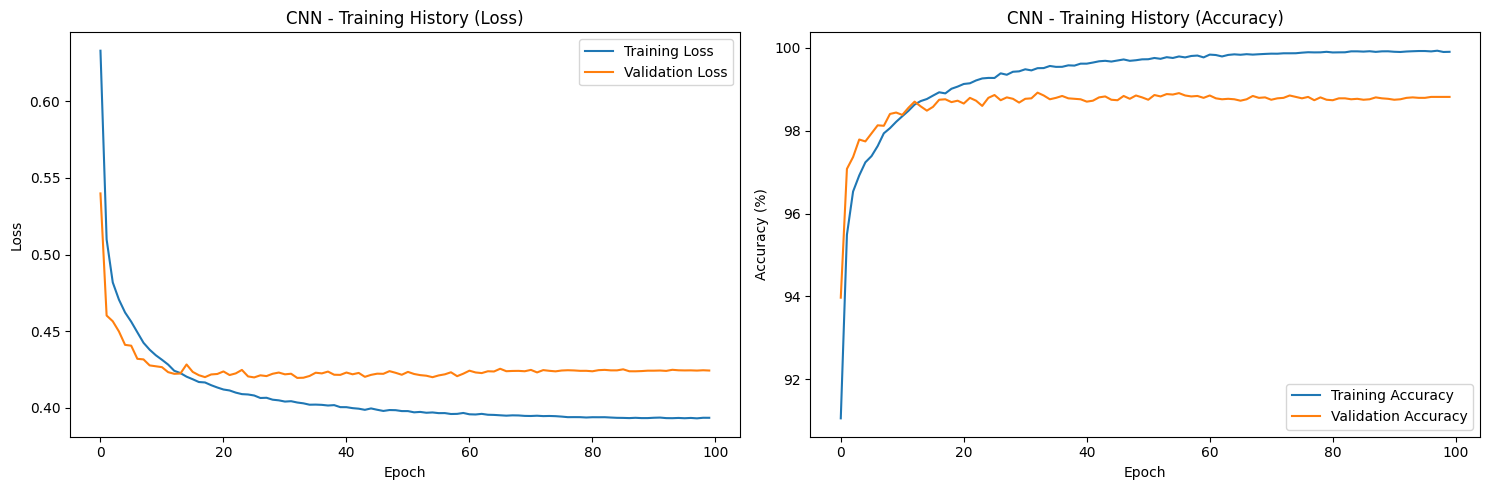

Testing: 100%|██████████| 343/343 [00:00<00:00, 573.90it/s]



Classification Report (CNN):
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     18118
           1       0.91      0.82      0.86       556
           2       0.97      0.96      0.96      1448
           3       0.86      0.77      0.81       162
           4       0.99      0.99      0.99      1608

    accuracy                           0.99     21892
   macro avg       0.95      0.91      0.93     21892
weighted avg       0.99      0.99      0.99     21892



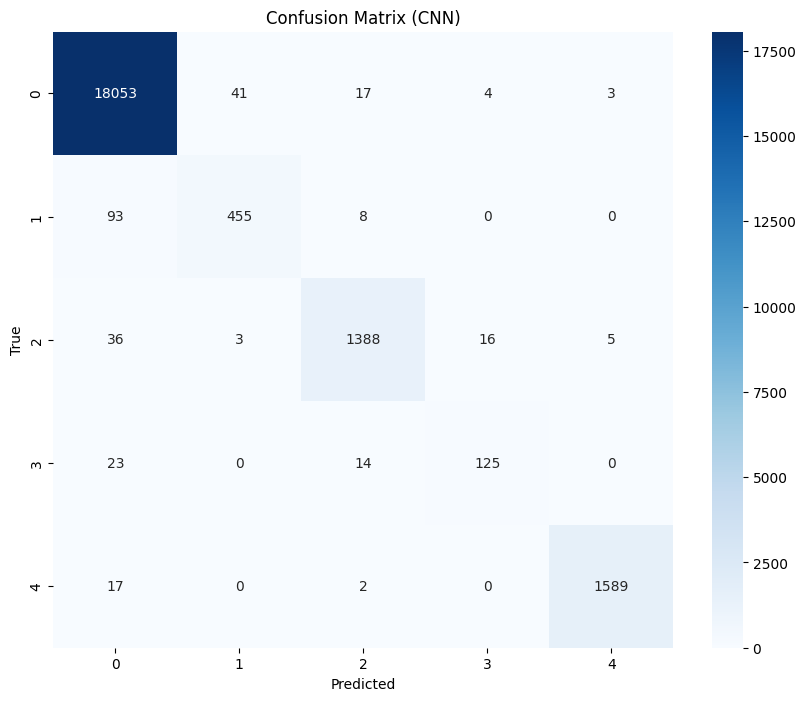

In [31]:
 # Update configuration based on actual data
config = get_training_config()
num_classes = len(np.unique(y_train))
sequence_length = X_train.shape[1]

# Update both model configurations
config['RNN']['model_params']['num_classes'] = num_classes
config['CNN']['model_params']['num_classes'] = num_classes
config['CNN']['model_params']['sequence_length'] = sequence_length

print("\nUpdated configuration:")
print(f"Number of classes: {num_classes}")
print(f"Sequence length: {sequence_length}")

# Train models
cnn_trainer = train_cnn_model(X_train, X_val, X_test, y_train, y_val, y_test)

In [32]:
#save CNN model
# torch.save(cnn_trainer.model.state_dict(), 'cnn_final_model.pth')
torch.save({
            'model_state_dict': cnn_trainer.model.state_dict(),
            'optimizer_state_dict': cnn_trainer.optimizer.state_dict(),
            'train_losses': cnn_trainer.train_losses,
            'val_losses': cnn_trainer.val_losses,
            'train_accuracies': cnn_trainer.train_accuracies,
            'val_accuracies': cnn_trainer.val_accuracies,
            'config': cnn_trainer.config
        }, 'cnn_final_model.pth')

In [33]:
# Overview so far

test_dataset = ECGDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=32)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Get accuracies
rnn_accuracy = get_test_accuracy(rnn_trainer.model, test_loader, device, "RNN")
cnn_accuracy = get_test_accuracy(cnn_trainer.model, test_loader, device, "CNN")

print("\nSummary:")
print(f"RNN Test Accuracy: {rnn_accuracy:.2f}%")
print(f"CNN Test Accuracy: {cnn_accuracy:.2f}%")


Evaluating RNN model...
RNN Test Accuracy: 98.84%

Evaluating CNN model...
CNN Test Accuracy: 98.71%

Summary:
RNN Test Accuracy: 98.84%
CNN Test Accuracy: 98.71%


# ECG Data on GRU Attention RNN 

In [35]:
class AttentionRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout=0.2):
        super(AttentionRNN, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # Bidirectional GRU for capturing temporal dependencies
        self.gru = nn.GRU(input_size, hidden_size, num_layers, 
                         batch_first=True, bidirectional=True, dropout=dropout)
        
        # Attention mechanism
        self.attention = nn.Sequential(
            nn.Linear(hidden_size * 2, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, 1)
        )
        
        # Optional skip connection
        self.skip_connection = nn.Linear(input_size, hidden_size * 2)
        
        # Classification layers with regularization
        self.fc1 = nn.Linear(hidden_size * 2, hidden_size)
        self.dropout = nn.Dropout(dropout)
        self.batch_norm = nn.BatchNorm1d(hidden_size)
        self.fc2 = nn.Linear(hidden_size, num_classes)
        
    def forward(self, x):
        # Initial GRU processing
        gru_out, _ = self.gru(x)  # Shape: (batch, seq_len, hidden_size*2)
        
        # Skip connection
        skip = self.skip_connection(x)  # Transform input to match GRU output dimensions
        gru_out = gru_out + skip  # Residual connection
        
        # Attention mechanism
        attention_weights = self.attention(gru_out)  # Shape: (batch, seq_len, 1)
        attention_weights = torch.softmax(attention_weights, dim=1)
        
        # Apply attention
        context = torch.sum(attention_weights * gru_out, dim=1)  # Shape: (batch, hidden_size*2)
        
        # Classification with regularization
        out = self.fc1(context)
        out = self.batch_norm(out)
        out = torch.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        
        return out, attention_weights

Using device: cuda
Starting training...


Epoch 1/100: 100%|██████████| 2463/2463 [00:07<00:00, 313.92it/s]


Epoch [1/100]
Train Loss: 0.2494, Val Loss: 0.1462
Validation Accuracy: 95.67%


Epoch 2/100: 100%|██████████| 2463/2463 [00:07<00:00, 316.92it/s]


Epoch [2/100]
Train Loss: 0.1301, Val Loss: 0.1065
Validation Accuracy: 96.86%


Epoch 3/100: 100%|██████████| 2463/2463 [00:07<00:00, 320.47it/s]


Epoch [3/100]
Train Loss: 0.1051, Val Loss: 0.1018
Validation Accuracy: 97.10%


Epoch 4/100: 100%|██████████| 2463/2463 [00:07<00:00, 319.21it/s]


Epoch [4/100]
Train Loss: 0.0913, Val Loss: 0.0993
Validation Accuracy: 97.76%


Epoch 5/100: 100%|██████████| 2463/2463 [00:07<00:00, 320.30it/s]


Epoch [5/100]
Train Loss: 0.0819, Val Loss: 0.0755
Validation Accuracy: 97.89%


Epoch 6/100: 100%|██████████| 2463/2463 [00:07<00:00, 319.90it/s]


Epoch [6/100]
Train Loss: 0.0735, Val Loss: 0.0781
Validation Accuracy: 97.81%


Epoch 7/100: 100%|██████████| 2463/2463 [00:07<00:00, 320.59it/s]


Epoch [7/100]
Train Loss: 0.0674, Val Loss: 0.0601
Validation Accuracy: 98.26%


Epoch 8/100: 100%|██████████| 2463/2463 [00:07<00:00, 319.71it/s]


Epoch [8/100]
Train Loss: 0.0627, Val Loss: 0.0710
Validation Accuracy: 98.13%


Epoch 9/100: 100%|██████████| 2463/2463 [00:07<00:00, 320.61it/s]


Epoch [9/100]
Train Loss: 0.0569, Val Loss: 0.0593
Validation Accuracy: 98.31%


Epoch 10/100: 100%|██████████| 2463/2463 [00:07<00:00, 318.28it/s]


Epoch [10/100]
Train Loss: 0.0547, Val Loss: 0.0545
Validation Accuracy: 98.48%


Epoch 11/100: 100%|██████████| 2463/2463 [00:07<00:00, 320.82it/s]


Epoch [11/100]
Train Loss: 0.0524, Val Loss: 0.0534
Validation Accuracy: 98.45%


Epoch 12/100: 100%|██████████| 2463/2463 [00:07<00:00, 320.19it/s]


Epoch [12/100]
Train Loss: 0.0491, Val Loss: 0.0503
Validation Accuracy: 98.55%


Epoch 13/100: 100%|██████████| 2463/2463 [00:07<00:00, 320.63it/s]


Epoch [13/100]
Train Loss: 0.0456, Val Loss: 0.0527
Validation Accuracy: 98.56%


Epoch 14/100: 100%|██████████| 2463/2463 [00:07<00:00, 318.88it/s]


Epoch [14/100]
Train Loss: 0.0447, Val Loss: 0.0487
Validation Accuracy: 98.72%


Epoch 15/100: 100%|██████████| 2463/2463 [00:07<00:00, 320.57it/s]


Epoch [15/100]
Train Loss: 0.0424, Val Loss: 0.0488
Validation Accuracy: 98.63%


Epoch 16/100: 100%|██████████| 2463/2463 [00:07<00:00, 320.05it/s]


Epoch [16/100]
Train Loss: 0.0420, Val Loss: 0.0555
Validation Accuracy: 98.45%


Epoch 17/100: 100%|██████████| 2463/2463 [00:07<00:00, 319.67it/s]


Epoch [17/100]
Train Loss: 0.0391, Val Loss: 0.0524
Validation Accuracy: 98.54%


Epoch 18/100: 100%|██████████| 2463/2463 [00:07<00:00, 318.36it/s]


Epoch 00018: reducing learning rate of group 0 to 5.0000e-04.
Epoch [18/100]
Train Loss: 0.0380, Val Loss: 0.0507
Validation Accuracy: 98.71%


Epoch 19/100: 100%|██████████| 2463/2463 [00:07<00:00, 320.36it/s]


Epoch [19/100]
Train Loss: 0.0268, Val Loss: 0.0471
Validation Accuracy: 98.84%


Epoch 20/100: 100%|██████████| 2463/2463 [00:07<00:00, 319.82it/s]


Epoch [20/100]
Train Loss: 0.0253, Val Loss: 0.0491
Validation Accuracy: 98.76%


Epoch 21/100: 100%|██████████| 2463/2463 [00:07<00:00, 320.97it/s]


Epoch [21/100]
Train Loss: 0.0235, Val Loss: 0.0433
Validation Accuracy: 98.89%


Epoch 22/100: 100%|██████████| 2463/2463 [00:07<00:00, 319.44it/s]


Epoch [22/100]
Train Loss: 0.0233, Val Loss: 0.0452
Validation Accuracy: 98.80%


Epoch 23/100: 100%|██████████| 2463/2463 [00:07<00:00, 321.22it/s]


Epoch [23/100]
Train Loss: 0.0228, Val Loss: 0.0469
Validation Accuracy: 98.94%


Epoch 24/100: 100%|██████████| 2463/2463 [00:07<00:00, 319.59it/s]


Epoch [24/100]
Train Loss: 0.0221, Val Loss: 0.0493
Validation Accuracy: 98.77%


Epoch 25/100: 100%|██████████| 2463/2463 [00:07<00:00, 319.59it/s]


Epoch 00025: reducing learning rate of group 0 to 2.5000e-04.
Epoch [25/100]
Train Loss: 0.0209, Val Loss: 0.0535
Validation Accuracy: 98.78%


Epoch 26/100: 100%|██████████| 2463/2463 [00:07<00:00, 319.61it/s]


Epoch [26/100]
Train Loss: 0.0158, Val Loss: 0.0468
Validation Accuracy: 98.96%
Early stopping triggered after 26 epochs


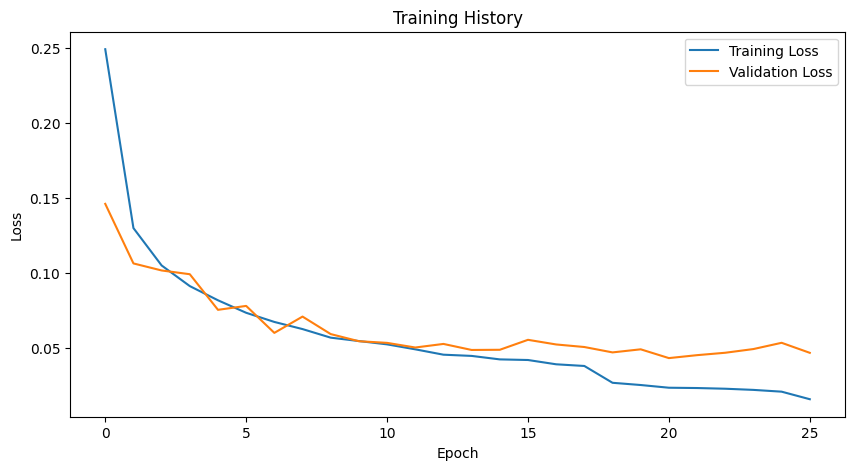

Testing: 100%|██████████| 685/685 [00:00<00:00, 706.45it/s]



Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     18118
           1       0.95      0.83      0.88       556
           2       0.98      0.96      0.97      1448
           3       0.84      0.83      0.83       162
           4       1.00      0.99      1.00      1608

    accuracy                           0.99     21892
   macro avg       0.95      0.92      0.94     21892
weighted avg       0.99      0.99      0.99     21892



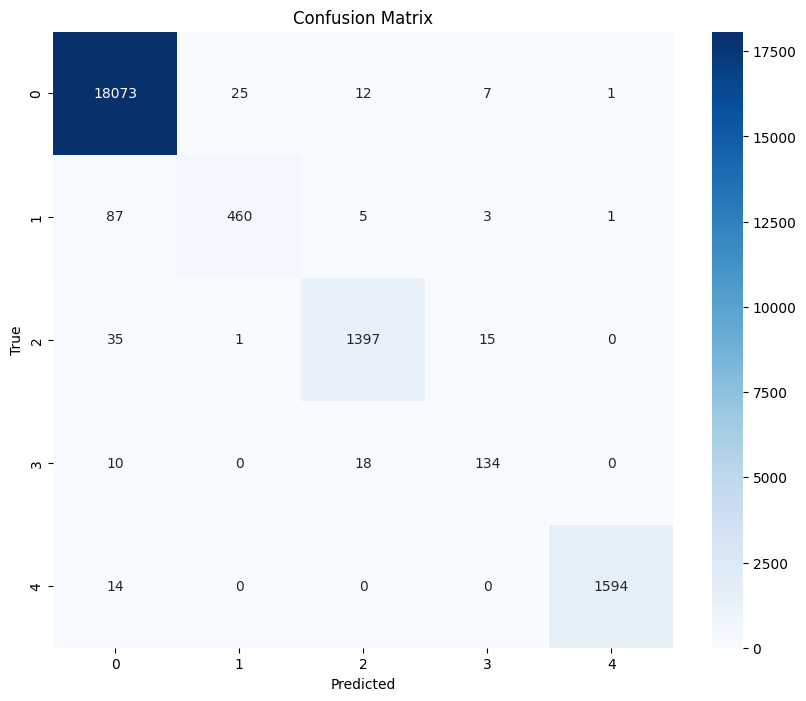

In [36]:
def train_and_evaluate():
    # Set random seeds for reproducibility
    torch.manual_seed(42)
    np.random.seed(42)
    
    # Set device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    # Create data loaders
    train_loader, val_loader, test_loader = create_data_loaders(
        X_train, X_val, X_test, y_train, y_val, y_test, batch_size=32
    )
    
    # Initialize model
    input_size = 1  # Single channel ECG
    hidden_size = 128
    num_layers = 2
    num_classes = len(np.unique(y_train))
    
    model = AttentionRNN(
        input_size=input_size,
        hidden_size=hidden_size,
        num_layers=num_layers,
        num_classes=num_classes
    ).to(device)
    
    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
    
    # Train the model
    num_epochs = 100
    best_val_loss = float('inf')
    train_losses = []
    val_losses = []
    patience = 5
    patience_counter = 0
    
    # Learning rate scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=3, verbose=True
    )
    
    print("Starting training...")
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        total_train_loss = 0
        
        for batch_X, batch_y in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}'):
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            
            optimizer.zero_grad()
            outputs, _ = model(batch_X)
            loss = criterion(outputs, batch_y)
            
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            total_train_loss += loss.item()
        
        # Validation phase
        model.eval()
        total_val_loss = 0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                outputs, _ = model(batch_X)
                loss = criterion(outputs, batch_y)
                total_val_loss += loss.item()
                
                _, predicted = torch.max(outputs.data, 1)
                total += batch_y.size(0)
                correct += (predicted == batch_y).sum().item()
        
        # Calculate average losses and accuracy
        avg_train_loss = total_train_loss / len(train_loader)
        avg_val_loss = total_val_loss / len(val_loader)
        val_accuracy = 100 * correct / total
        
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        
        # Step the scheduler
        scheduler.step(avg_val_loss)
        
        print(f'Epoch [{epoch+1}/{num_epochs}]')
        print(f'Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')
        print(f'Validation Accuracy: {val_accuracy:.2f}%')
        
        # Early stopping check
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f'Early stopping triggered after {epoch+1} epochs')
                break
    
    # Plot training history
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Training History')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    # Evaluate on test set
    model.eval()
    test_predictions = []
    test_labels = []
    
    with torch.no_grad():
        for batch_X, batch_y in tqdm(test_loader, desc='Testing'):
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs, _ = model(batch_X)
            _, predicted = torch.max(outputs.data, 1)
            
            test_predictions.extend(predicted.cpu().numpy())
            test_labels.extend(batch_y.cpu().numpy())
    
    # Print classification report
    print("\nClassification Report:")
    print(classification_report(test_labels, test_predictions))
    
    # Plot confusion matrix
    cm = confusion_matrix(test_labels, test_predictions)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    
    # Save the final model
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_losses': train_losses,
        'val_losses': val_losses,
    }, 'ecg_model_final.pth')

if __name__ == "__main__":
    train_and_evaluate()

In [37]:
# Initialize model
input_size = 1  # Single channel ECG
hidden_size = 128
num_layers = 2
num_classes = 5  

# Create model instance
model = AttentionRNN(
    input_size=input_size,
    hidden_size=hidden_size,
    num_layers=num_layers,
    num_classes=num_classes
).to(device)

# Create test loader if not already created
test_dataset = ECGDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=32)

# Load the saved model weights
try:
    checkpoint = torch.load('ecg_model_final.pth')
    model.load_state_dict(checkpoint['model_state_dict'])
    print("Model loaded successfully!")
except Exception as e:
    print(f"Error loading model: {e}")
    print("Make sure the model file 'ecg_model_final.pth' exists in the current directory")


Model loaded successfully!


In [38]:
def get_attention_rnn_accuracy(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    
    print("\nEvaluating AttentionRNN model...")
    
    with torch.no_grad():
        for batch_X, batch_y in tqdm(test_loader, desc='Testing'):
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs, _ = model(batch_X)
            _, predicted = torch.max(outputs.data, 1)
            
            total += batch_y.size(0)
            correct += (predicted == batch_y).sum().item()
    
    accuracy = 100 * correct / total
    
    # Print results
    print(f"\nTest Results:")
    print(f"Total samples: {total}")
    print(f"Correct predictions: {correct}")
    print(f"Test Accuracy: {accuracy:.2f}%")
    
    return accuracy

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
test_accuracy = get_attention_rnn_accuracy(model, test_loader, device)


Evaluating AttentionRNN model...


Testing: 100%|██████████| 685/685 [00:00<00:00, 708.29it/s]


Test Results:
Total samples: 21892
Correct predictions: 21658
Test Accuracy: 98.93%



Evaluating AttentionRNN model...


Testing: 100%|██████████| 685/685 [00:00<00:00, 690.35it/s]



Test Results:
Total samples: 21892
Correct predictions: 21658
Test Accuracy: 98.93%

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     18118
           1       0.95      0.83      0.88       556
           2       0.98      0.96      0.97      1448
           3       0.84      0.83      0.83       162
           4       1.00      0.99      1.00      1608

    accuracy                           0.99     21892
   macro avg       0.95      0.92      0.94     21892
weighted avg       0.99      0.99      0.99     21892



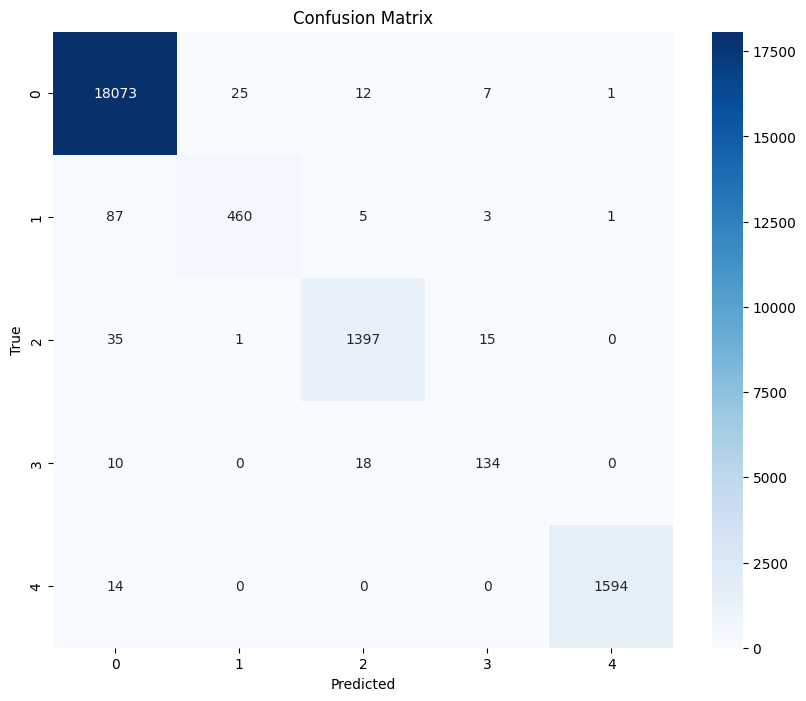

In [39]:
def evaluate_attention_rnn(model, test_loader, device):
    model.eval()
    all_predictions = []
    all_labels = []
    correct = 0
    total = 0
    
    print("\nEvaluating AttentionRNN model...")
    
    with torch.no_grad():
        for batch_X, batch_y in tqdm(test_loader, desc='Testing'):
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs, _ = model(batch_X)
            _, predicted = torch.max(outputs.data, 1)
            
            total += batch_y.size(0)
            correct += (predicted == batch_y).sum().item()
            
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(batch_y.cpu().numpy())
    
    accuracy = 100 * correct / total
    
    # Print results
    print(f"\nTest Results:")
    print(f"Total samples: {total}")
    print(f"Correct predictions: {correct}")
    print(f"Test Accuracy: {accuracy:.2f}%")
    
    # Print classification report
    print("\nClassification Report:")
    print(classification_report(all_labels, all_predictions))
    
    # Plot confusion matrix
    cm = confusion_matrix(all_labels, all_predictions)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    
    return accuracy

test_accuracy = evaluate_attention_rnn(model, test_loader, device)

# Hybrid CNN + RNN

In [41]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, dropout_rate=0.3):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.dropout = nn.Dropout(dropout_rate)
        self.skip = nn.Conv1d(in_channels, out_channels, kernel_size=1) if in_channels != out_channels else nn.Identity()

    def forward(self, x):
        residual = self.skip(x)
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.dropout(out)
        out = self.bn2(self.conv2(out))
        out = F.relu(out + residual)
        return out

class HybridModel(nn.Module):
    def __init__(self, input_channels=1, sequence_length=187, hidden_size=128, 
                 num_layers=2, num_classes=5, dropout=0.3, input_size=1):
        super(HybridModel, self).__init__()
        
        # CNN layers
        self.conv_initial = nn.Sequential(
            nn.Conv1d(input_channels, 32, kernel_size=15, padding=7),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.MaxPool1d(2)
        )
        
        self.res1 = ResidualBlock(32, 64)
        self.res2 = ResidualBlock(64, 128)
        self.res3 = ResidualBlock(128, 256)
        
        # Calculate feature size for LSTM
        self._feature_size = self._get_conv_output_size(input_channels, sequence_length)
        
        # LSTM layers
        self.lstm = nn.LSTM(
            input_size=self._feature_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0,
            bidirectional=True
        )
        
        # Attention mechanism
        self.attention = nn.Sequential(
            nn.Linear(hidden_size * 2, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, 1)
        )
        
        # Output layers
        self.norm = nn.LayerNorm(hidden_size * 2)
        self.fc1 = nn.Linear(hidden_size * 2, hidden_size)
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def _get_conv_output_size(self, channels, length):
        x = torch.randn(1, channels, length)
        x = self.conv_initial(x)
        x = self.res1(x)
        x = self.res2(x)
        x = self.res3(x)
        return x.shape[1]

    def forward(self, x):
        # Reshape input: [batch_size, sequence_length, channels] -> [batch_size, channels, sequence_length]
        x = x.transpose(1, 2)
        
        # CNN
        x = self.conv_initial(x)
        x = self.res1(x)
        x = self.res2(x)
        x = self.res3(x)
        
        # Prepare for LSTM: [batch_size, channels, sequence_length] -> [batch_size, sequence_length, channels]
        x = x.permute(0, 2, 1)
        
        # LSTM
        lstm_out, _ = self.lstm(x)
        
        # Normalization
        lstm_out = self.norm(lstm_out)
        
        # Attention
        attn_weights = self.attention(lstm_out)
        attn_weights = F.softmax(attn_weights, dim=1)
        context = torch.sum(attn_weights * lstm_out, dim=1)
        
        # Classification
        out = F.relu(self.fc1(context))
        out = self.dropout(out)
        out = self.fc2(out)
        
        return out, attn_weights

In [42]:
model = HybridModel()
input_data = torch.randn(32, 187, 1)  # Example input for batch size of 32
output, lstm_out = model(input_data)

In [43]:
# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Create data loaders
train_loader, val_loader, test_loader = create_data_loaders(
    X_train, X_val, X_test, y_train, y_val, y_test, batch_size=32
)

# Initialize model
input_size = 1  # Single channel ECG
hidden_size = 128
num_layers = 2
num_classes = len(np.unique(y_train))

Using device: cuda


In [44]:
# Create model instance
model = HybridModel(
    input_size=input_size,
    hidden_size=hidden_size,
    num_layers=num_layers,
    num_classes=num_classes
).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

# Train the model
num_epochs = 100
best_val_loss = float('inf')
train_losses = []
val_losses = []
patience = 5
patience_counter = 0

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=3, verbose=True
)

In [45]:
print("Starting training...")
for epoch in range(num_epochs):
    # Training phase
    model.train()
    total_train_loss = 0
    
    for batch_X, batch_y in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}'):
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        
        optimizer.zero_grad()
        outputs, _ = model(batch_X)
        loss = criterion(outputs, batch_y)
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        total_train_loss += loss.item()
    
    # Validation phase
    model.eval()
    total_val_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs, _ = model(batch_X)
            loss = criterion(outputs, batch_y)
            total_val_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            total += batch_y.size(0)
            correct += (predicted == batch_y).sum().item()
    
    # Calculate average losses and accuracy
    avg_train_loss = total_train_loss / len(train_loader)
    avg_val_loss = total_val_loss / len(val_loader)
    val_accuracy = 100 * correct / total
    
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    
    # Step the scheduler
    scheduler.step(avg_val_loss)
    
    print(f'Epoch [{epoch+1}/{num_epochs}]')
    print(f'Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')
    print(f'Validation Accuracy: {val_accuracy:.2f}%')
    
    # Early stopping check
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f'Early stopping triggered after {epoch+1} epochs')
            break



Starting training...


Epoch 1/100: 100%|██████████| 2463/2463 [00:13<00:00, 180.45it/s]


Epoch [1/100]
Train Loss: 0.2850, Val Loss: 0.2142
Validation Accuracy: 94.07%


Epoch 2/100: 100%|██████████| 2463/2463 [00:13<00:00, 181.04it/s]


Epoch [2/100]
Train Loss: 0.1630, Val Loss: 0.1476
Validation Accuracy: 96.27%


Epoch 3/100: 100%|██████████| 2463/2463 [00:13<00:00, 180.52it/s]


Epoch [3/100]
Train Loss: 0.1277, Val Loss: 0.1091
Validation Accuracy: 96.95%


Epoch 4/100: 100%|██████████| 2463/2463 [00:13<00:00, 180.99it/s]


Epoch [4/100]
Train Loss: 0.1118, Val Loss: 0.0951
Validation Accuracy: 97.46%


Epoch 5/100: 100%|██████████| 2463/2463 [00:13<00:00, 181.21it/s]


Epoch [5/100]
Train Loss: 0.1002, Val Loss: 0.0868
Validation Accuracy: 97.65%


Epoch 6/100: 100%|██████████| 2463/2463 [00:13<00:00, 180.33it/s]


Epoch [6/100]
Train Loss: 0.0892, Val Loss: 0.0910
Validation Accuracy: 97.65%


Epoch 7/100: 100%|██████████| 2463/2463 [00:13<00:00, 180.82it/s]


Epoch [7/100]
Train Loss: 0.0835, Val Loss: 0.0870
Validation Accuracy: 97.82%


Epoch 8/100: 100%|██████████| 2463/2463 [00:13<00:00, 180.50it/s]


Epoch [8/100]
Train Loss: 0.0794, Val Loss: 0.0759
Validation Accuracy: 98.00%


Epoch 9/100: 100%|██████████| 2463/2463 [00:13<00:00, 180.76it/s]


Epoch [9/100]
Train Loss: 0.0728, Val Loss: 0.0643
Validation Accuracy: 98.14%


Epoch 10/100: 100%|██████████| 2463/2463 [00:13<00:00, 180.22it/s]


Epoch [10/100]
Train Loss: 0.0675, Val Loss: 0.0637
Validation Accuracy: 98.12%


Epoch 11/100: 100%|██████████| 2463/2463 [00:13<00:00, 180.78it/s]


Epoch [11/100]
Train Loss: 0.0649, Val Loss: 0.0690
Validation Accuracy: 98.21%


Epoch 12/100: 100%|██████████| 2463/2463 [00:13<00:00, 180.52it/s]


Epoch [12/100]
Train Loss: 0.0618, Val Loss: 0.0661
Validation Accuracy: 98.09%


Epoch 13/100: 100%|██████████| 2463/2463 [00:13<00:00, 180.83it/s]


Epoch [13/100]
Train Loss: 0.0585, Val Loss: 0.0683
Validation Accuracy: 98.14%


Epoch 14/100: 100%|██████████| 2463/2463 [00:13<00:00, 180.91it/s]


Epoch [14/100]
Train Loss: 0.0585, Val Loss: 0.0612
Validation Accuracy: 98.38%


Epoch 15/100: 100%|██████████| 2463/2463 [00:13<00:00, 180.82it/s]


Epoch [15/100]
Train Loss: 0.0567, Val Loss: 0.0604
Validation Accuracy: 98.22%


Epoch 16/100: 100%|██████████| 2463/2463 [00:13<00:00, 179.78it/s]


Epoch [16/100]
Train Loss: 0.0530, Val Loss: 0.0672
Validation Accuracy: 98.28%


Epoch 17/100: 100%|██████████| 2463/2463 [00:13<00:00, 177.89it/s]


Epoch [17/100]
Train Loss: 0.0523, Val Loss: 0.0566
Validation Accuracy: 98.45%


Epoch 18/100: 100%|██████████| 2463/2463 [00:13<00:00, 178.99it/s]


Epoch [18/100]
Train Loss: 0.0507, Val Loss: 0.0652
Validation Accuracy: 98.30%


Epoch 19/100: 100%|██████████| 2463/2463 [00:13<00:00, 178.95it/s]


Epoch [19/100]
Train Loss: 0.0481, Val Loss: 0.0747
Validation Accuracy: 98.14%


Epoch 20/100: 100%|██████████| 2463/2463 [00:13<00:00, 178.58it/s]


Epoch [20/100]
Train Loss: 0.0493, Val Loss: 0.0576
Validation Accuracy: 98.39%


Epoch 21/100: 100%|██████████| 2463/2463 [00:13<00:00, 178.17it/s]


Epoch 00021: reducing learning rate of group 0 to 5.0000e-04.
Epoch [21/100]
Train Loss: 0.0477, Val Loss: 0.0599
Validation Accuracy: 98.45%


Epoch 22/100: 100%|██████████| 2463/2463 [00:13<00:00, 177.88it/s]


Epoch [22/100]
Train Loss: 0.0346, Val Loss: 0.0488
Validation Accuracy: 98.68%


Epoch 23/100: 100%|██████████| 2463/2463 [00:13<00:00, 178.31it/s]


Epoch [23/100]
Train Loss: 0.0302, Val Loss: 0.0561
Validation Accuracy: 98.60%


Epoch 24/100: 100%|██████████| 2463/2463 [00:13<00:00, 180.15it/s]


Epoch [24/100]
Train Loss: 0.0289, Val Loss: 0.0498
Validation Accuracy: 98.85%


Epoch 25/100: 100%|██████████| 2463/2463 [00:13<00:00, 178.61it/s]


Epoch [25/100]
Train Loss: 0.0280, Val Loss: 0.0583
Validation Accuracy: 98.72%


Epoch 26/100: 100%|██████████| 2463/2463 [00:13<00:00, 180.54it/s]


Epoch 00026: reducing learning rate of group 0 to 2.5000e-04.
Epoch [26/100]
Train Loss: 0.0270, Val Loss: 0.0576
Validation Accuracy: 98.65%


Epoch 27/100: 100%|██████████| 2463/2463 [00:13<00:00, 180.15it/s]


Epoch [27/100]
Train Loss: 0.0204, Val Loss: 0.0538
Validation Accuracy: 98.84%
Early stopping triggered after 27 epochs


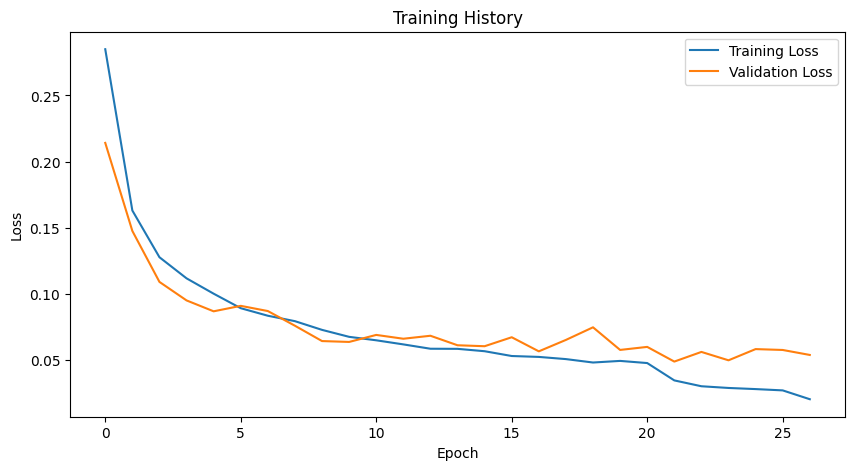

In [46]:
# Plot training history
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training History')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [47]:
# Evaluate on test set
model.eval()
test_predictions = []
test_labels = []

with torch.no_grad():
    for batch_X, batch_y in tqdm(test_loader, desc='Testing'):
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        outputs, _ = model(batch_X)
        _, predicted = torch.max(outputs.data, 1)
        
        test_predictions.extend(predicted.cpu().numpy())
        test_labels.extend(batch_y.cpu().numpy())
        
def calculate_accuracy(predictions, labels):
    # Convert lists to numpy arrays if they aren't already
    predictions = np.array(predictions)
    labels = np.array(labels)
    
    # Calculate number of correct predictions
    correct = np.sum(predictions == labels)
    
    # Calculate accuracy
    accuracy = correct / len(labels) * 100
    
    return accuracy

# Calculate accuracy
accuracy = calculate_accuracy(test_predictions, test_labels)
print(f"Accuracy: {accuracy:.2f}%")

Testing: 100%|██████████| 685/685 [00:01<00:00, 459.30it/s]

Accuracy: 98.74%


In [48]:
# Print classification report
print("\nClassification Report:")
print(classification_report(test_labels, test_predictions))


Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     18118
           1       0.89      0.82      0.85       556
           2       0.98      0.96      0.97      1448
           3       0.87      0.76      0.81       162
           4       1.00      0.99      0.99      1608

    accuracy                           0.99     21892
   macro avg       0.94      0.91      0.92     21892
weighted avg       0.99      0.99      0.99     21892



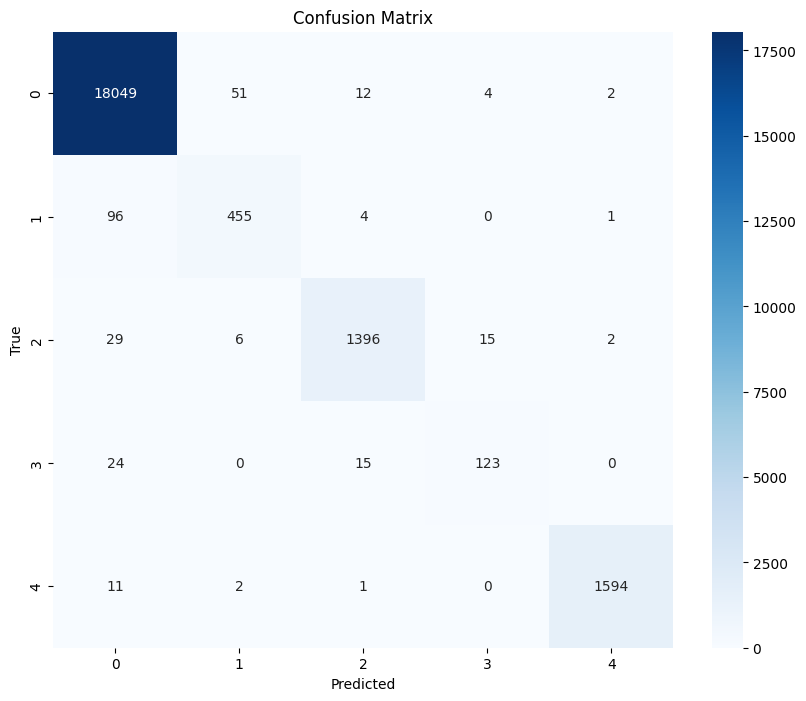

In [49]:
# Plot confusion matrix
cm = confusion_matrix(test_labels, test_predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [50]:
# Save the final model
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_losses': train_losses,
    'val_losses': val_losses,
}, 'ecg_hybrid_model_final.pth')


# Data Augmentation : Gaussian Noise Injection and Time Warping

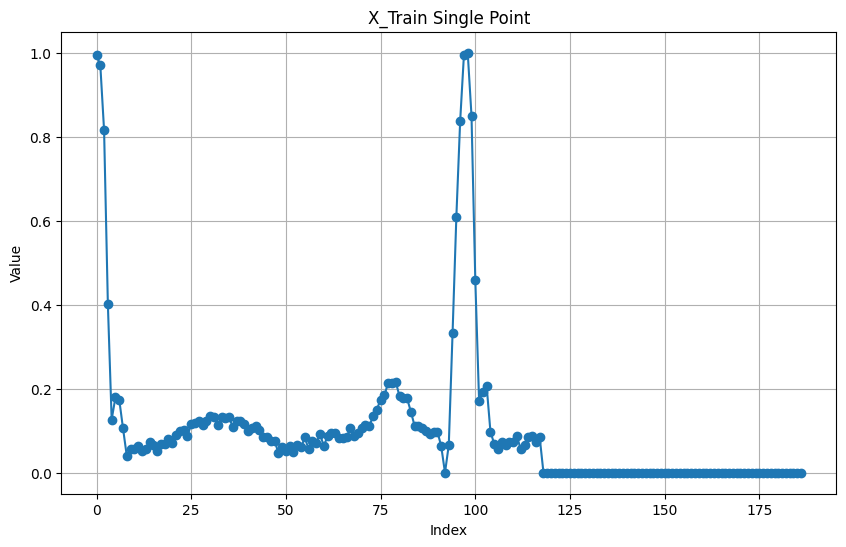

In [52]:
import numpy as np
import matplotlib.pyplot as plt

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(X_train[0], marker='o')
plt.title('X_Train Single Point')
plt.xlabel('Index')
plt.ylabel('Value')
plt.grid(True)
plt.show()


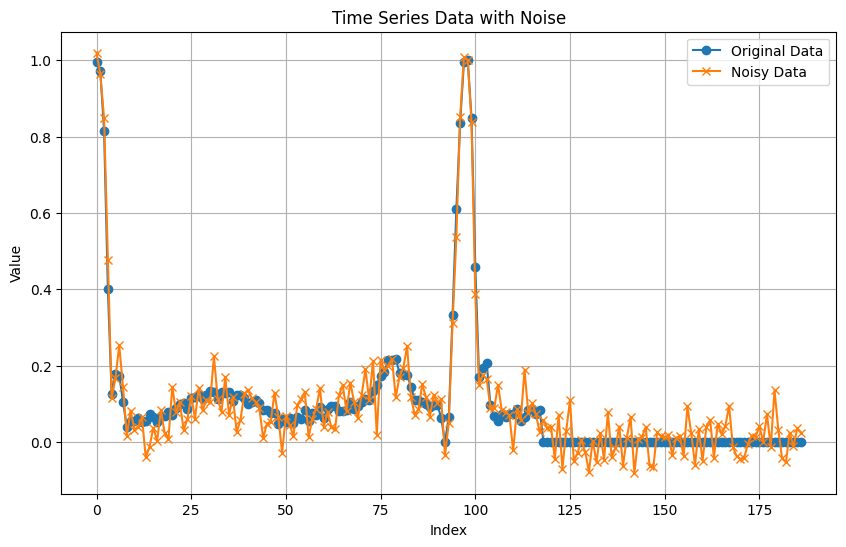

In [53]:
# Function to add Gaussian noise
def add_gaussian_noise(data, noise_level=0.1):
    noise = np.random.normal(0, noise_level, data.shape)
    noisy_data = data + noise
    return noisy_data

# Add noise to the original data
noise_level = 0.05  # Adjust the noise level as needed
noisy_data = add_gaussian_noise(X_train[0], noise_level)

# Plotting the original and noisy data
plt.figure(figsize=(10, 6))
plt.plot(X_train[0], label='Original Data', marker='o')
plt.plot(noisy_data, label='Noisy Data', marker='x')
plt.title('Time Series Data with Noise')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

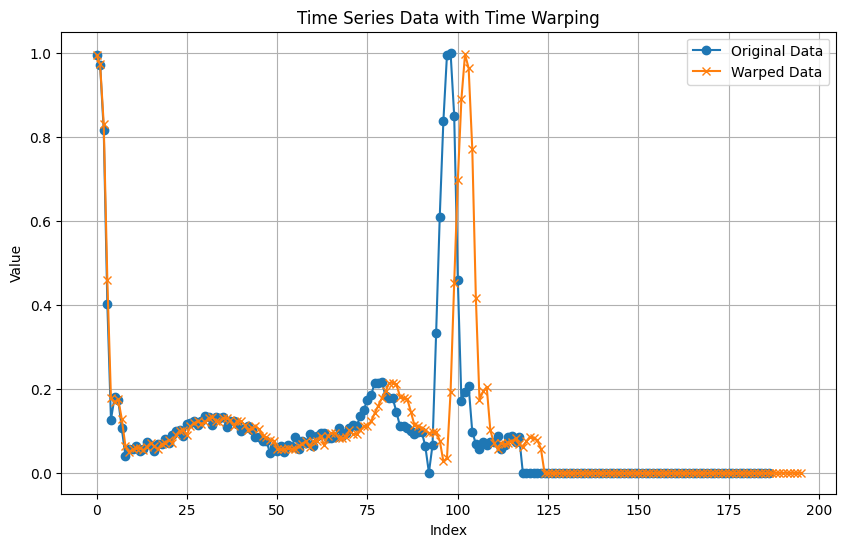

In [54]:
data = X_train[0].flatten()  # Flatten to 1D for easier processing

# Function to perform time warping
def time_warp(data, warp_factor=0.2):
    original_indices = np.arange(len(data))
    
    # Create a warped index, ensuring the number of points is an integer
    num_warped_points = int(len(data) * (1 + warp_factor))
    warped_indices = np.linspace(0, len(data) - 1, num=num_warped_points)
    
    # Interpolate the data to get the warped time series
    warped_data = np.interp(warped_indices, original_indices, data)
    
    return warped_data

# Perform time warping
warp_factor = 0.05  # Adjust the warp factor as needed
warped_data = time_warp(data, warp_factor)

# Plotting the original and warped data
plt.figure(figsize=(10, 6))
plt.plot(data, label='Original Data', marker='o')
plt.plot(warped_data, label='Warped Data', marker='x')
plt.title('Time Series Data with Time Warping')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

In [55]:
# Augmenting the Training Dataset 
def add_random_gaussian_noise(data, noise_min=0.000, noise_max=0.025):
    # Generate a random noise level between noise_min and noise_max
    noise_level = np.random.uniform(noise_min, noise_max)
    
    # Create Gaussian noise
    noise = np.random.normal(0, noise_level, data.shape)
    
    # Inject noise into the original data
    noisy_data = data + noise
    return noisy_data


In [56]:
# Example usage with a large time series dataset
# Generating synthetic time series data
np.random.seed(0)  # For reproducibility

# Inject noise into the synthetic data
X_train_noisy = add_random_gaussian_noise(X_train)

In [195]:
import numpy as np
from scipy.interpolate import CubicSpline
from scipy.signal import find_peaks

def enhanced_time_warp(data, warp_min=0.8, warp_max=1.2, max_points=187, preserve_peaks=True):
    """
    Enhanced time warping for ECG data with peak preservation and non-linear warping.
    Handles edge cases for very small segments.
    
    Args:
        data: Input ECG data of shape (batch_size, sequence_length, channels)
        warp_min: Minimum warping factor (0.8 = 20% compression)
        warp_max: Maximum warping factor (1.2 = 20% expansion)
        max_points: Maximum sequence length
        preserve_peaks: Whether to preserve QRS complex locations
    
    Returns:
        Warped ECG data of same shape as input
    """
    data = np.array(data)
    warped_data = np.zeros_like(data)
    
    for i in range(len(data)):
        sequence = data[i, :, 0]
        
        # Find R-peaks for QRS complex preservation
        peaks, _ = find_peaks(sequence, distance=20, prominence=0.1)
        
        if preserve_peaks and len(peaks) > 1:  # Ensure we have at least 2 peaks
            # Generate non-linear warping between peaks
            warped_sequence = []
            prev_peak = 0
            
            for peak in peaks:
                # Get segment between previous point and current peak
                segment = sequence[prev_peak:peak+1]  # Include the peak point
                
                # Skip very small segments
                if len(segment) < 2:
                    warped_sequence.extend(segment)
                    prev_peak = peak
                    continue
                
                # Generate random warping factor for each segment
                warp_factor = np.random.uniform(warp_min, warp_max)
                
                # Ensure minimum number of points after warping
                num_points = max(2, int(len(segment) * warp_factor))
                
                original_indices = np.arange(len(segment))
                warped_indices = np.linspace(0, len(segment) - 1, num_points)
                
                # Add controlled randomness to the warping
                if len(warped_indices) > 2:  # Only add noise if we have enough points
                    noise = np.random.normal(0, 0.05, len(warped_indices))
                    warped_indices += noise
                    warped_indices = np.clip(warped_indices, 0, len(segment) - 1)
                
                # Use cubic spline for smooth interpolation
                cs = CubicSpline(original_indices, segment)
                warped_segment = cs(warped_indices)
                
                # Don't include the peak point if it's not the last peak
                if peak != peaks[-1]:
                    warped_segment = warped_segment[:-1]
                    
                warped_sequence.extend(warped_segment)
                prev_peak = peak
            
            # Handle the last segment
            if prev_peak < len(sequence) - 1:
                last_segment = sequence[prev_peak:]
                if len(last_segment) >= 2:
                    warp_factor = np.random.uniform(warp_min, warp_max)
                    num_points = max(2, int(len(last_segment) * warp_factor))
                    original_indices = np.arange(len(last_segment))
                    warped_indices = np.linspace(0, len(last_segment) - 1, num_points)
                    cs = CubicSpline(original_indices, last_segment)
                    warped_last_segment = cs(warped_indices)
                    warped_sequence.extend(warped_last_segment)
                else:
                    warped_sequence.extend(last_segment)
                
            warped_sequence = np.array(warped_sequence)
            
        else:
            # If no peaks found or preserve_peaks=False, apply global warping
            warp_factor = np.random.uniform(warp_min, warp_max)
            num_warped_points = max(2, int(len(sequence) * warp_factor))
            
            original_indices = np.arange(len(sequence))
            warped_indices = np.linspace(0, len(sequence) - 1, num_warped_points)
            
            # Add controlled randomness to warping
            noise = np.random.normal(0, 0.05, len(warped_indices))
            warped_indices += noise
            warped_indices = np.clip(warped_indices, 0, len(sequence) - 1)
            
            cs = CubicSpline(original_indices, sequence)
            warped_sequence = cs(warped_indices)
        
        # Adjust sequence length to match max_points
        if len(warped_sequence) > max_points:
            start_idx = (len(warped_sequence) - max_points) // 2
            warped_sequence = warped_sequence[start_idx:start_idx + max_points]
        elif len(warped_sequence) < max_points:
            # Pad with edge values if sequence is too short
            pad_left = (max_points - len(warped_sequence)) // 2
            pad_right = max_points - len(warped_sequence) - pad_left
            warped_sequence = np.pad(warped_sequence, (pad_left, pad_right), mode='edge')
        
        warped_data[i, :, 0] = warped_sequence
    
    return warped_data

In [197]:
augmented_data = enhanced_time_warp(
    X_train_noisy,
    warp_min=0.8,  # 20% compression
    warp_max=1.2,  # 20% expansion
    preserve_peaks=True  # Set to False if you don't want to preserve QRS complexes
)

In [198]:
print(X_train_noisy.shape)
print(augmented_data.shape)

(78798, 187, 1)
(78798, 187, 1)


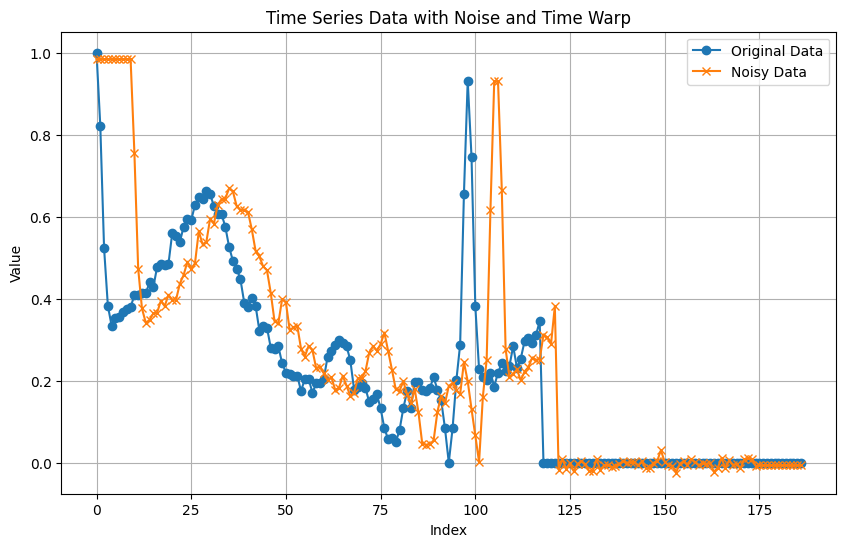

In [199]:
# Plotting the original and noisy data
plt.figure(figsize=(10, 6))
plt.plot(X_train[1], label='Original Data', marker='o')
plt.plot(augmented_data[1], label='Noisy Data', marker='x')
plt.title('Time Series Data with Noise and Time Warp')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

# Augmented Data on GRU with Attention

Using device: cuda
Starting training...


Epoch 1/100: 100%|██████████| 2463/2463 [00:07<00:00, 321.05it/s]


Epoch [1/100]
Train Loss: 0.2475, Val Loss: 0.1420
Validation Accuracy: 95.87%


Epoch 2/100: 100%|██████████| 2463/2463 [00:07<00:00, 315.07it/s]


Epoch [2/100]
Train Loss: 0.1197, Val Loss: 0.1037
Validation Accuracy: 97.37%


Epoch 3/100: 100%|██████████| 2463/2463 [00:07<00:00, 312.95it/s]


Epoch [3/100]
Train Loss: 0.0960, Val Loss: 0.0949
Validation Accuracy: 97.48%


Epoch 4/100: 100%|██████████| 2463/2463 [00:07<00:00, 315.68it/s]


Epoch [4/100]
Train Loss: 0.0821, Val Loss: 0.0806
Validation Accuracy: 97.84%


Epoch 5/100: 100%|██████████| 2463/2463 [00:07<00:00, 320.28it/s]


Epoch [5/100]
Train Loss: 0.0738, Val Loss: 0.0635
Validation Accuracy: 98.29%


Epoch 6/100: 100%|██████████| 2463/2463 [00:07<00:00, 320.91it/s]


Epoch [6/100]
Train Loss: 0.0679, Val Loss: 0.0647
Validation Accuracy: 98.25%


Epoch 7/100: 100%|██████████| 2463/2463 [00:07<00:00, 321.85it/s]


Epoch [7/100]
Train Loss: 0.0616, Val Loss: 0.0563
Validation Accuracy: 98.38%


Epoch 8/100: 100%|██████████| 2463/2463 [00:07<00:00, 321.85it/s]


Epoch [8/100]
Train Loss: 0.0572, Val Loss: 0.0627
Validation Accuracy: 98.25%


Epoch 9/100: 100%|██████████| 2463/2463 [00:07<00:00, 319.73it/s]


Epoch [9/100]
Train Loss: 0.0535, Val Loss: 0.0617
Validation Accuracy: 98.24%


Epoch 10/100: 100%|██████████| 2463/2463 [00:07<00:00, 320.93it/s]


Epoch [10/100]
Train Loss: 0.0521, Val Loss: 0.0613
Validation Accuracy: 98.23%


Epoch 11/100: 100%|██████████| 2463/2463 [00:07<00:00, 320.99it/s]


Epoch [11/100]
Train Loss: 0.0476, Val Loss: 0.0503
Validation Accuracy: 98.55%


Epoch 12/100: 100%|██████████| 2463/2463 [00:07<00:00, 321.47it/s]


Epoch [12/100]
Train Loss: 0.0463, Val Loss: 0.0560
Validation Accuracy: 98.39%


Epoch 13/100: 100%|██████████| 2463/2463 [00:07<00:00, 320.91it/s]


Epoch [13/100]
Train Loss: 0.0438, Val Loss: 0.0659
Validation Accuracy: 98.38%


Epoch 14/100: 100%|██████████| 2463/2463 [00:07<00:00, 320.93it/s]


Epoch [14/100]
Train Loss: 0.0431, Val Loss: 0.0546
Validation Accuracy: 98.68%


Epoch 15/100: 100%|██████████| 2463/2463 [00:07<00:00, 320.21it/s]


Epoch 00015: reducing learning rate of group 0 to 5.0000e-04.
Epoch [15/100]
Train Loss: 0.0416, Val Loss: 0.0589
Validation Accuracy: 98.49%


Epoch 16/100: 100%|██████████| 2463/2463 [00:07<00:00, 321.73it/s]


Epoch [16/100]
Train Loss: 0.0284, Val Loss: 0.0491
Validation Accuracy: 98.78%


Epoch 17/100: 100%|██████████| 2463/2463 [00:07<00:00, 318.55it/s]


Epoch [17/100]
Train Loss: 0.0262, Val Loss: 0.0522
Validation Accuracy: 98.81%


Epoch 18/100: 100%|██████████| 2463/2463 [00:07<00:00, 321.77it/s]


Epoch [18/100]
Train Loss: 0.0251, Val Loss: 0.0537
Validation Accuracy: 98.74%


Epoch 19/100: 100%|██████████| 2463/2463 [00:07<00:00, 320.19it/s]


Epoch [19/100]
Train Loss: 0.0233, Val Loss: 0.0536
Validation Accuracy: 98.87%


Epoch 20/100: 100%|██████████| 2463/2463 [00:07<00:00, 321.43it/s]


Epoch 00020: reducing learning rate of group 0 to 2.5000e-04.
Epoch [20/100]
Train Loss: 0.0226, Val Loss: 0.0567
Validation Accuracy: 98.70%


Epoch 21/100: 100%|██████████| 2463/2463 [00:07<00:00, 320.40it/s]


Epoch [21/100]
Train Loss: 0.0163, Val Loss: 0.0520
Validation Accuracy: 98.88%


Epoch 22/100: 100%|██████████| 2463/2463 [00:07<00:00, 322.70it/s]


Epoch [22/100]
Train Loss: 0.0149, Val Loss: 0.0581
Validation Accuracy: 98.80%


Epoch 23/100: 100%|██████████| 2463/2463 [00:07<00:00, 320.28it/s]


Epoch [23/100]
Train Loss: 0.0146, Val Loss: 0.0562
Validation Accuracy: 98.92%


Epoch 24/100: 100%|██████████| 2463/2463 [00:07<00:00, 321.22it/s]


Epoch 00024: reducing learning rate of group 0 to 1.2500e-04.
Epoch [24/100]
Train Loss: 0.0138, Val Loss: 0.0575
Validation Accuracy: 98.86%


Epoch 25/100: 100%|██████████| 2463/2463 [00:07<00:00, 319.11it/s]


Epoch [25/100]
Train Loss: 0.0098, Val Loss: 0.0601
Validation Accuracy: 98.93%


Epoch 26/100: 100%|██████████| 2463/2463 [00:07<00:00, 320.65it/s]


Epoch [26/100]
Train Loss: 0.0098, Val Loss: 0.0605
Validation Accuracy: 98.89%


Epoch 27/100: 100%|██████████| 2463/2463 [00:07<00:00, 320.00it/s]


Epoch [27/100]
Train Loss: 0.0091, Val Loss: 0.0653
Validation Accuracy: 98.80%


Epoch 28/100: 100%|██████████| 2463/2463 [00:07<00:00, 320.51it/s]


Epoch 00028: reducing learning rate of group 0 to 6.2500e-05.
Epoch [28/100]
Train Loss: 0.0084, Val Loss: 0.0647
Validation Accuracy: 98.90%


Epoch 29/100: 100%|██████████| 2463/2463 [00:07<00:00, 319.73it/s]


Epoch [29/100]
Train Loss: 0.0070, Val Loss: 0.0642
Validation Accuracy: 98.87%


Epoch 30/100: 100%|██████████| 2463/2463 [00:07<00:00, 320.47it/s]


Epoch [30/100]
Train Loss: 0.0069, Val Loss: 0.0625
Validation Accuracy: 98.85%


Epoch 31/100: 100%|██████████| 2463/2463 [00:07<00:00, 320.70it/s]


Epoch [31/100]
Train Loss: 0.0063, Val Loss: 0.0641
Validation Accuracy: 98.88%
Early stopping triggered after 31 epochs


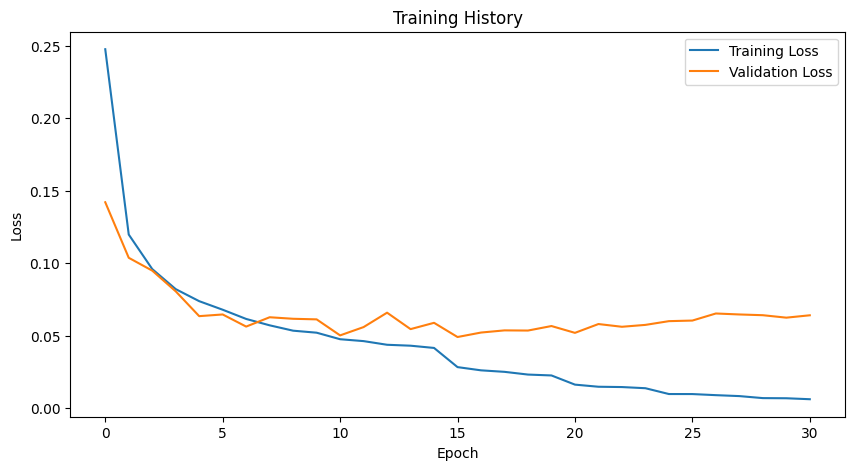

Testing: 100%|██████████| 685/685 [00:00<00:00, 709.39it/s]



Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     18118
           1       0.91      0.86      0.88       556
           2       0.97      0.97      0.97      1448
           3       0.84      0.82      0.83       162
           4       1.00      0.99      1.00      1608

    accuracy                           0.99     21892
   macro avg       0.94      0.93      0.93     21892
weighted avg       0.99      0.99      0.99     21892



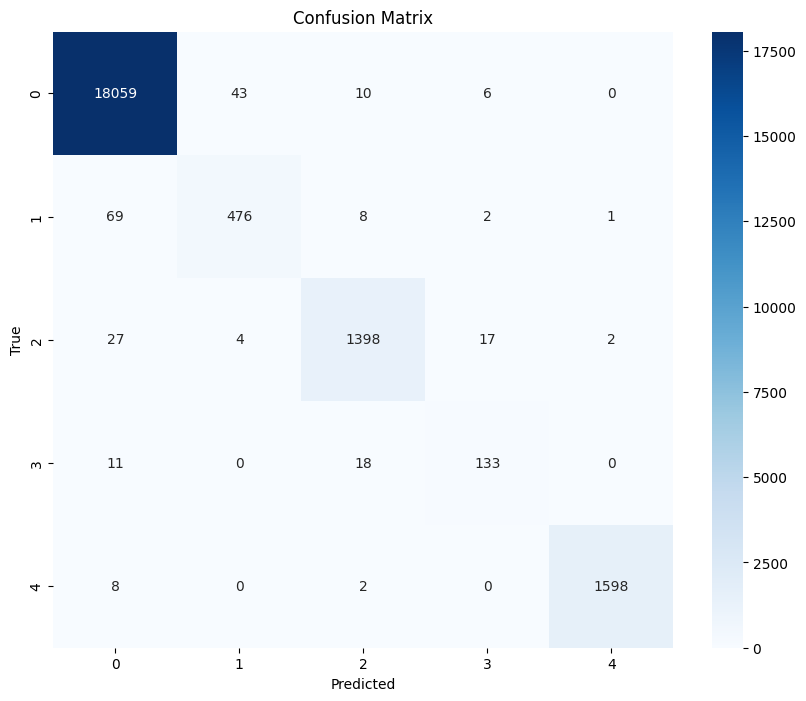

In [63]:
def train_and_evaluate_augmented(X_train_noisy):
    # Set random seeds for reproducibility
    torch.manual_seed(42)
    np.random.seed(42)
    
    # Set device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    # Create data loaders
    train_loader, val_loader, test_loader = create_data_loaders(
        X_train_noisy, X_val, X_test, y_train, y_val, y_test, batch_size=32
    )
    
    # Initialize model
    input_size = 1  # Single channel ECG
    hidden_size = 128
    num_layers = 2
    num_classes = len(np.unique(y_train))
    
    model = AttentionRNN(
        input_size=input_size,
        hidden_size=hidden_size,
        num_layers=num_layers,
        num_classes=num_classes
    ).to(device)
    
    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
    
    # Train the model
    num_epochs = 100
    best_val_loss = float('inf')
    train_losses = []
    val_losses = []
    patience = 15
    patience_counter = 0
    
    # Learning rate scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=3, verbose=True
    )
    
    print("Starting training...")
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        total_train_loss = 0
        
        for batch_X, batch_y in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}'):
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            
            optimizer.zero_grad()
            outputs, _ = model(batch_X)
            loss = criterion(outputs, batch_y)
            
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            total_train_loss += loss.item()
        
        # Validation phase
        model.eval()
        total_val_loss = 0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                outputs, _ = model(batch_X)
                loss = criterion(outputs, batch_y)
                total_val_loss += loss.item()
                
                _, predicted = torch.max(outputs.data, 1)
                total += batch_y.size(0)
                correct += (predicted == batch_y).sum().item()
        
        # Calculate average losses and accuracy
        avg_train_loss = total_train_loss / len(train_loader)
        avg_val_loss = total_val_loss / len(val_loader)
        val_accuracy = 100 * correct / total
        
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        
        # Step the scheduler
        scheduler.step(avg_val_loss)
        
        print(f'Epoch [{epoch+1}/{num_epochs}]')
        print(f'Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')
        print(f'Validation Accuracy: {val_accuracy:.2f}%')
        
        # Early stopping check
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f'Early stopping triggered after {epoch+1} epochs')
                break
    
    # Plot training history
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Training History')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    # Evaluate on test set
    model.eval()
    test_predictions = []
    test_labels = []
    
    with torch.no_grad():
        for batch_X, batch_y in tqdm(test_loader, desc='Testing'):
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs, _ = model(batch_X)
            _, predicted = torch.max(outputs.data, 1)
            
            test_predictions.extend(predicted.cpu().numpy())
            test_labels.extend(batch_y.cpu().numpy())
    
    # Print classification report
    print("\nClassification Report:")
    print(classification_report(test_labels, test_predictions))
    
    # Plot confusion matrix
    cm = confusion_matrix(test_labels, test_predictions)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    
    # Save the final model
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_losses': train_losses,
        'val_losses': val_losses,
    },  'ecg_model_final_augmented.pth')

if __name__ == "__main__":
    train_and_evaluate_augmented(X_train_noisy)

In [64]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Initialize model
input_size = 1  # Single channel ECG
hidden_size = 128
num_layers = 2
num_classes = 5  

# Create model instance
model = AttentionRNN(
    input_size=input_size,
    hidden_size=hidden_size,
    num_layers=num_layers,
    num_classes=num_classes
).to(device)

# Create test loader if not already created
test_dataset = ECGDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=32)

# Load the saved model weights
try:
    checkpoint = torch.load('ecg_model_final_augmented.pth')
    model.load_state_dict(checkpoint['model_state_dict'])
    print("Model loaded successfully!")
except Exception as e:
    print(f"Error loading model: {e}")
    print("Make sure the model file 'ecg_model_final.pth' exists in the current directory")


Using device: cuda
Model loaded successfully!



Evaluating AttentionRNN model...


Testing: 100%|██████████| 685/685 [00:00<00:00, 688.95it/s]



Test Results:
Total samples: 21892
Correct predictions: 21664
Test Accuracy: 98.96%

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     18118
           1       0.91      0.86      0.88       556
           2       0.97      0.97      0.97      1448
           3       0.84      0.82      0.83       162
           4       1.00      0.99      1.00      1608

    accuracy                           0.99     21892
   macro avg       0.94      0.93      0.93     21892
weighted avg       0.99      0.99      0.99     21892



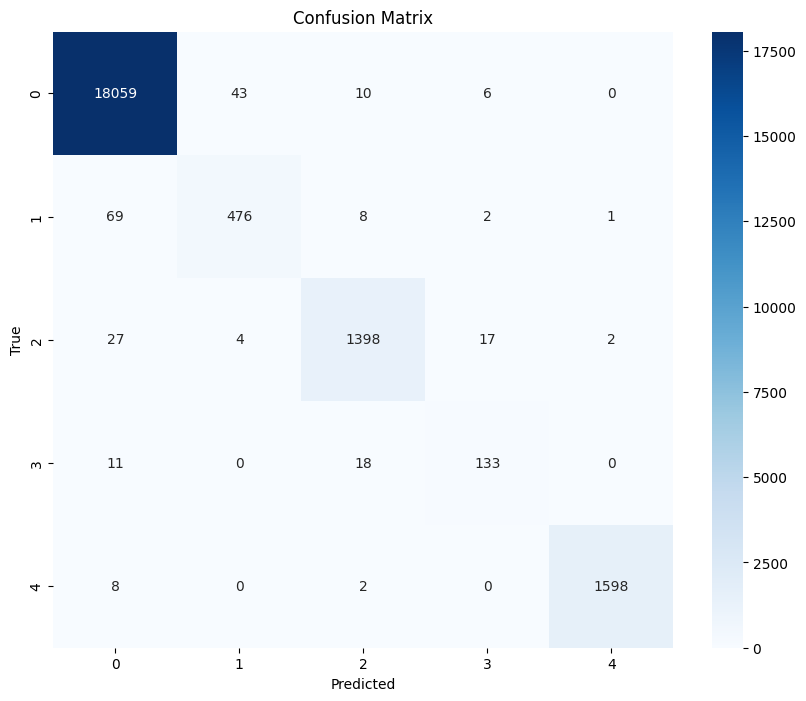

In [65]:
def evaluate_attention_rnn(model, test_loader, device):
    model.eval()
    all_predictions = []
    all_labels = []
    correct = 0
    total = 0
    
    print("\nEvaluating AttentionRNN model...")
    
    with torch.no_grad():
        for batch_X, batch_y in tqdm(test_loader, desc='Testing'):
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs, _ = model(batch_X)
            _, predicted = torch.max(outputs.data, 1)
            
            total += batch_y.size(0)
            correct += (predicted == batch_y).sum().item()
            
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(batch_y.cpu().numpy())
    
    accuracy = 100 * correct / total
    
    # Print results
    print(f"\nTest Results:")
    print(f"Total samples: {total}")
    print(f"Correct predictions: {correct}")
    print(f"Test Accuracy: {accuracy:.2f}%")
    
    # Print classification report
    print("\nClassification Report:")
    print(classification_report(all_labels, all_predictions))
    
    # Plot confusion matrix
    cm = confusion_matrix(all_labels, all_predictions)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    
    return accuracy

test_accuracy = evaluate_attention_rnn(model, test_loader, device)

# Analysis on ECG RNN Model

In [67]:
# Initialize RNN model
rnn_model = ECG_RNN(
    input_size=1,
    hidden_size=128,
    num_layers=2,
    num_classes=5,
    dropout=0.3
)


# Get recommended training configurations
config = get_training_config()

# Create test loader if not already created
test_dataset = ECGDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=32)

# Load the saved model weights
try:
    checkpoint = torch.load('rnn_final_model.pth')
    rnn_model.load_state_dict(checkpoint['model_state_dict'])
    print("Model loaded successfully!")
except Exception as e:
    print(f"Error loading model: {e}")
    print("Make sure the model file 'rnn_model_final.pth' exists in the current directory")


Model loaded successfully!


In [68]:
rnn_model

ECG_RNN(
  (lstm): LSTM(1, 128, num_layers=2, batch_first=True, dropout=0.3, bidirectional=True)
  (attention): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): Tanh()
    (2): Linear(in_features=128, out_features=1, bias=True)
  )
  (fc1): Linear(in_features=256, out_features=128, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=128, out_features=5, bias=True)
  (layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
)

In [69]:
def print_model_weights(model):
    """
    Print weights and parameters of the ECG_RNN model in a structured format
    """
    print("ECG_RNN Model Parameters:")
    print("=" * 80)
    
    total_params = 0
    for name, param in model.named_parameters():
        if param.requires_grad:
            print(f"\nLayer: {name}")
            print(f"Shape: {param.shape}")
            print(f"Number of parameters: {param.numel()}")
            print("-" * 40)
            print("First few values:")
            print(param.data.flatten()[:5].tolist())  # Print first 5 values
            total_params += param.numel()
    
    print("\n" + "=" * 80)
    print(f"Total trainable parameters: {total_params:,}")

In [70]:
import torch
import numpy as np
import lime
import lime.lime_tabular
import shap
import gc
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from typing import List, Tuple, Dict, Optional
import seaborn as sns
from lime.lime_tabular import LimeTabularExplainer

class ECGModelAnalyzer:
    def __init__(self, model, input_size: int, device=None):
        self.input_size = 187  # Add input_size as class attribute
        # Configure CUDA memory management
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
            torch.cuda.set_per_process_memory_fraction(0.8)
            torch.backends.cuda.matmul.allow_tf32 = True
            
        self.device = device if device else torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model = self._prepare_model(model)
        self.class_names = ['Normal', 'Supraventricular ', 'Ventricular', 'Fibrillation', 'Unknown']

    def _prepare_model(self, model):
        """Safely prepare model for GPU usage"""
        try:
            model.to(self.device)
            if self.device.type == 'cuda':
                # Optional: Convert model to half precision to save memory
                # model.half()
                torch.cuda.synchronize()
        except RuntimeError as e:
            print(f"CUDA error during model preparation: {e}")
            print("Falling back to CPU")
            self.device = torch.device('cpu')
            model.to(self.device)
        return model

    def _safe_to_device(self, tensor):
        """Safely move tensor to device with error handling"""
        try:
            return tensor.to(self.device)
        except RuntimeError as e:
            print(f"CUDA memory error: {e}")
            # Try to free memory
            torch.cuda.empty_cache()
            gc.collect()
            try:
                return tensor.to(self.device)
            except RuntimeError:
                print("Falling back to CPU for this operation")
                self.device = torch.device('cpu')
                return tensor.to(self.device)

    def prepare_lime_explainer(self, training_data: np.ndarray) -> LimeTabularExplainer:
        """Prepare LIME explainer with memory management"""
        try:
            # Move data processing to CPU to save GPU memory
            with torch.cuda.device(self.device):
                flattened_data = training_data.reshape(training_data.shape[0], -1)
                feature_names = [f'time_{i}' for i in range(flattened_data.shape[1])]
                
                explainer = LimeTabularExplainer(
                    flattened_data,
                    feature_names=feature_names,
                    class_names=self.class_names,
                    mode='regression'
                )
                
                return explainer
        except Exception as e:
            print(f"Error in LIME preparation: {e}")
            raise

    def model_prediction_wrapper(self, data: np.ndarray) -> np.ndarray:
        """Memory-efficient model prediction wrapper with input validation"""
        self.model.eval()
        try:
            with torch.no_grad():
                # Reshape data to match expected input size
                if len(data.shape) == 1:
                    data = data.reshape(1, self.input_size, 1)
                elif len(data.shape) == 2:
                    data = data.reshape(data.shape[0], self.input_size, 1)
                
                # Validate input size
                if data.shape[1] != self.input_size:
                    raise ValueError(f"Input size mismatch. Expected {self.input_size}, got {data.shape[1]}")
                
                # Process in batches if data is large
                batch_size = 32
                if data.shape[0] > batch_size:
                    predictions = []
                    for i in range(0, data.shape[0], batch_size):
                        batch = data[i:i+batch_size]
                        batch_preds = self._process_batch(batch)
                        predictions.append(batch_preds)
                    return np.vstack(predictions)
                else:
                    return self._process_batch(data)
        except RuntimeError as e:
            print(f"CUDA error during prediction: {e}")
            torch.cuda.empty_cache()
            return self._process_batch(data, use_cpu=True)

    def _process_batch(self, batch: np.ndarray, use_cpu: bool = False) -> np.ndarray:
        """Process a single batch of data"""
        device = torch.device('cpu') if use_cpu else self.device
        batch_tensor = torch.FloatTensor(batch).to(device)
        outputs, _ = self.model(batch_tensor)
        probs = torch.softmax(outputs, dim=1)
        return probs.cpu().numpy()

    def analyze_single_sample(self, 
                            sample: np.ndarray, 
                            explainer: LimeTabularExplainer,
                            num_features: int = 10) -> Optional[Dict]:
        """Memory-efficient single sample analysis with error handling"""
        try:
            # Ensure sample has correct shape
            if len(sample.shape) == 1:
                sample = sample.reshape(-1, 1)
            
            flattened_sample = sample.reshape(-1)
            torch.cuda.empty_cache()
            
            explanation = explainer.explain_instance(
                flattened_sample,
                self.model_prediction_wrapper,
                num_features=num_features,
                top_labels=len(self.class_names)
            )
            
            pred = self.model_prediction_wrapper(flattened_sample.reshape(1, self.input_size, 1))
            
            return {
                'explanation': explanation,
                'prediction': pred[0] if pred is not None else None,
                'feature_importance': explanation.as_list()
            }
        except Exception as e:
            print(f"Error during sample analysis: {e}")
            return None

    # ... (rest of the visualization and analysis methods remain the same)
    def visualize_lime_explanation(self, 
                                 sample: np.ndarray,
                                 analysis_result: Optional[Dict],
                                 save_path: str = None):
        """Visualize LIME explanation results with error handling"""
        if analysis_result is None:
            print("No analysis result to visualize")
            return
        
        try:
            fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))
            
            # Plot original signal
            ax1.plot(sample.flatten())
            ax1.set_title('Original ECG Signal')
            ax1.set_xlabel('Time')
            ax1.set_ylabel('Amplitude')
            
            # Plot feature importance if available
            if 'feature_importance' in analysis_result and analysis_result['feature_importance']:
                importance_df = pd.DataFrame(analysis_result['feature_importance'], 
                                          columns=['Feature', 'Importance'])
                sns.barplot(data=importance_df, x='Importance', y='Feature', ax=ax2)
                ax2.set_title('Feature Importance (LIME)')
            else:
                ax2.text(0.5, 0.5, 'No feature importance data available', 
                        horizontalalignment='center', verticalalignment='center')
            
            plt.tight_layout()
            if save_path:
                plt.savefig(save_path)
            plt.show()
        except Exception as e:
            print(f"Error during visualization: {e}")
            plt.close()

    def analyze_dataset(self, 
                       data: np.ndarray,
                       samples_to_analyze: int = 5) -> List[Dict]:
        """Analyze multiple samples from the dataset with error handling"""
        results = []
        
        try:
            # Prepare LIME explainer
            explainer = self.prepare_lime_explainer(data)
            
            # Randomly select samples
            indices = np.random.choice(len(data), samples_to_analyze, replace=False)
            
            for idx in indices:
                sample = data[idx]
                result = self.analyze_single_sample(sample, explainer)
                
                if result is not None:
                    results.append({
                        'sample_idx': idx,
                        'analysis': result
                    })
                    
                    # Visualize results
                    self.visualize_lime_explanation(sample, result)
                
            return results
        except Exception as e:
            print(f"Error during dataset analysis: {e}")
            return results
    
    def get_model_summary(self) -> Dict:
        """
        Get summary statistics about the model
        """
        total_params = sum(p.numel() for p in self.model.parameters())
        trainable_params = sum(p.numel() for p in self.model.parameters() if p.requires_grad)
        
        return {
            'total_parameters': total_params,
            'trainable_parameters': trainable_params,
            'model_architecture': str(self.model),
            'device': str(self.device)
        }
    
    def analyze_attention_weights(self, sample: np.ndarray) -> np.ndarray:
        """
        Analyze attention weights for a sample
        """
        self.model.eval()
        with torch.no_grad():
            sample_tensor = torch.FloatTensor(sample).unsqueeze(0).to(self.device)
            _, attention_weights = self.model(sample_tensor)
            return attention_weights.cpu().numpy()

    def get_memory_stats(self) -> Dict:
        """Get current GPU memory statistics"""
        if self.device.type == 'cuda':
            return {
                'allocated': torch.cuda.memory_allocated(self.device) / 1024**2,  # MB
                'cached': torch.cuda.memory_reserved(self.device) / 1024**2,  # MB
                'max_allocated': torch.cuda.max_memory_allocated(self.device) / 1024**2  # MB
            }
        return {'device': 'cpu'}

In [71]:
def display_samples_by_class(model, data, labels, input_size):
    """
    Display and visualize one sample from each class
    
    Parameters:
    - model: trained model
    - data: ECG data array
    - labels: corresponding labels array
    - input_size: input size for the model
    """
    analyzer = ECGModelAnalyzer(model, input_size=input_size)
    class_names = ['Normal', 'Supraventricular ', 'Ventricular', 'Fibrillation', 'Unknown']
    
    print("\n=== Analyzing One Sample from Each Class ===")
    
    # Find one sample from each class
    for class_idx, class_name in enumerate(class_names):
        # Find indices for current class
        class_indices = np.where(labels == class_idx)[0]
        
        if len(class_indices) == 0:
            print(f"\nNo samples found for class: {class_name}")
            continue
            
        # Select one random sample from this class
        sample_idx = np.random.choice(class_indices)
        sample_data = data[sample_idx]
        
        # Analyze the sample
        explainer = analyzer.prepare_lime_explainer(data)
        analysis = analyzer.analyze_single_sample(sample_data, explainer)
        
        print(f"\nClass: {class_name} (Sample Index: {sample_idx})")
        print("-" * 50)
        
        if analysis and 'prediction' in analysis:
            # Print predictions
            predictions = analysis['prediction']
            print("\nClass Probabilities:")
            for cls_name, prob in zip(class_names, predictions):
                print(f"{cls_name}: {prob:.4f}")
            
            # Print confidence
            pred_class = np.argmax(predictions)
            confidence = predictions[pred_class]
            print(f"\nPredicted Class: {class_names[pred_class]}")
            print(f"Confidence: {confidence:.4f}")
            
            # Create visualization
            plt.figure(figsize=(15, 12))
            
            # Plot 1: Original Signal
            plt.subplot(3, 1, 1)
            plt.plot(sample_data.flatten(), 'b-', label='ECG Signal')
            plt.title(f'{class_name} - Original ECG Signal')
            plt.xlabel('Time')
            plt.ylabel('Amplitude')
            plt.legend()
            plt.grid(True)
            
            # Plot 2: Feature Importance
            if 'feature_importance' in analysis:
                plt.subplot(3, 1, 2)
                importance_df = pd.DataFrame(
                    analysis['feature_importance'][:10],
                    columns=['Feature', 'Importance']
                )
                sns.barplot(data=importance_df, x='Importance', y='Feature')
                plt.title(f'{class_name} - Top 10 Important Features')
            
            # Plot 3: Class Probabilities
            plt.subplot(3, 1, 3)
            plt.bar(class_names, predictions)
            plt.title(f'{class_name} - Class Probabilities')
            plt.xticks(rotation=45)
            plt.ylabel('Probability')
            
            plt.tight_layout()
            plt.show()
            
            # Print separator
            print("\n" + "="*80 + "\n")


=== Analyzing One Sample from Each Class ===

Class: Normal (Sample Index: 15795)
--------------------------------------------------

Class Probabilities:
Normal: 0.9195
Supraventricular : 0.0201
Ventricular: 0.0202
Fibrillation: 0.0199
Unknown: 0.0202

Predicted Class: Normal
Confidence: 0.9195


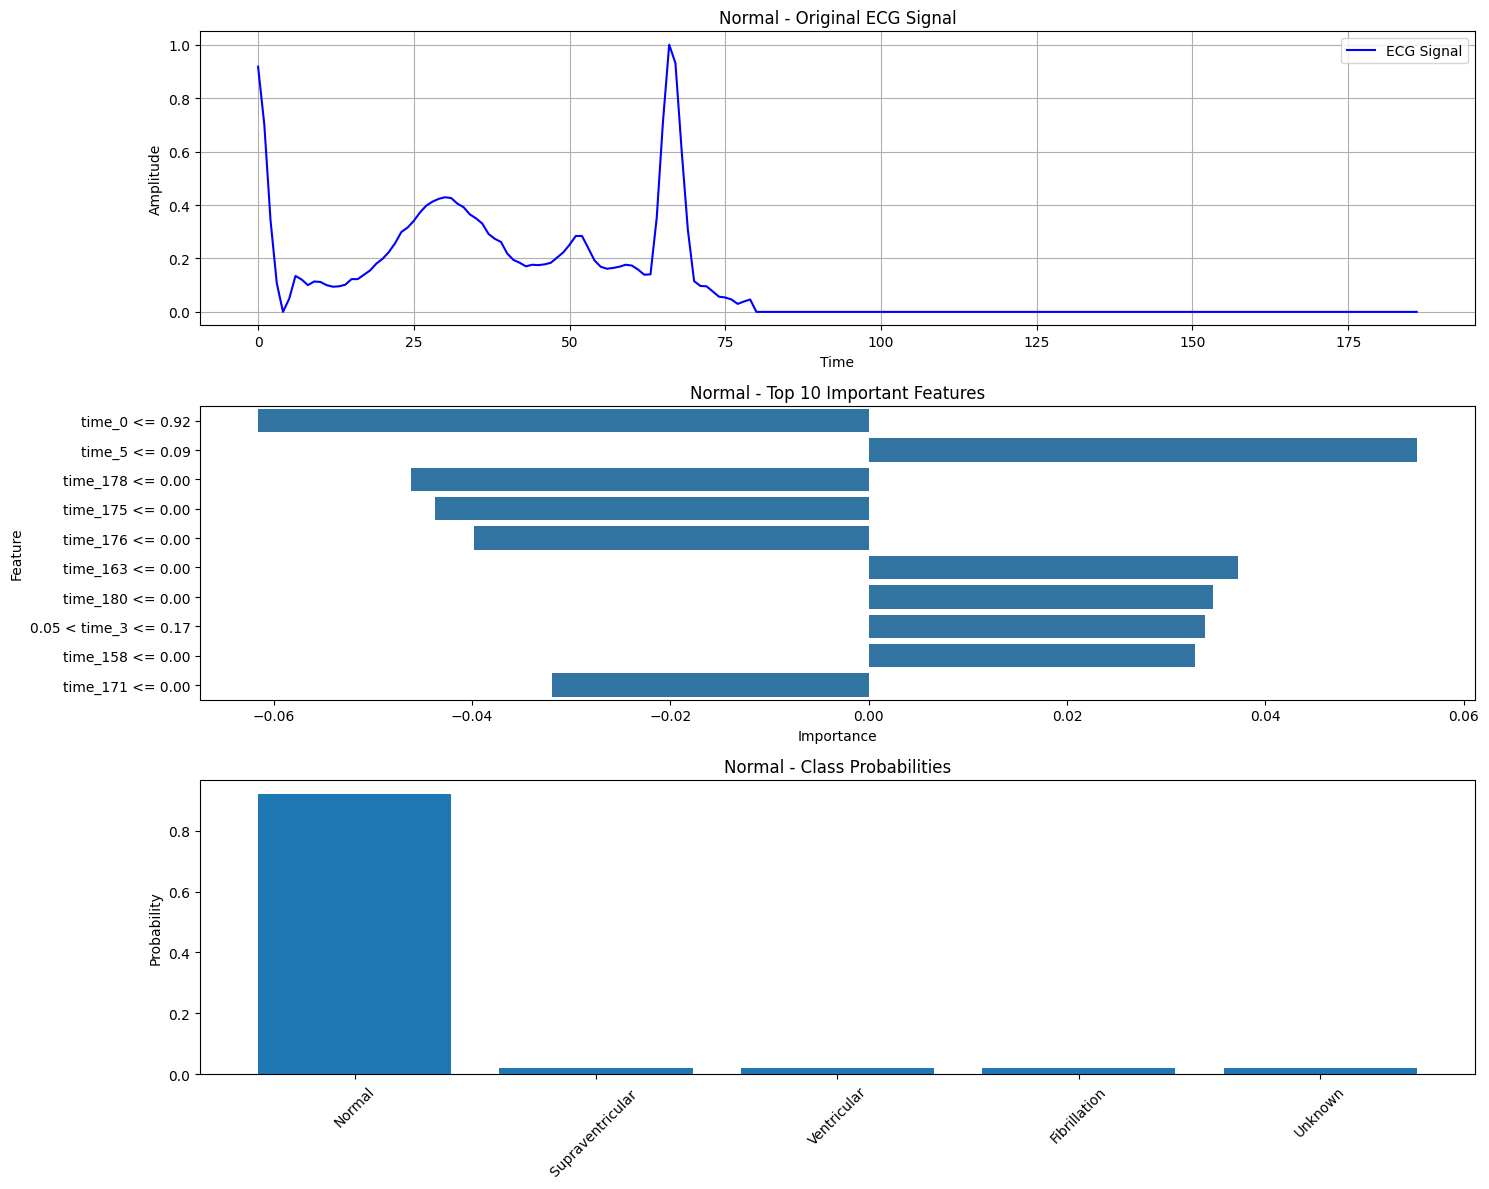




Class: Supraventricular  (Sample Index: 18644)
--------------------------------------------------

Class Probabilities:
Normal: 0.0182
Supraventricular : 0.9230
Ventricular: 0.0200
Fibrillation: 0.0203
Unknown: 0.0185

Predicted Class: Supraventricular 
Confidence: 0.9230


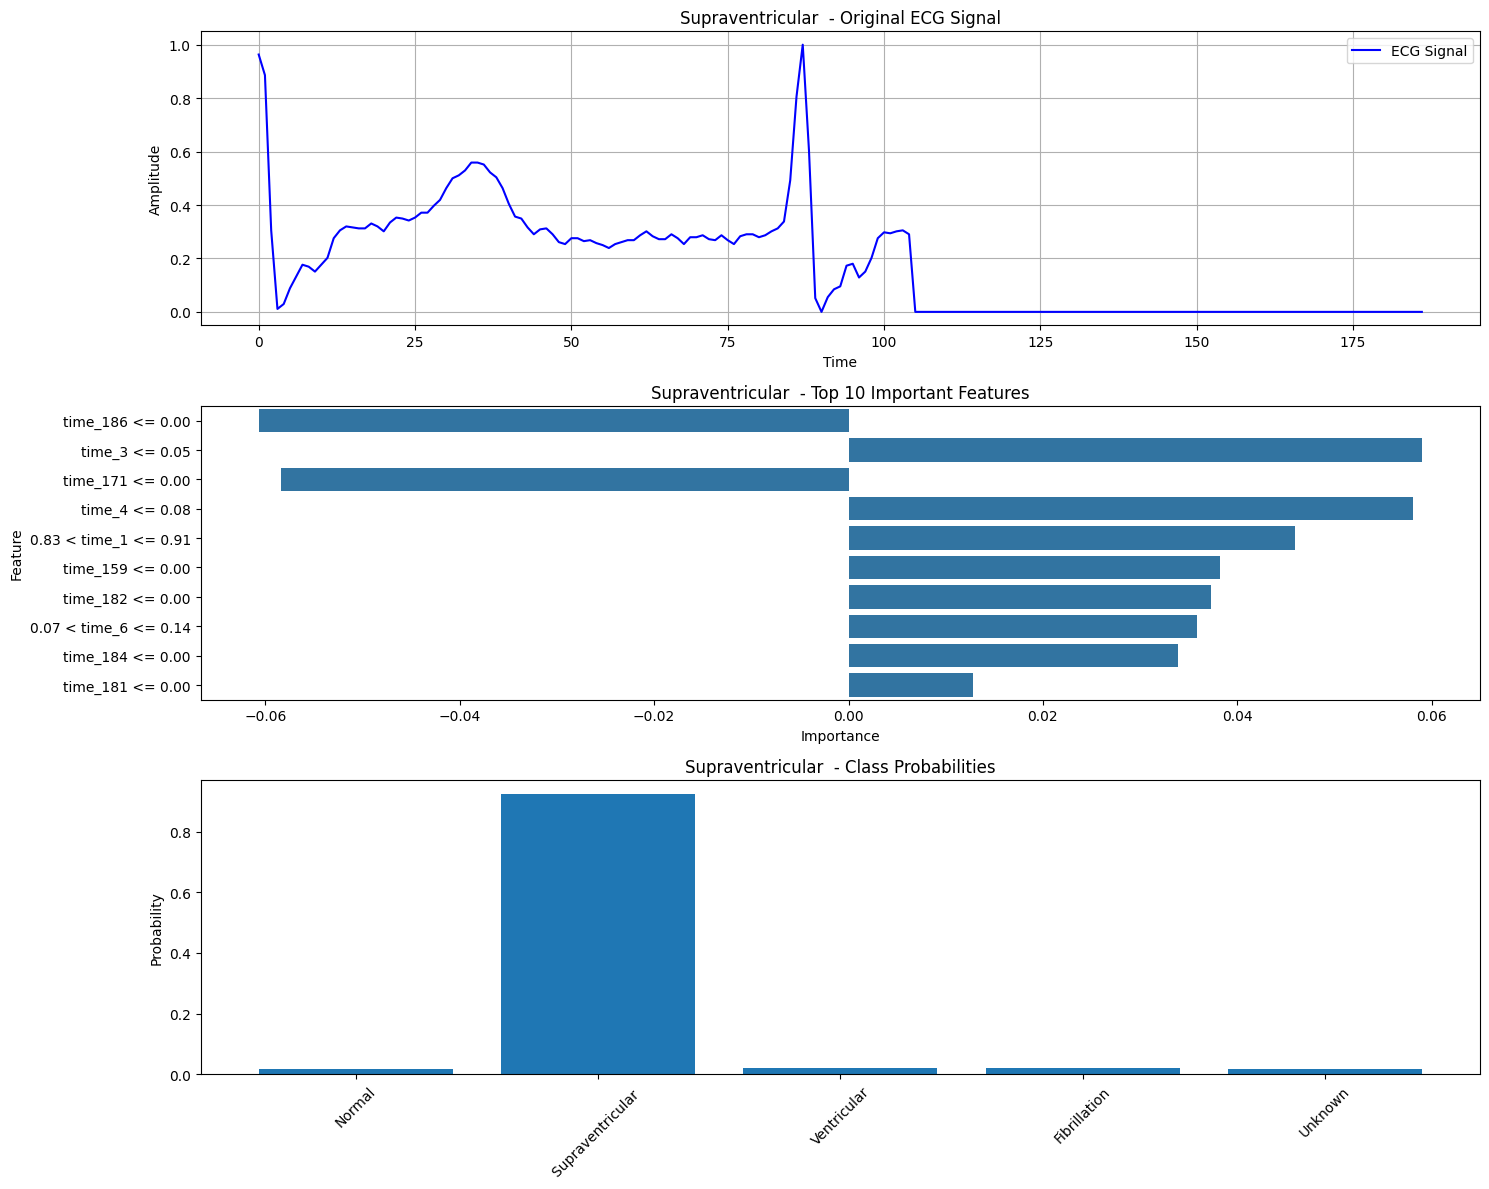




Class: Ventricular (Sample Index: 19874)
--------------------------------------------------

Class Probabilities:
Normal: 0.0158
Supraventricular : 0.0196
Ventricular: 0.9240
Fibrillation: 0.0202
Unknown: 0.0204

Predicted Class: Ventricular
Confidence: 0.9240


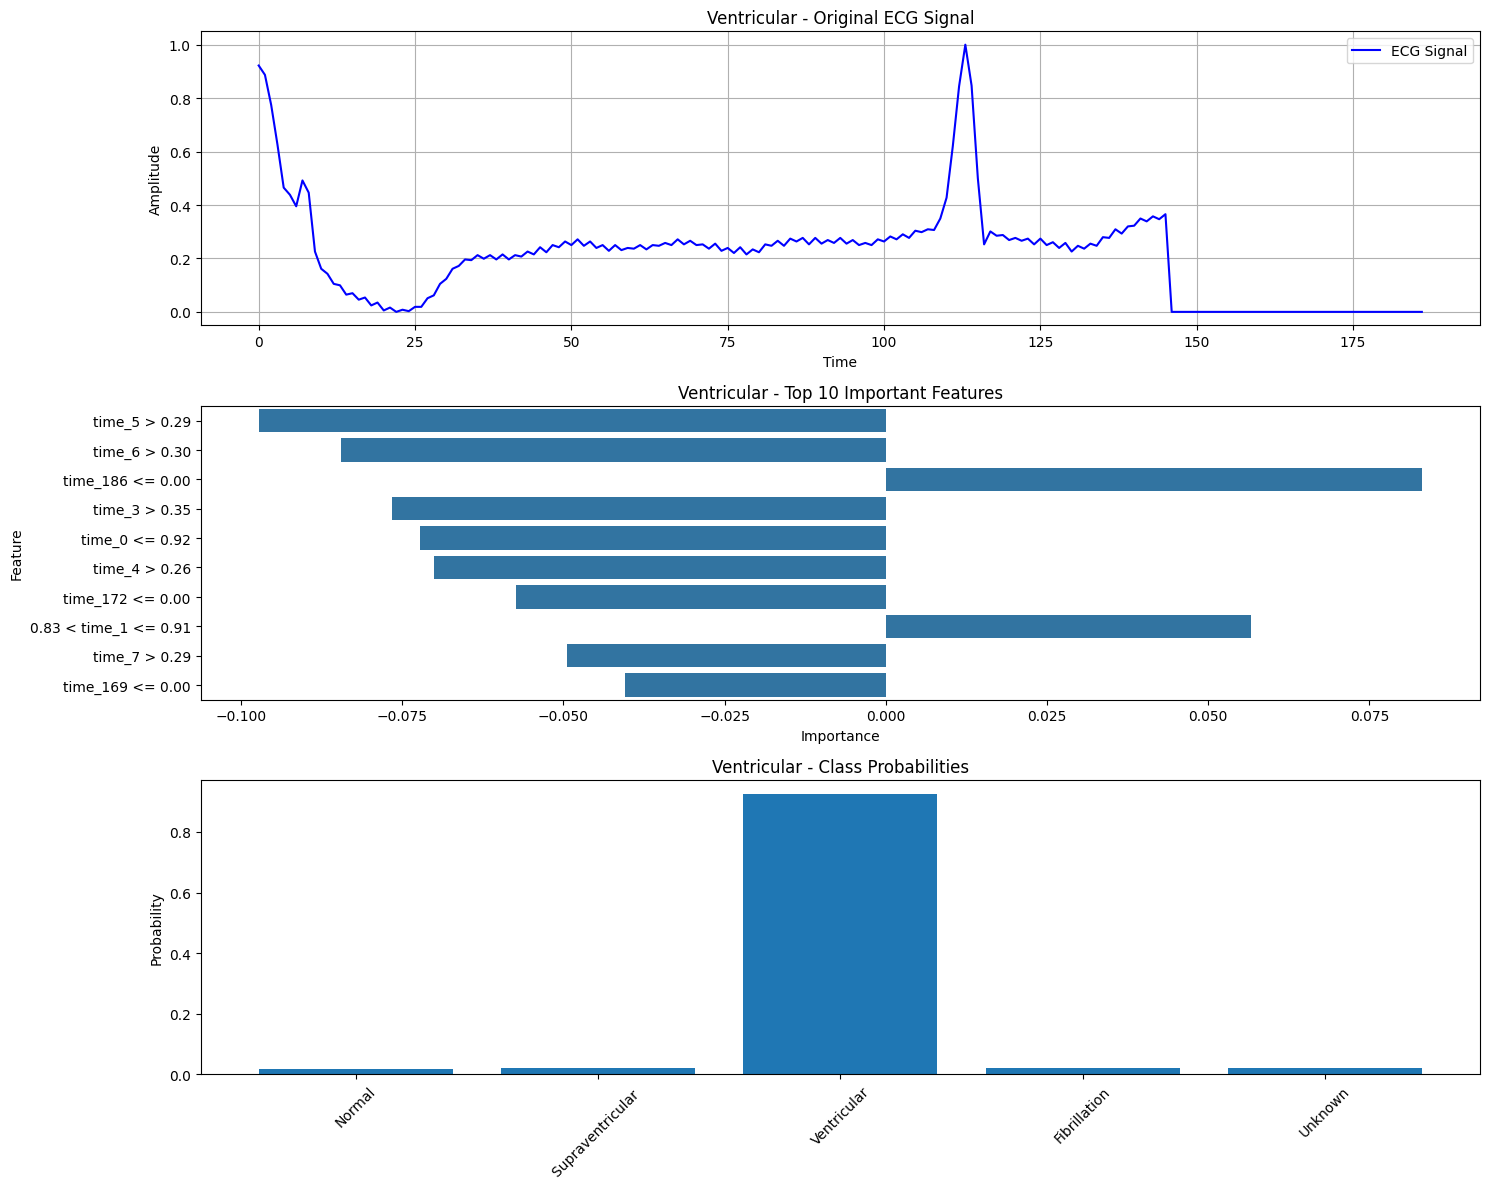




Class: Fibrillation (Sample Index: 20220)
--------------------------------------------------

Class Probabilities:
Normal: 0.0087
Supraventricular : 0.0157
Ventricular: 0.0136
Fibrillation: 0.9453
Unknown: 0.0167

Predicted Class: Fibrillation
Confidence: 0.9453


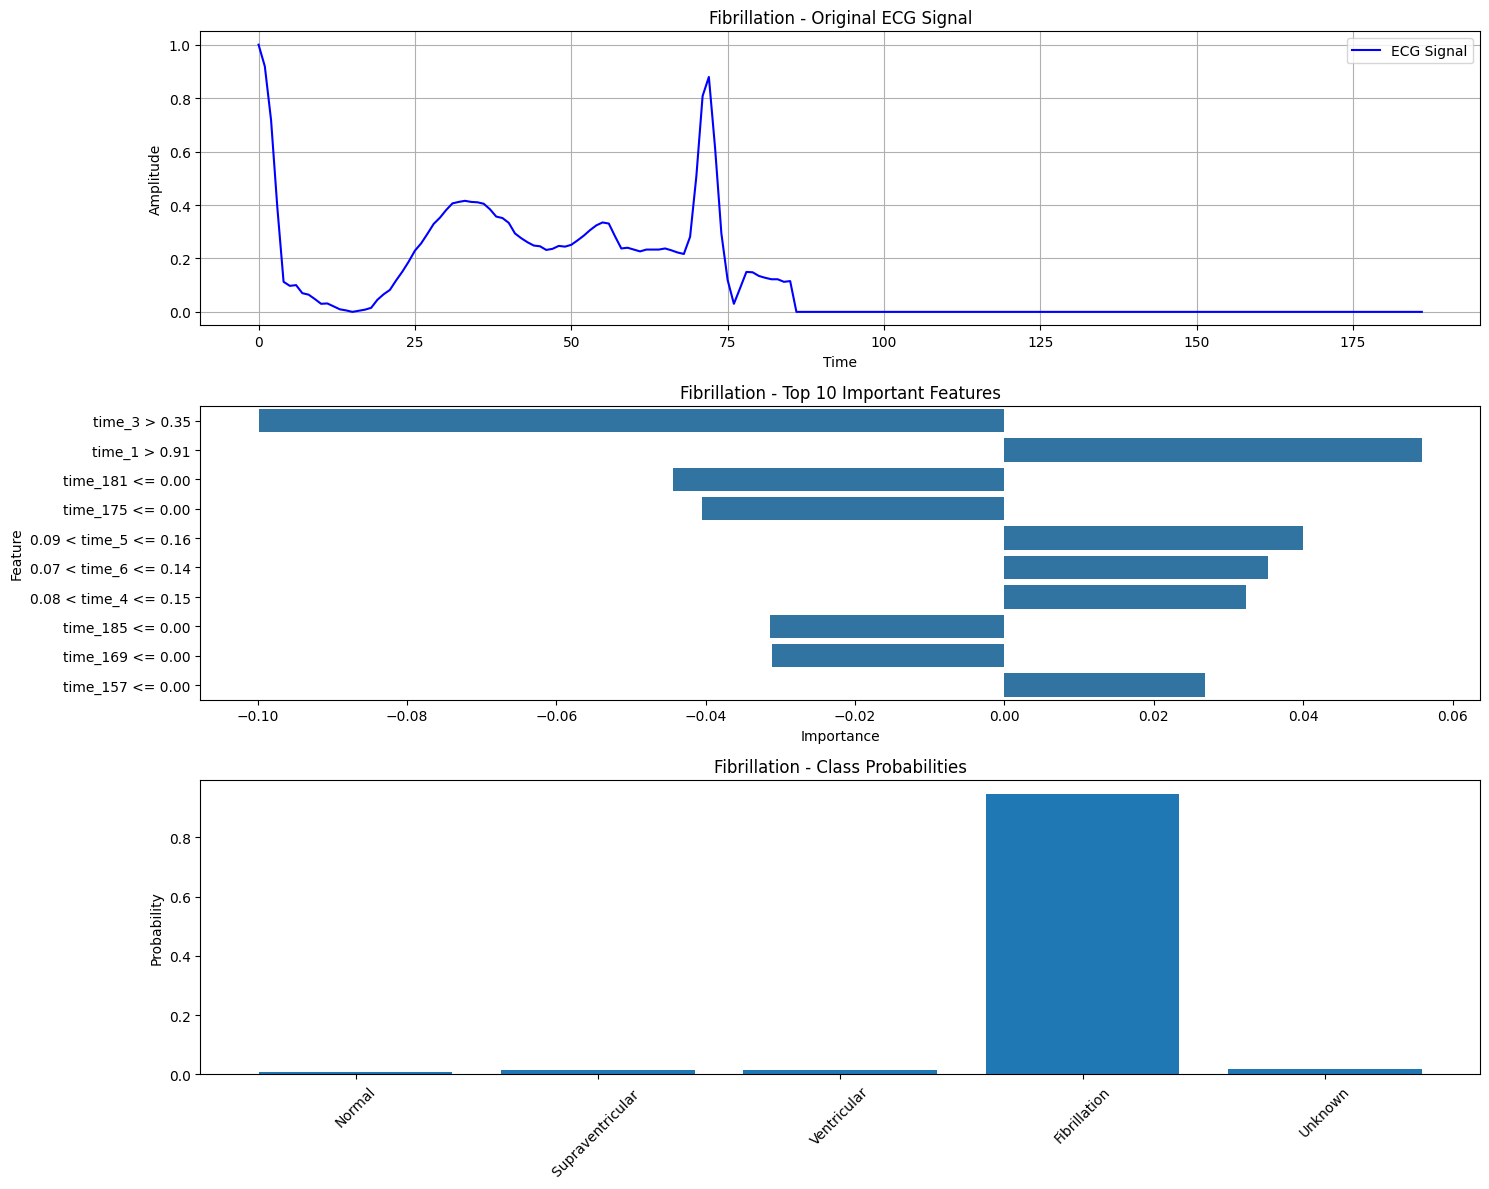




Class: Unknown (Sample Index: 20487)
--------------------------------------------------

Class Probabilities:
Normal: 0.0169
Supraventricular : 0.0209
Ventricular: 0.0194
Fibrillation: 0.0200
Unknown: 0.9228

Predicted Class: Unknown
Confidence: 0.9228


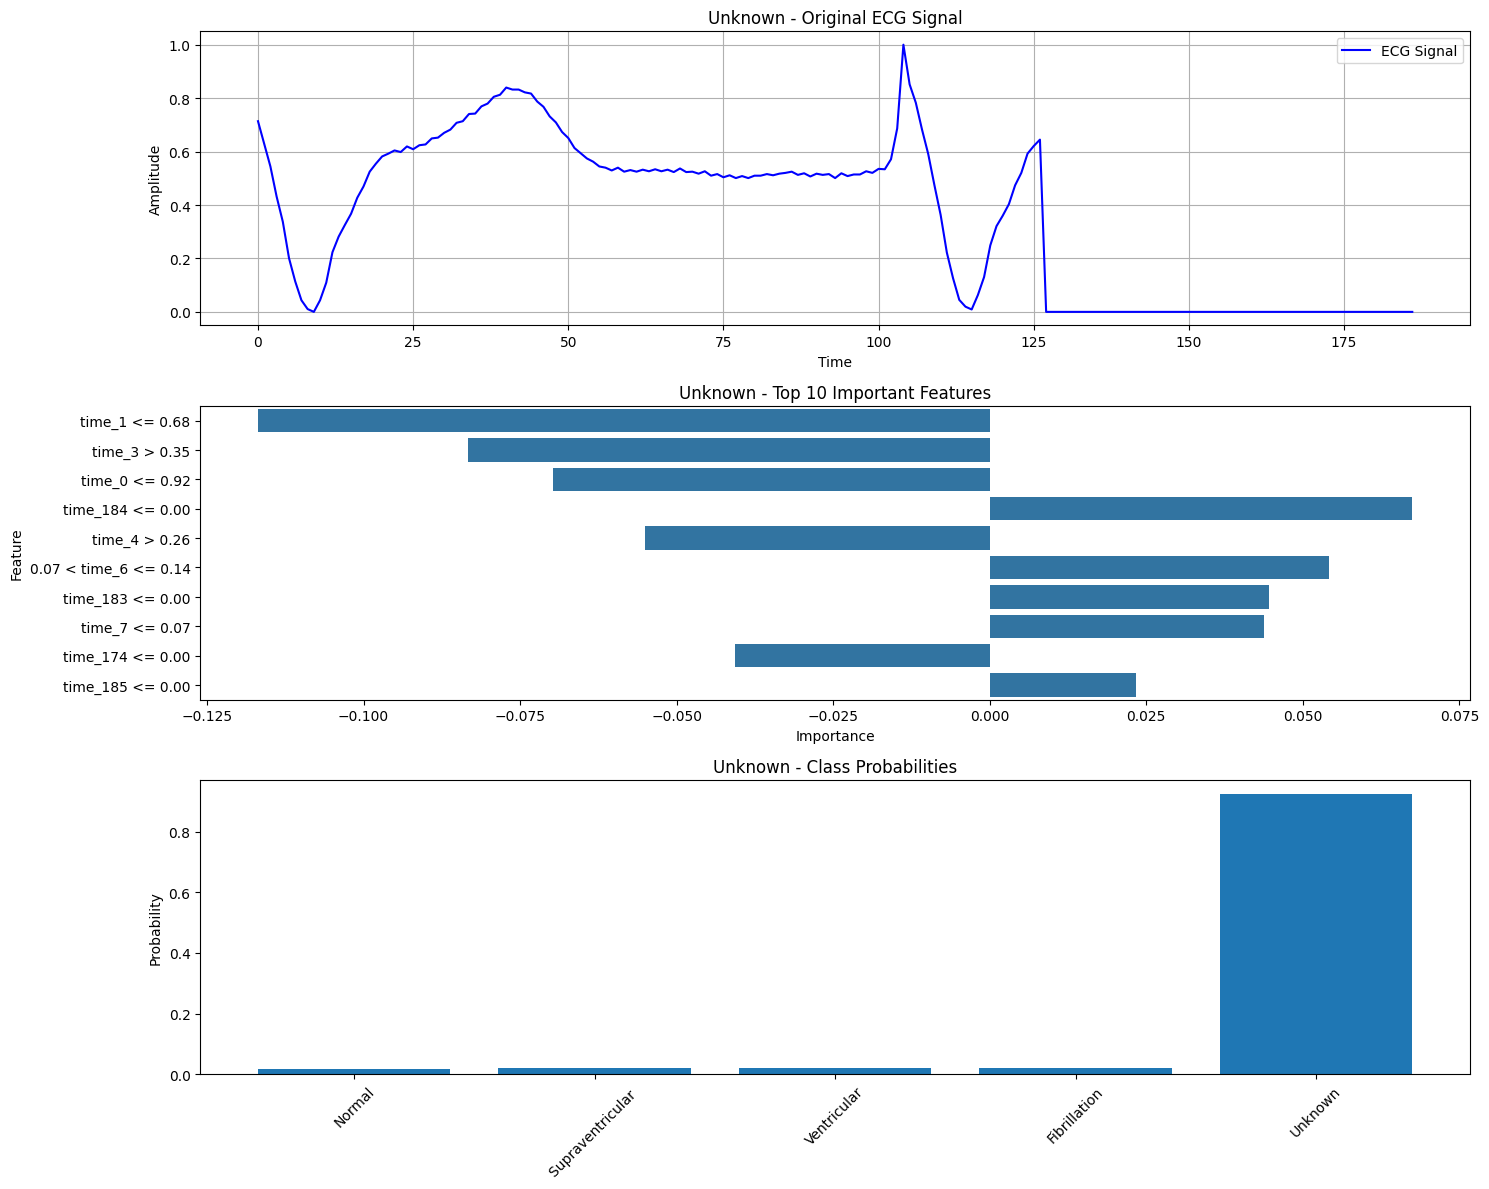

In [72]:
def run_class_analysis(model, data, labels, input_size):
    """Run analysis for one sample from each class"""
    try:
        display_samples_by_class(model, data, labels, input_size)
    except Exception as e:
        print(f"Error during analysis: {e}")

# Insert in RNN_model
run_class_analysis(rnn_model, X_test, y_test, 187)

# Analysis on ECG GRU Attention Model

In [74]:
# Load ECG GRU Attention Model
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Initialize model
input_size = 1  # Single channel ECG
hidden_size = 128
num_layers = 2
num_classes = 5  

# Create model instance
gru_attention_model = AttentionRNN(
    input_size=input_size,
    hidden_size=hidden_size,
    num_layers=num_layers,
    num_classes=num_classes
).to(device)

# Create test loader if not already created
test_dataset = ECGDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=32)

# Load the saved model weights
try:
    checkpoint = torch.load('ecg_model_final_augmented.pth')
    gru_attention_model.load_state_dict(checkpoint['model_state_dict'])
    print("Model loaded successfully!")
except Exception as e:
    print(f"Error loading model: {e}")
    print("Make sure the model file 'ecg_model_final.pth' exists in the current directory")

Using device: cuda
Model loaded successfully!



=== Analyzing One Sample from Each Class ===

Class: Normal (Sample Index: 13481)
--------------------------------------------------

Class Probabilities:
Normal: 1.0000
Supraventricular : 0.0000
Ventricular: 0.0000
Fibrillation: 0.0000
Unknown: 0.0000

Predicted Class: Normal
Confidence: 1.0000


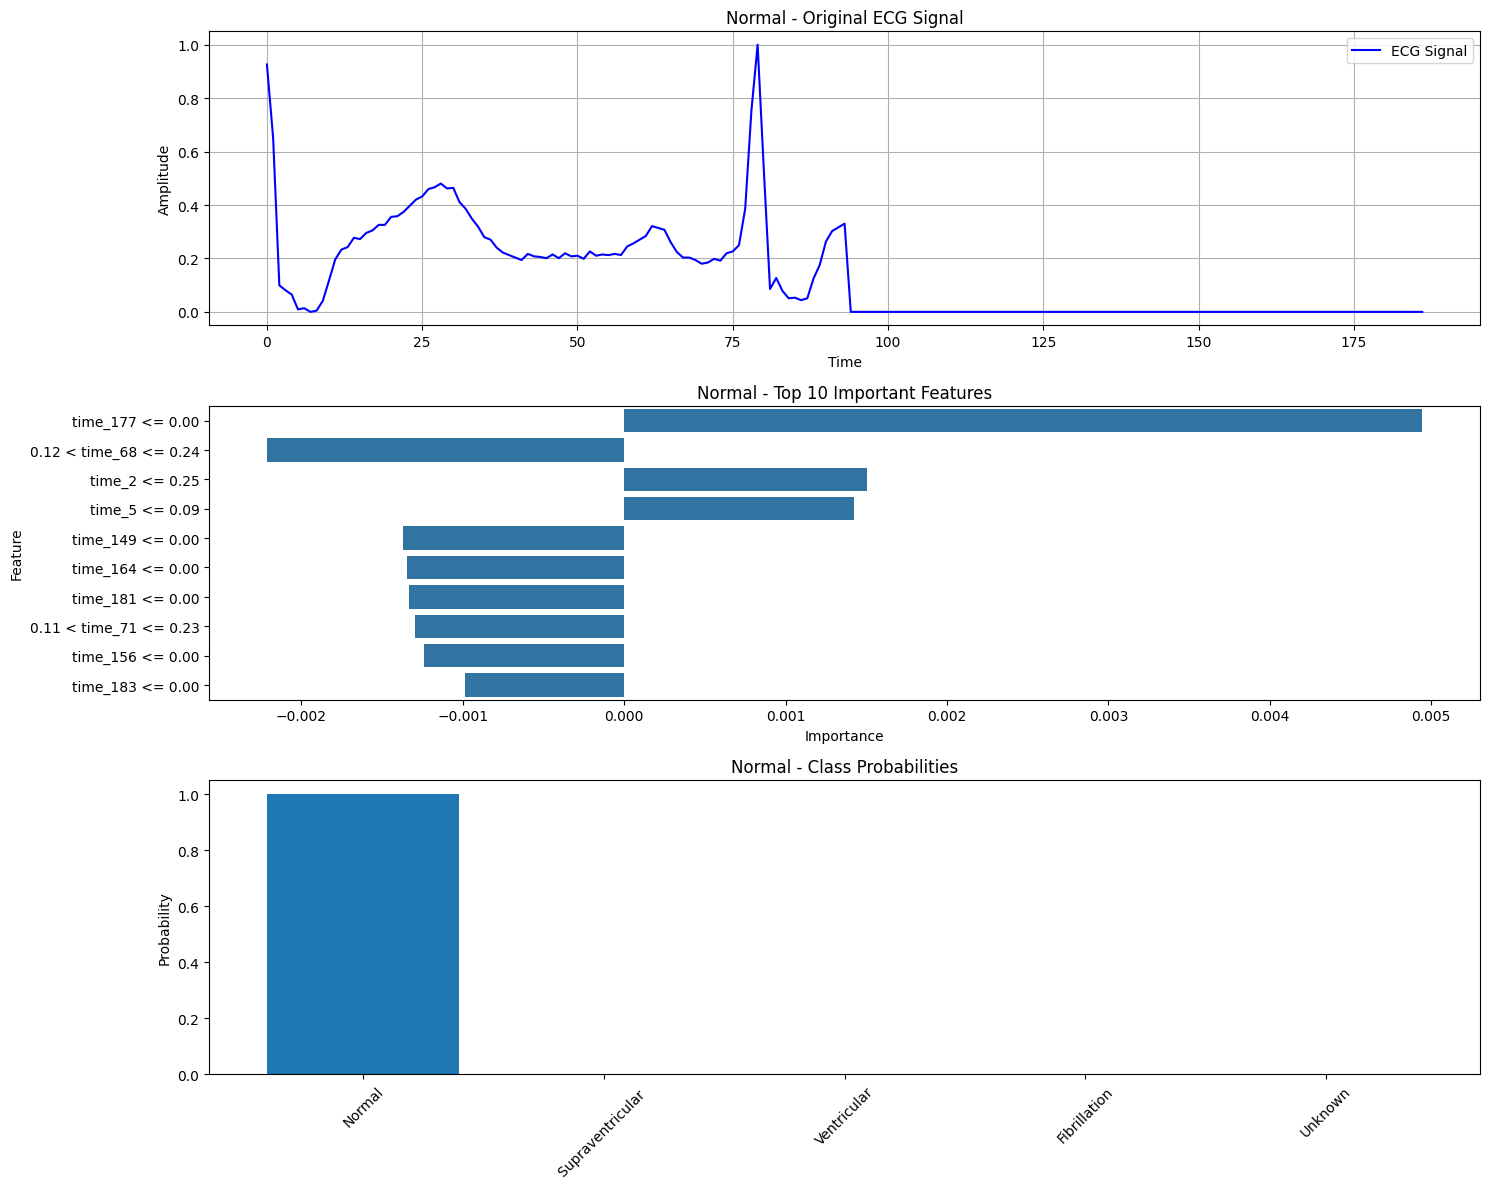




Class: Supraventricular  (Sample Index: 18479)
--------------------------------------------------

Class Probabilities:
Normal: 0.0000
Supraventricular : 1.0000
Ventricular: 0.0000
Fibrillation: 0.0000
Unknown: 0.0000

Predicted Class: Supraventricular 
Confidence: 1.0000


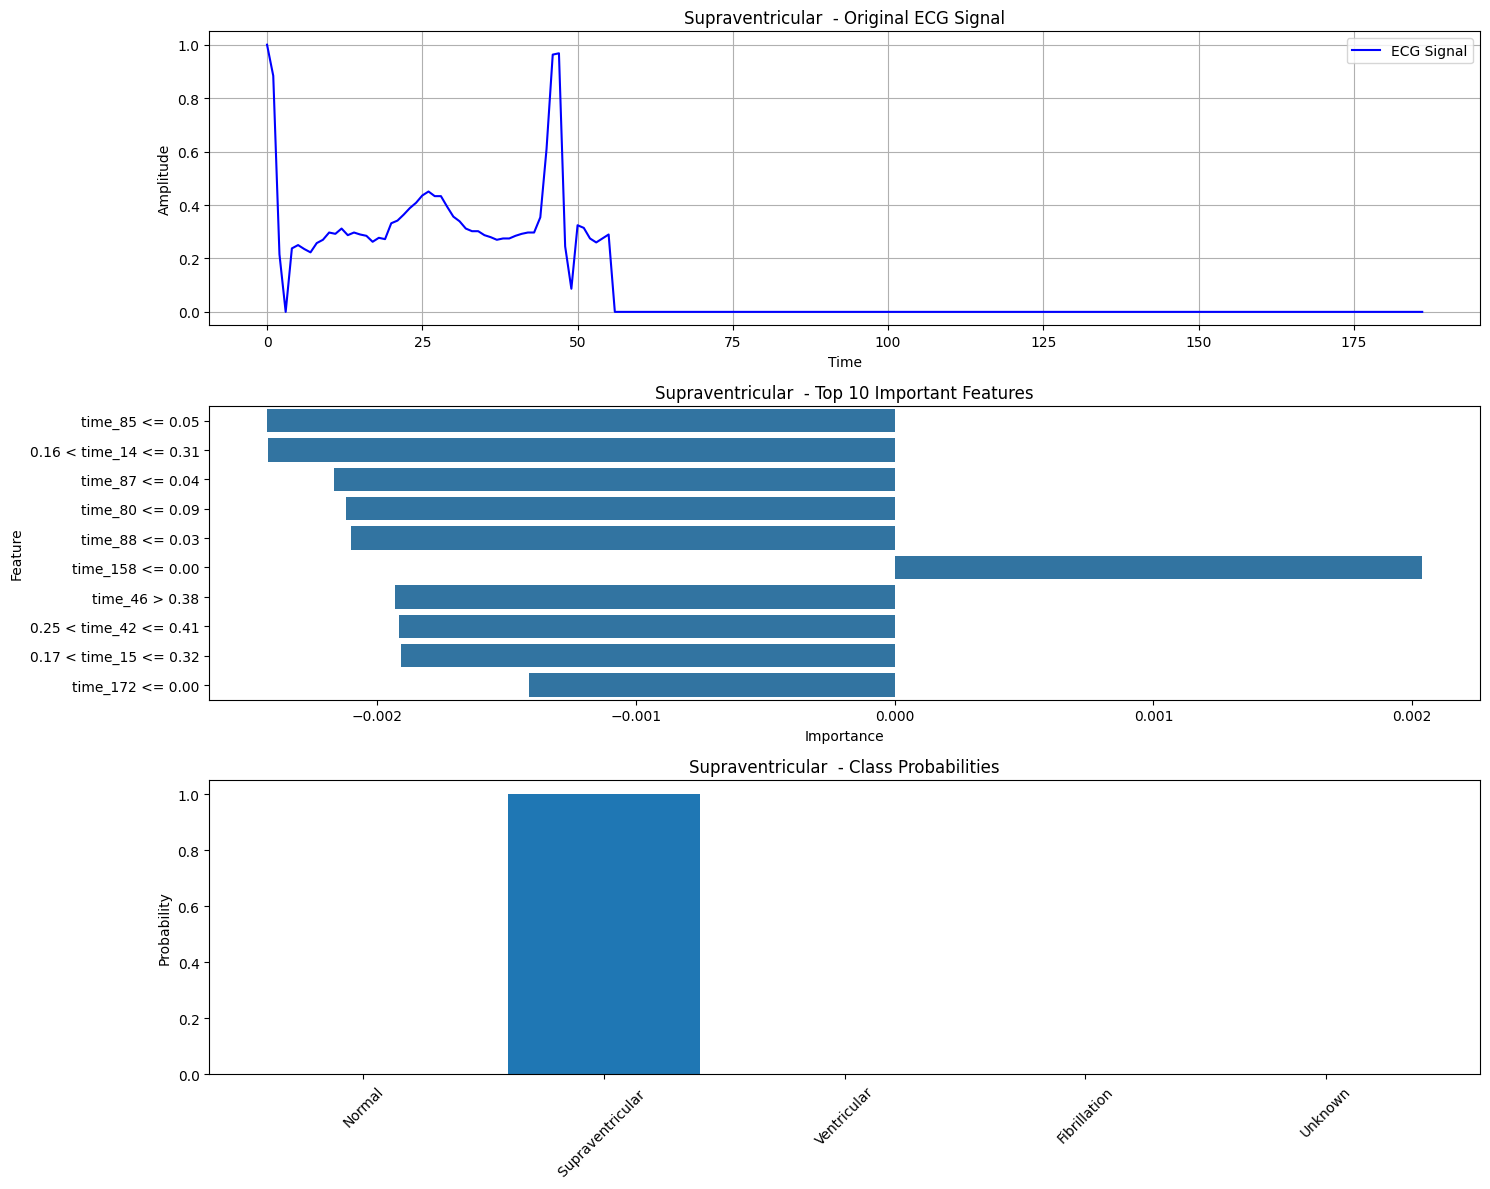




Class: Ventricular (Sample Index: 19979)
--------------------------------------------------

Class Probabilities:
Normal: 0.8179
Supraventricular : 0.0000
Ventricular: 0.1820
Fibrillation: 0.0000
Unknown: 0.0000

Predicted Class: Normal
Confidence: 0.8179


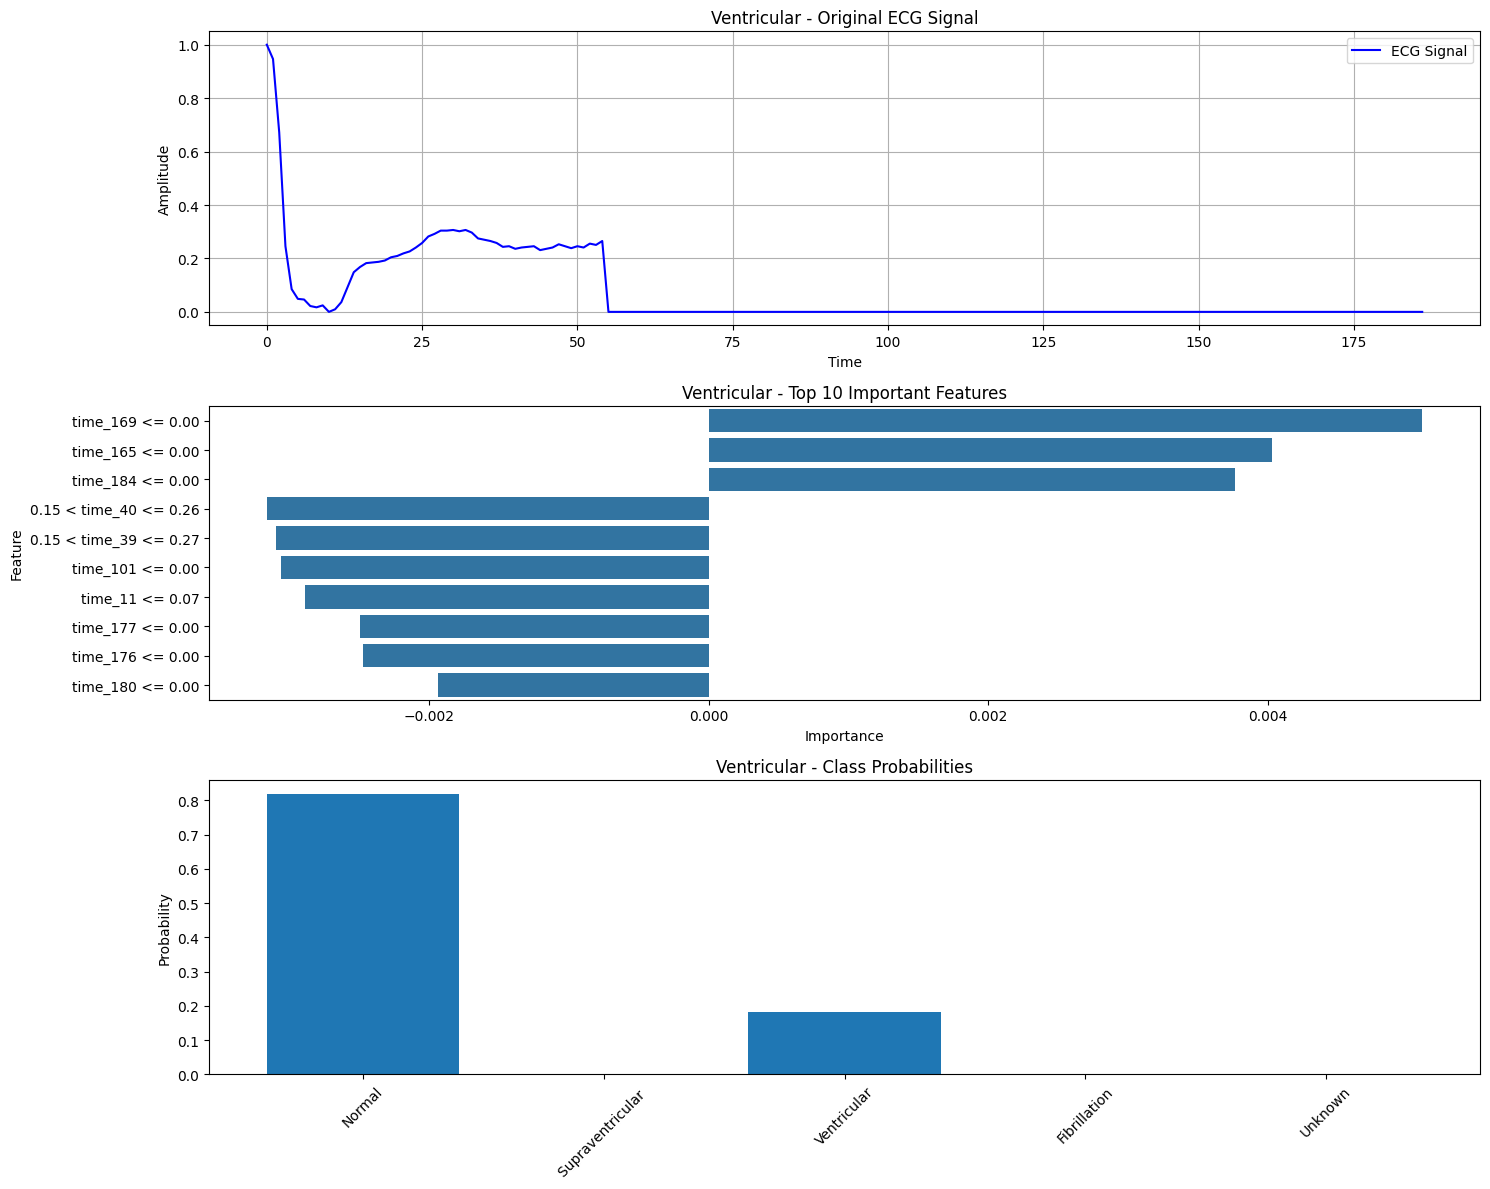




Class: Fibrillation (Sample Index: 20195)
--------------------------------------------------

Class Probabilities:
Normal: 0.7202
Supraventricular : 0.0000
Ventricular: 0.0001
Fibrillation: 0.2797
Unknown: 0.0000

Predicted Class: Normal
Confidence: 0.7202


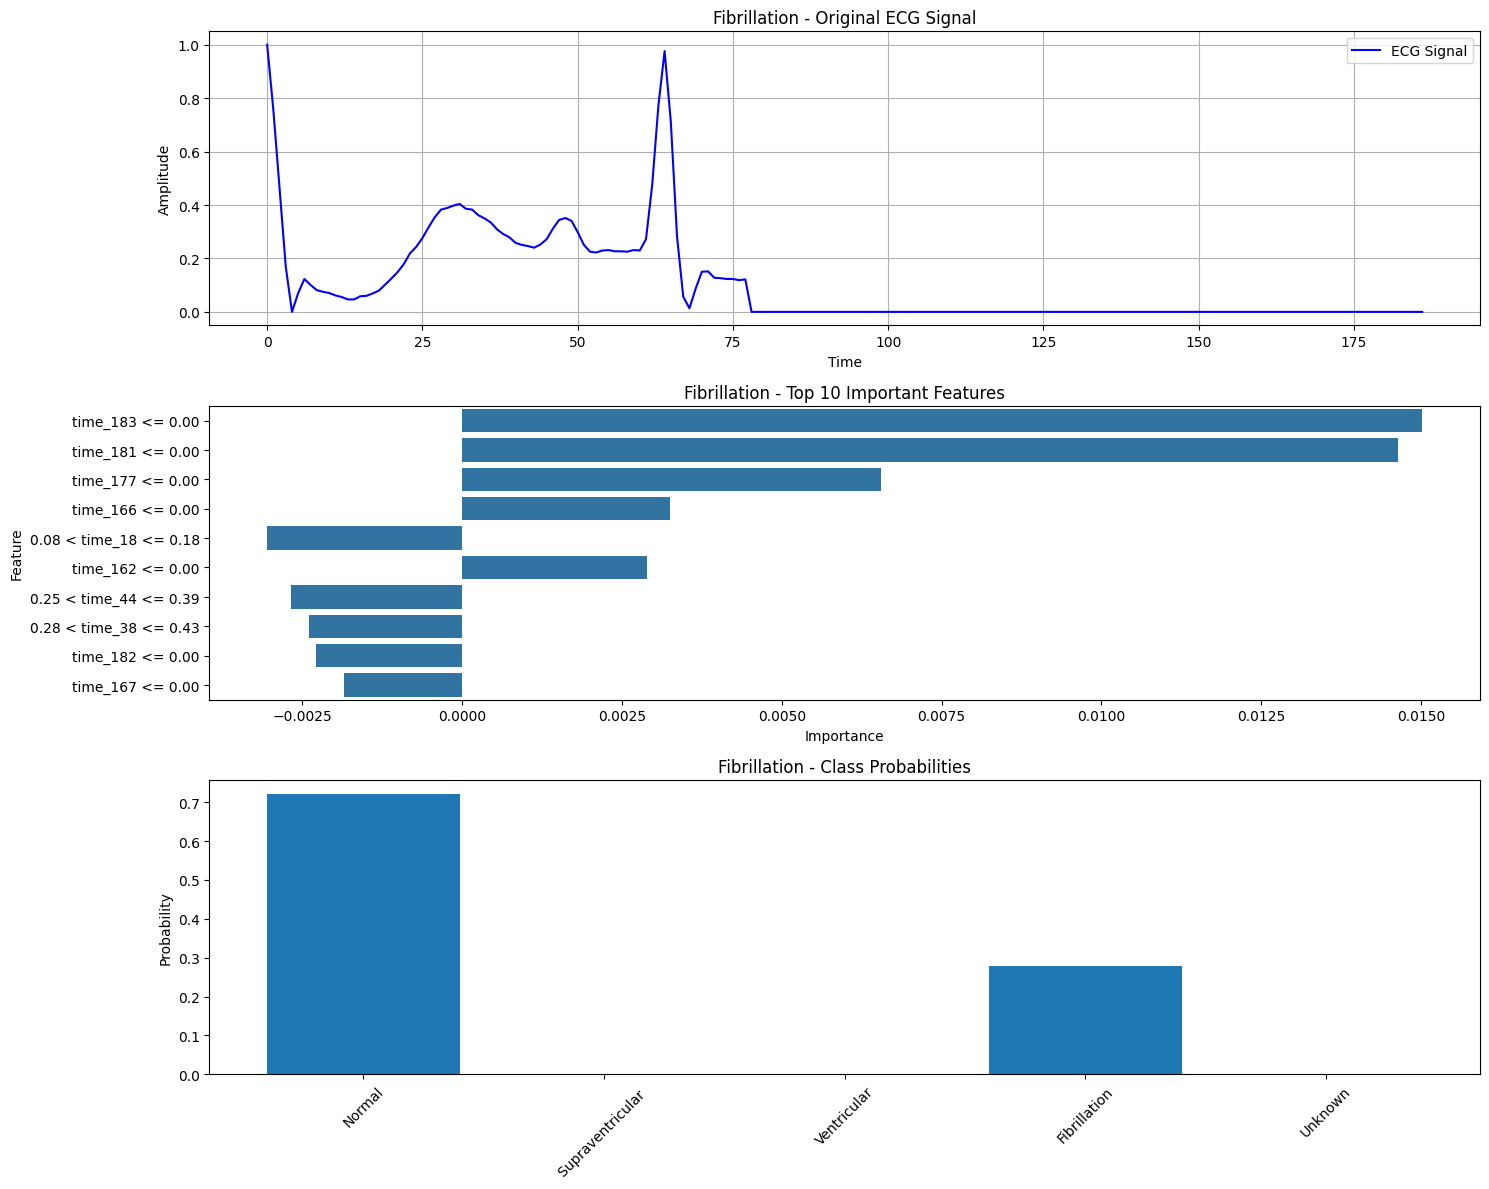




Class: Unknown (Sample Index: 21398)
--------------------------------------------------

Class Probabilities:
Normal: 0.0000
Supraventricular : 0.0000
Ventricular: 0.0000
Fibrillation: 0.0000
Unknown: 1.0000

Predicted Class: Unknown
Confidence: 1.0000


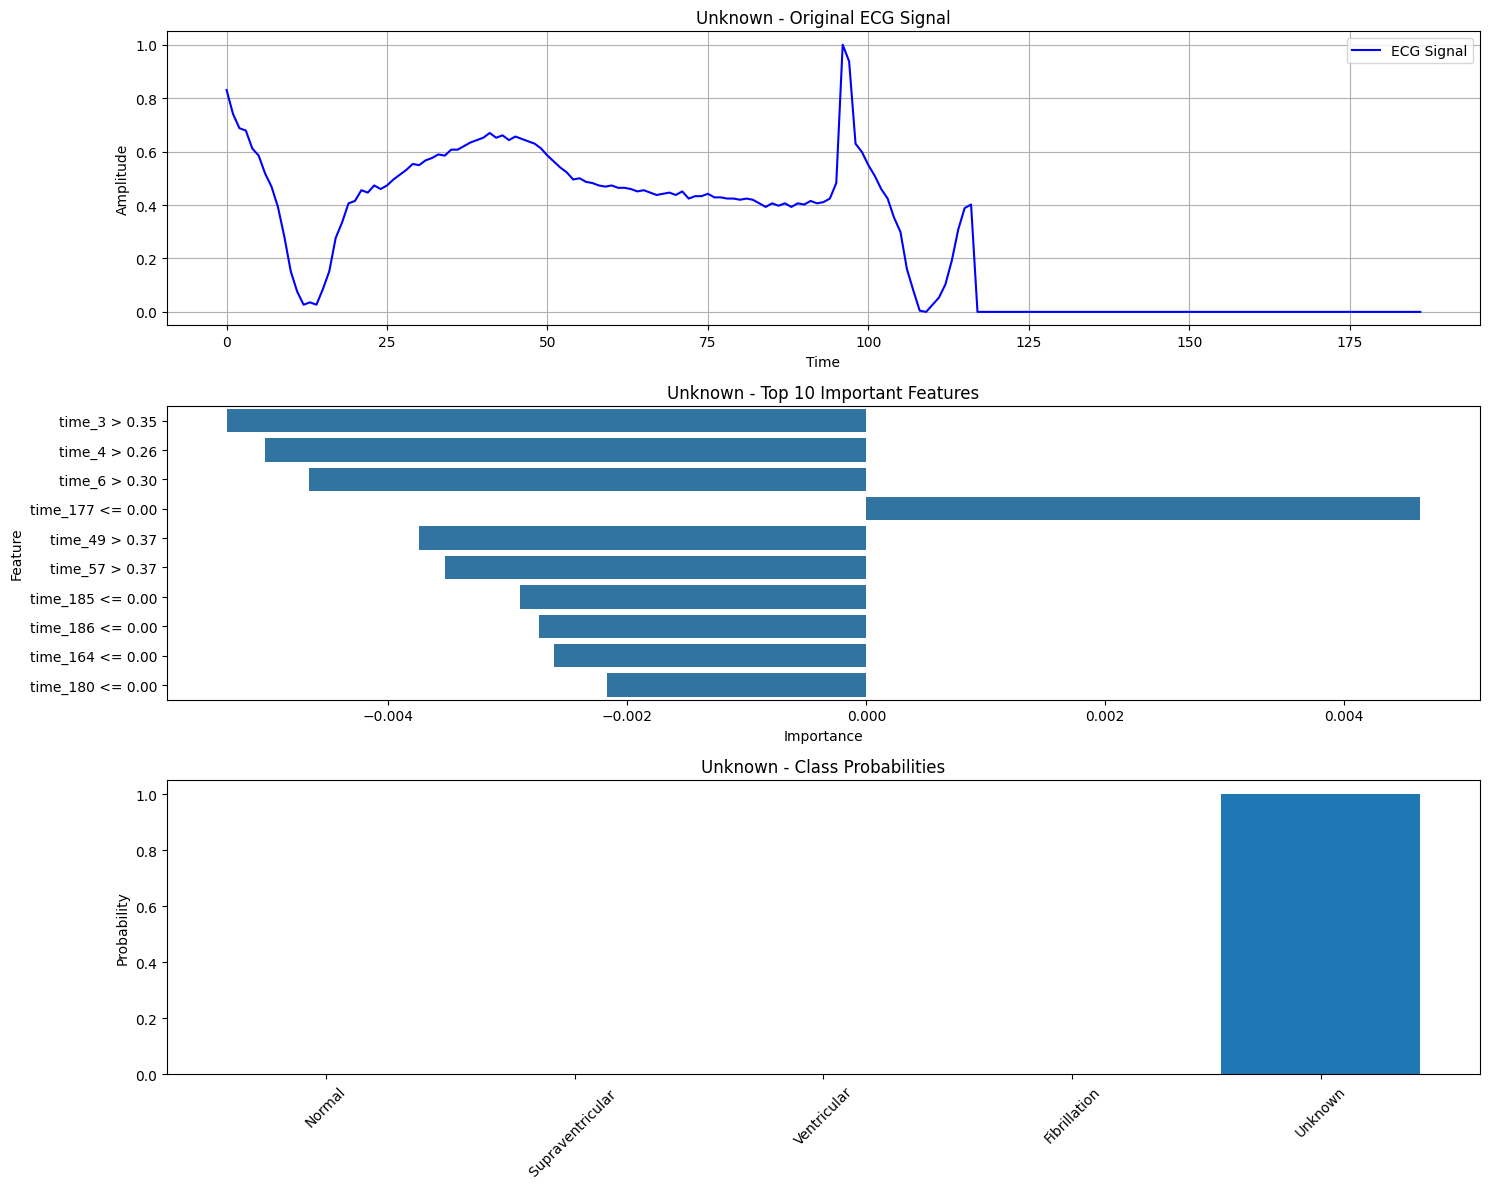

In [75]:
def run_class_analysis(model, data, labels, input_size):
    """Run analysis for one sample from each class"""
    try:
        display_samples_by_class(model, data, labels, input_size)
    except Exception as e:
        print(f"Error during analysis: {e}")

# Insert in RNN_model
run_class_analysis(gru_attention_model, X_test, y_test, 187)

# Analysis on CNN Model

In [77]:
# Load ECG GRU Attention Model
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Initialize model
input_size = 1  # Single channel ECG
hidden_size = 128
num_layers = 2
num_classes = 5  

# Create model instance
cnn_model = ECG_CNN().to(device)

# Create test loader if not already created
test_dataset = ECGDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=32)

# Load the saved model weights
try:
    checkpoint = torch.load('cnn_final_model.pth')
    cnn_model.load_state_dict(checkpoint['model_state_dict'])
    print("Model loaded successfully!")
except Exception as e:
    print(f"Error loading model: {e}")
    print("Make sure the model file 'ecg_model_final.pth' exists in the current directory")

Using device: cuda
Model loaded successfully!


In [78]:
cnn_model

ECG_CNN(
  (conv1): Sequential(
    (0): Conv1d(1, 32, kernel_size=(15,), stride=(1,), padding=(7,))
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout1d(p=0.2, inplace=False)
    (4): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res_block1): ImprovedResidualBlock(
    (conv_block): Sequential(
      (0): Conv1d(32, 64, kernel_size=(7,), stride=(1,), padding=(3,))
      (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Dropout1d(p=0.3, inplace=False)
      (4): Conv1d(64, 64, kernel_size=(7,), stride=(1,), padding=(3,))
      (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (skip_connection): Sequential(
      (0): Conv1d(32, 64, kernel_size=(1,), stride=(1,))
      (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (dropout): D

In [79]:
# Accessing the kernel weights
conv1_weights = cnn_model.conv1[0].weight.data
res_block1_weights = cnn_model.res_block1.conv_block[0].weight.data
res_block2_weights = cnn_model.res_block2.conv_block[0].weight.data
res_block3_weights = cnn_model.res_block3.conv_block[0].weight.data

# Print the weights
print("Weights of conv1:")
#print(conv1_weights)
print(conv1_weights.shape)

print("\nWeights of res_block1:")
#print(res_block1_weights)
print(res_block1_weights.shape)

print("\nWeights of res_block2:")
#print(res_block2_weights)
print(res_block2_weights.shape)

print("\nWeights of res_block3:")
#print(res_block3_weights)
print(res_block3_weights.shape)


Weights of conv1:
torch.Size([32, 1, 15])

Weights of res_block1:
torch.Size([64, 32, 7])

Weights of res_block2:
torch.Size([128, 64, 7])

Weights of res_block3:
torch.Size([256, 128, 7])


In [80]:
# Check if CUDA is available and set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

cnn_model.eval()

# Assume X_test and y_test are your test datasets
# Convert X_test to a PyTorch tensor if it isn't already
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

# Move the input tensor to the GPU
X_test_tensor = X_test_tensor.to(device)

# Get unique classes
unique_classes = np.unique(y_test)

# Randomly select one sample from each class
selected_samples = []
for cls in unique_classes:
    class_indices = np.where(y_test == cls)[0]
    random_index = np.random.choice(class_indices)
    selected_samples.append(X_test_tensor[random_index])

# Stack selected samples into a single tensor
selected_samples_tensor = torch.stack(selected_samples)

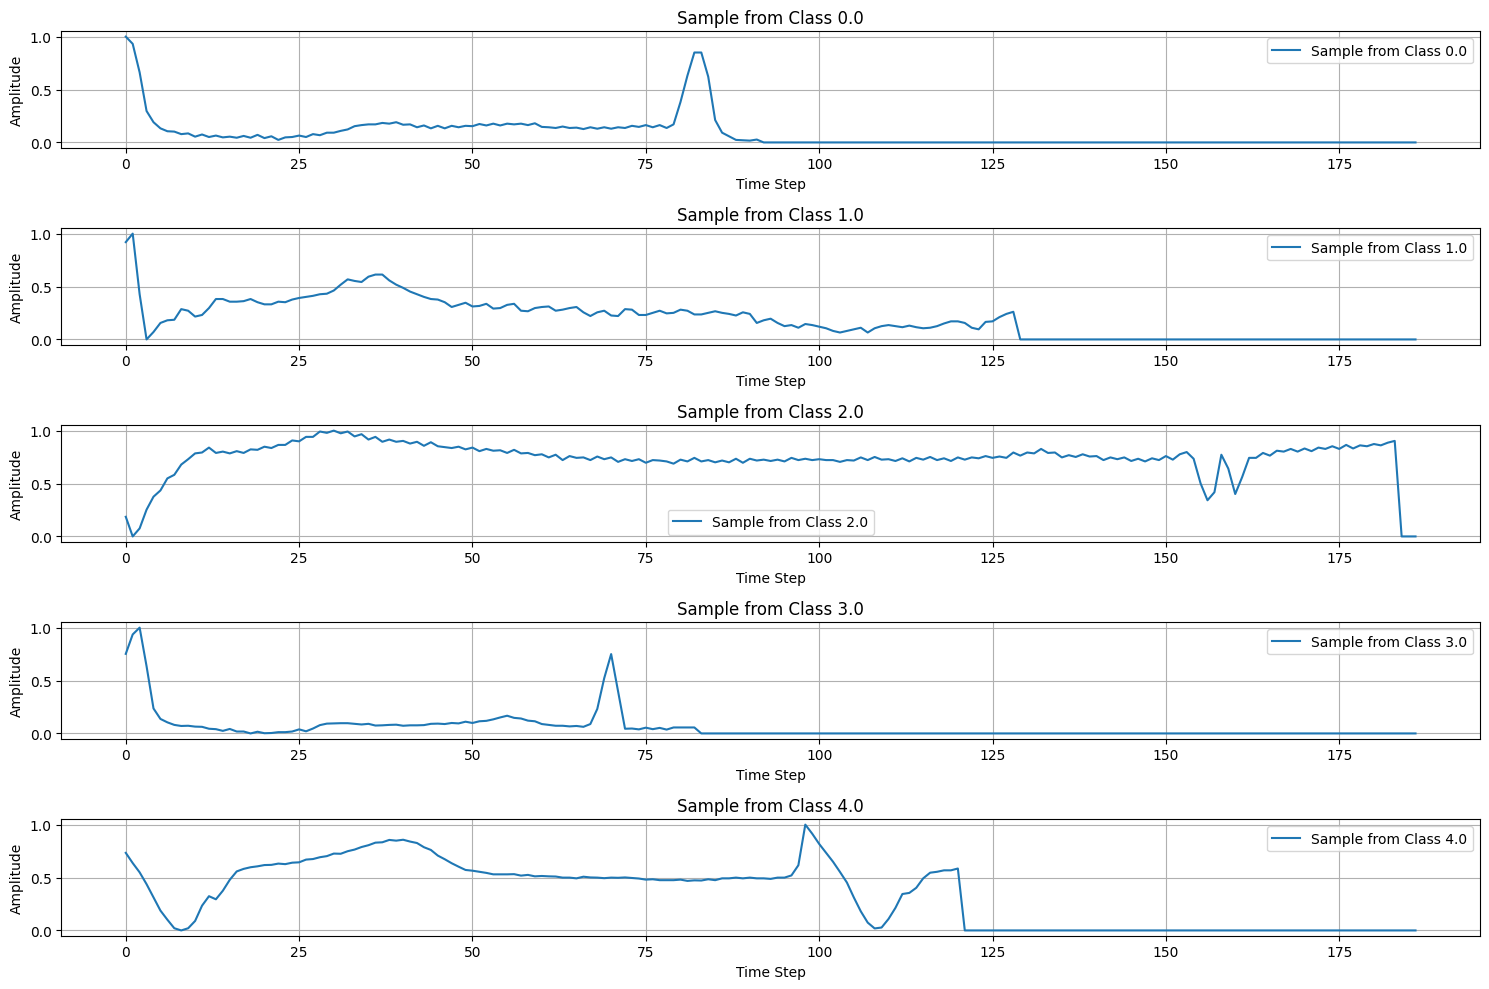

In [81]:
# Plot each selected sample as a line chart
plt.figure(figsize=(15, 10))
for i, sample in enumerate(selected_samples_tensor):
    plt.subplot(len(unique_classes), 1, i + 1)
    plt.plot(sample.cpu().numpy(), label=f'Sample from Class {unique_classes[i]}')
    plt.title(f'Sample from Class {unique_classes[i]}')
    plt.xlabel('Time Step')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.grid()

plt.tight_layout()
plt.show()

In [183]:
# Define a hook to capture the output of res_block3
feature_maps = []

def hook_fn(module, input, output):
    feature_maps.append(output)

cnn_model.to(device)

# Register the hook to res_block3
hook = cnn_model.res_block3.register_forward_hook(hook_fn)

# Forward pass through the model
with torch.no_grad():  # Disable gradient calculation
    cnn_model(selected_samples_tensor)  # Add channel dimension

# Remove the hook
hook.remove()

print("Feature maps after res_block3:")
print(feature_maps[0])  # feature_maps[0] contains the output from res_block3

Feature maps after res_block3:
tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.8740, 1.1843,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.4282, 0.0836, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [1.0762, 0.6534, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0

In [185]:
feature_maps[0].shape

torch.Size([5, 256, 93])

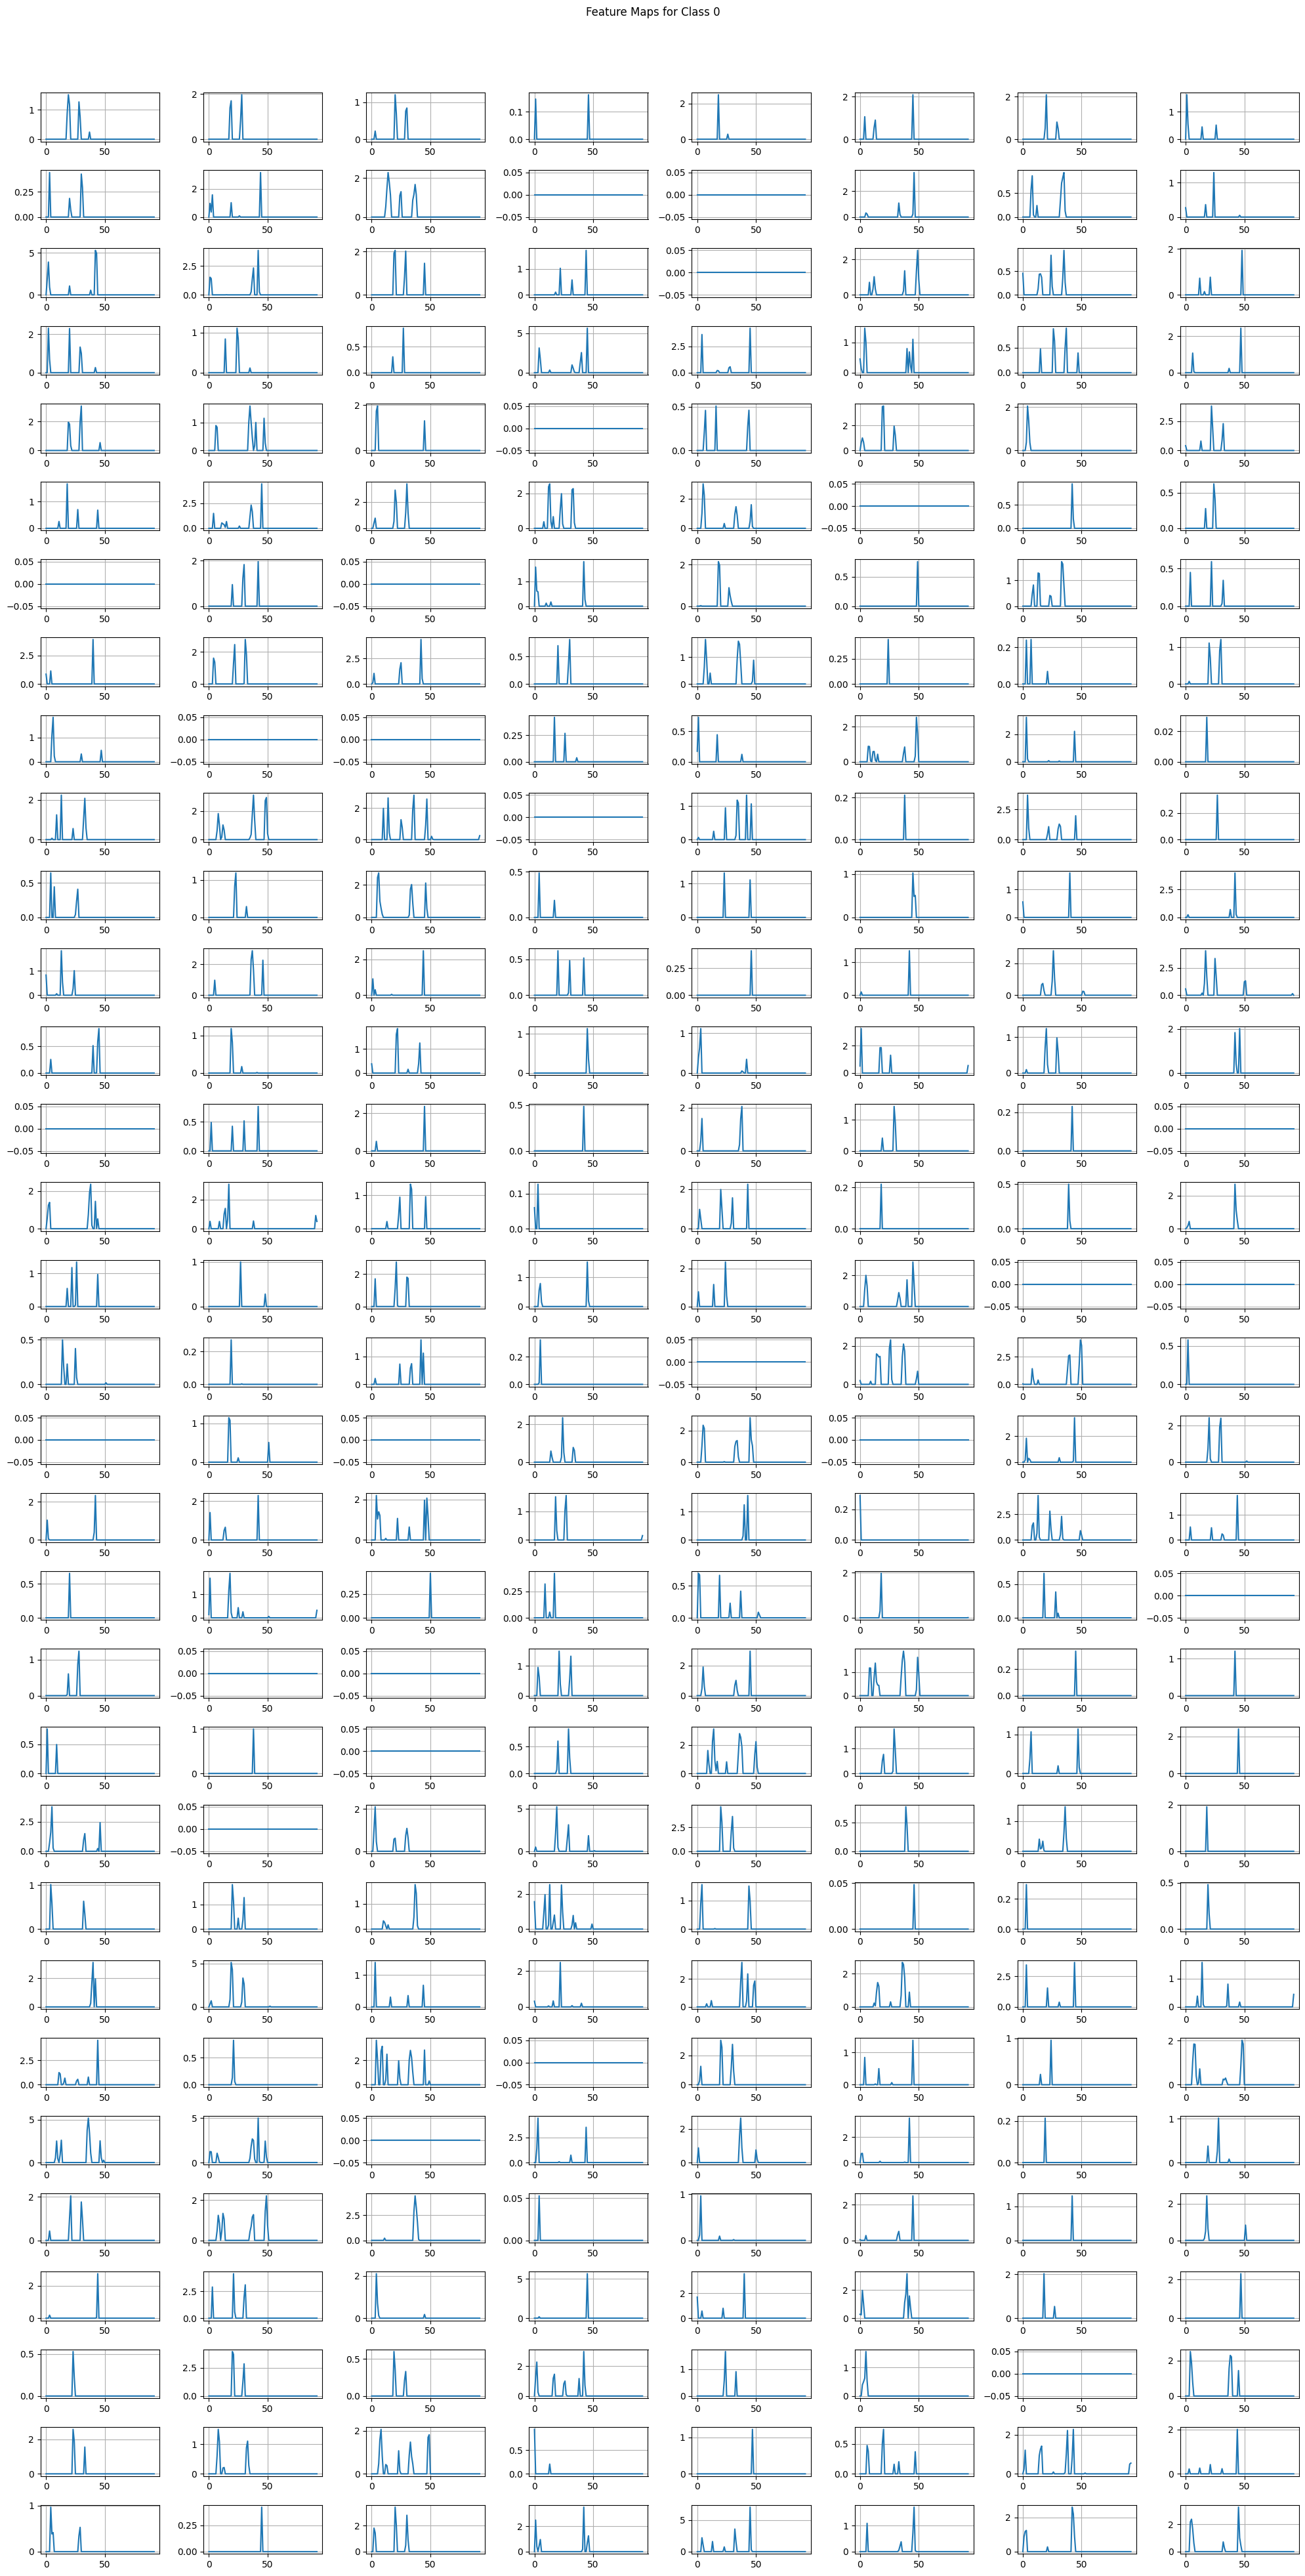

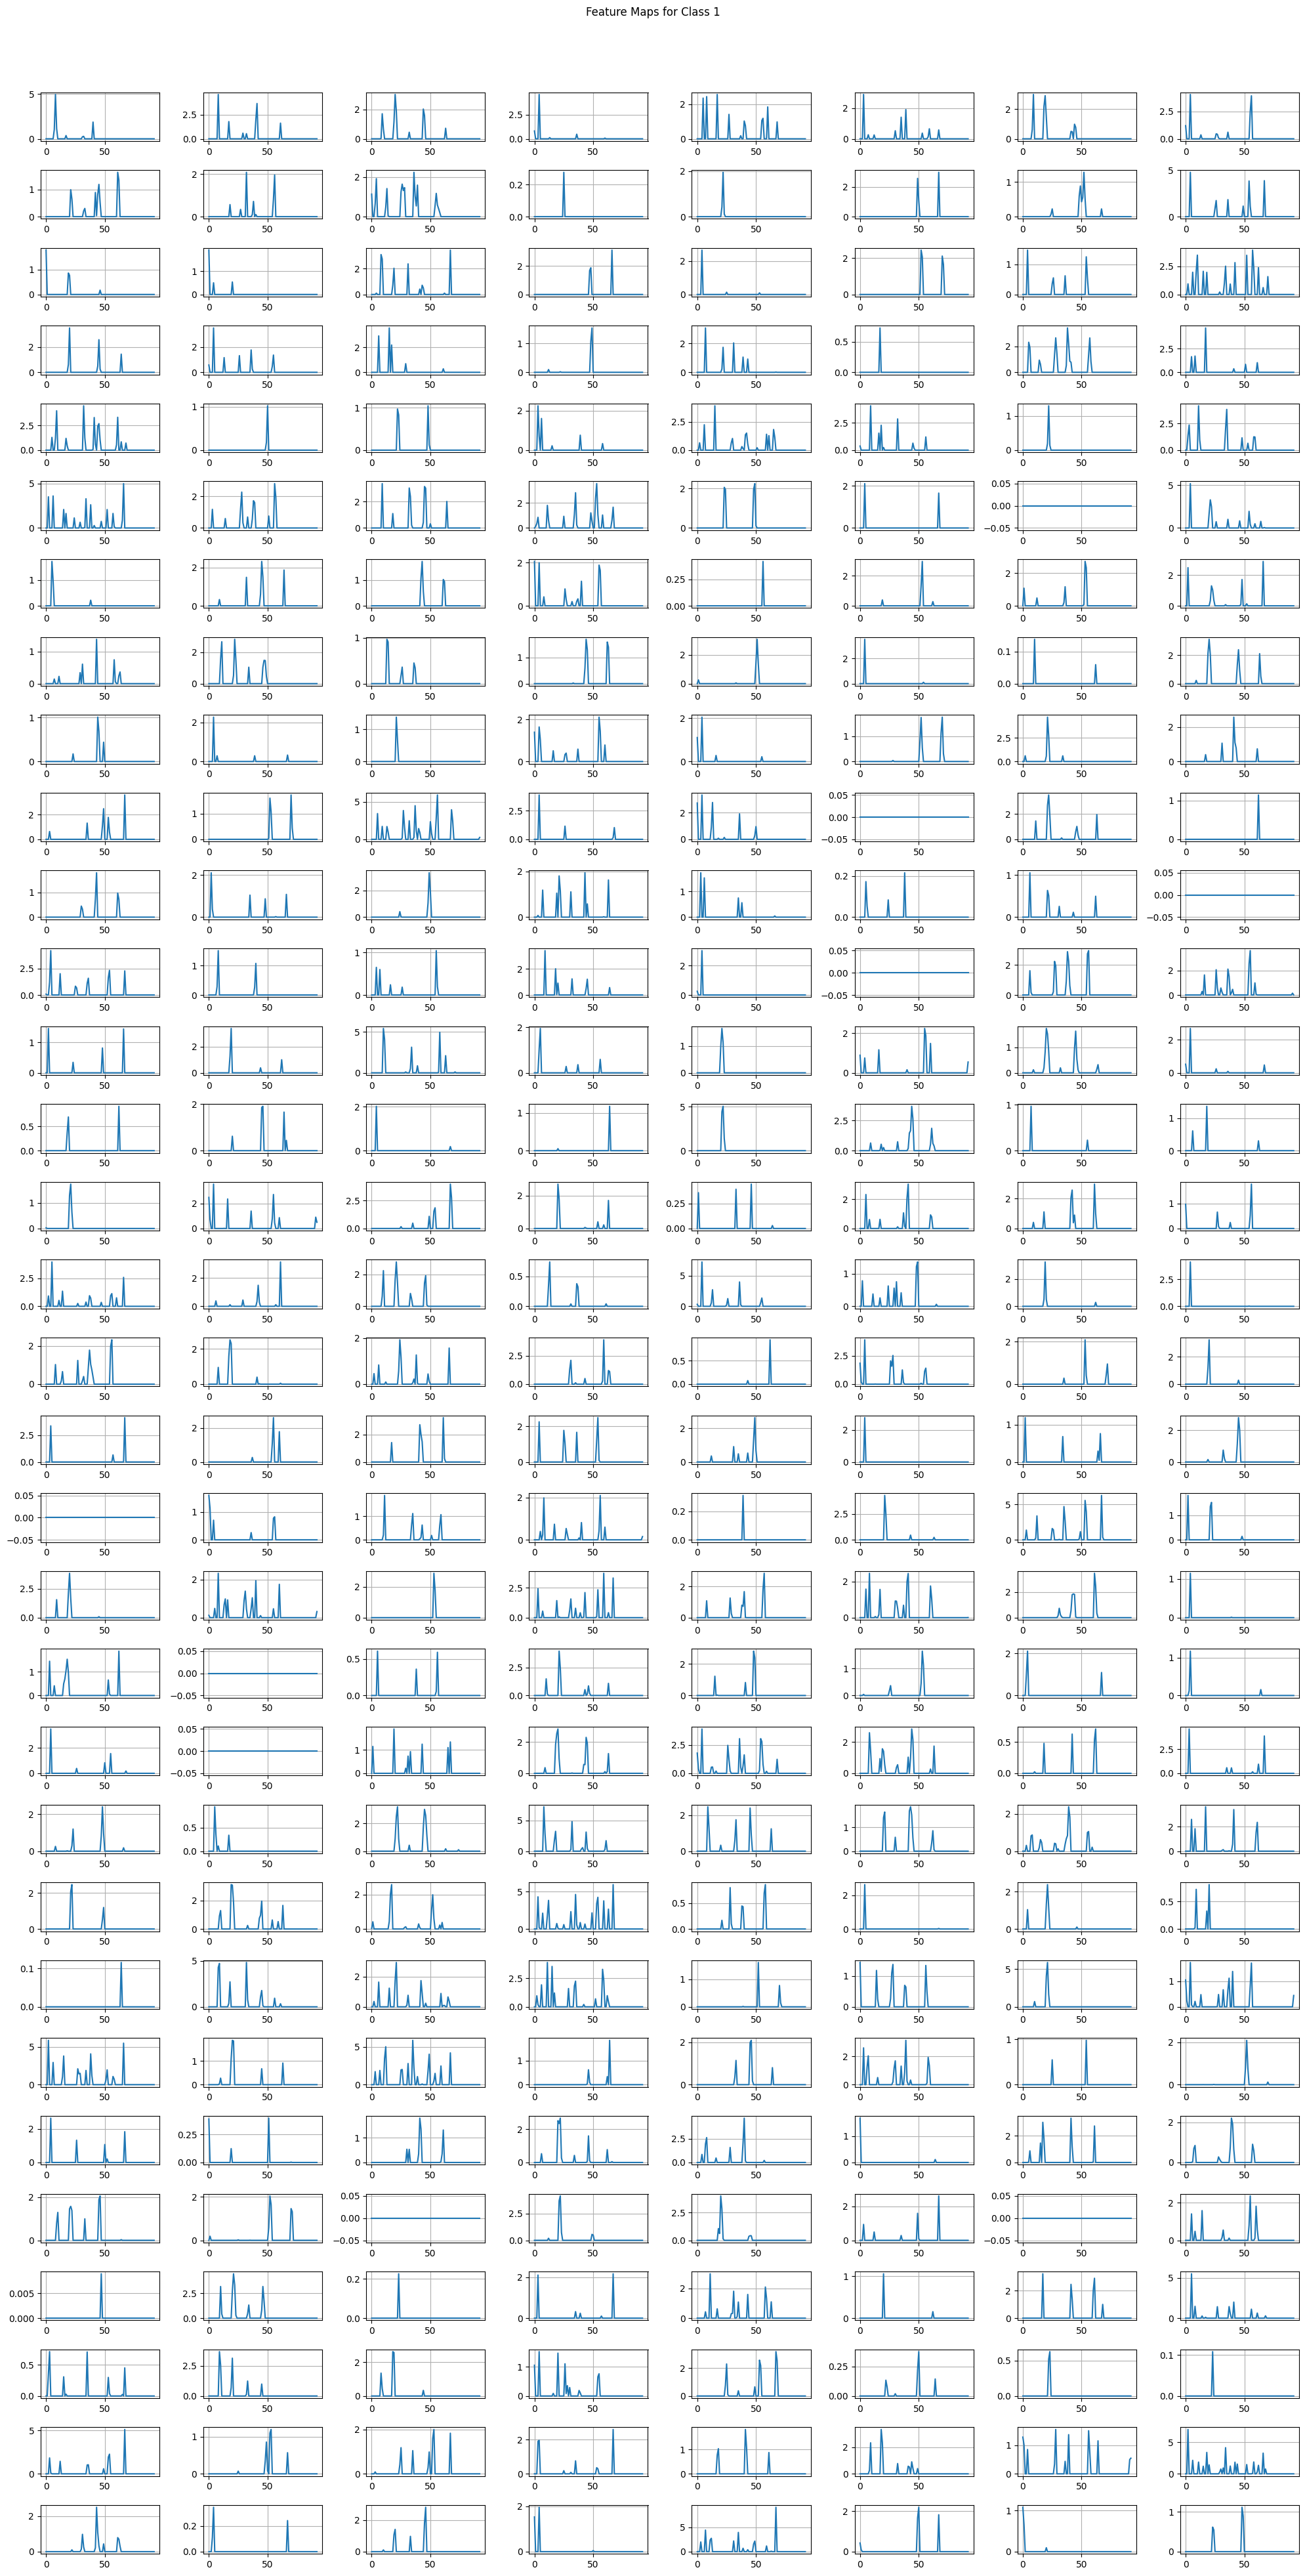

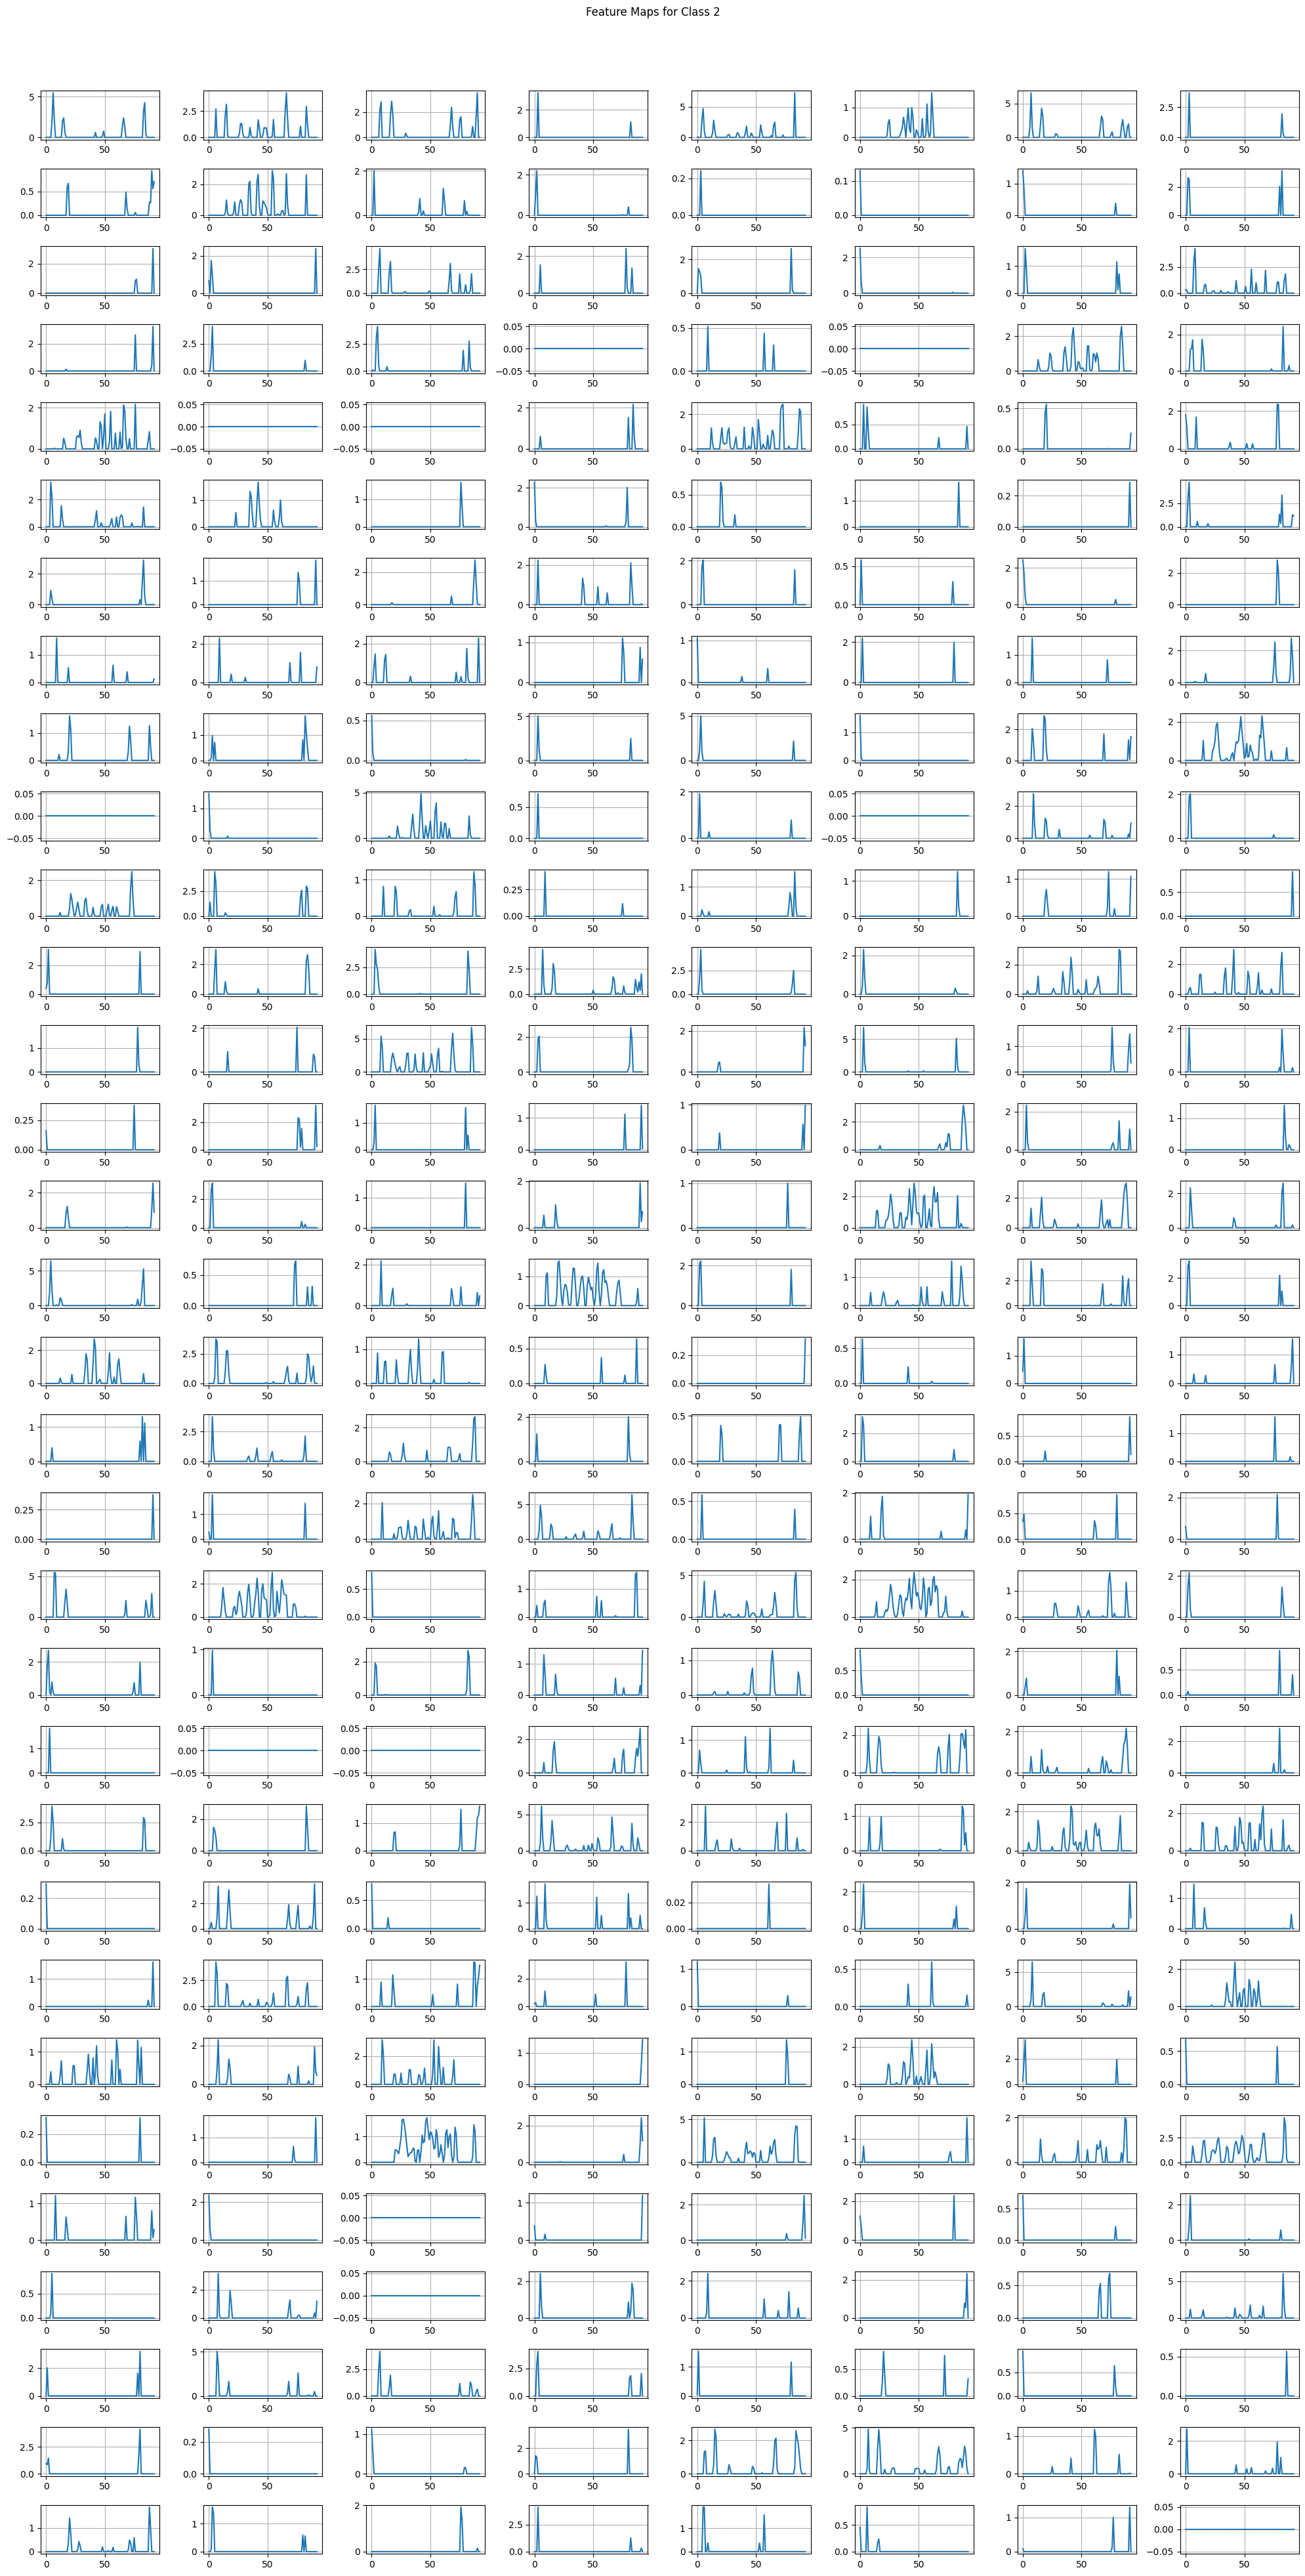

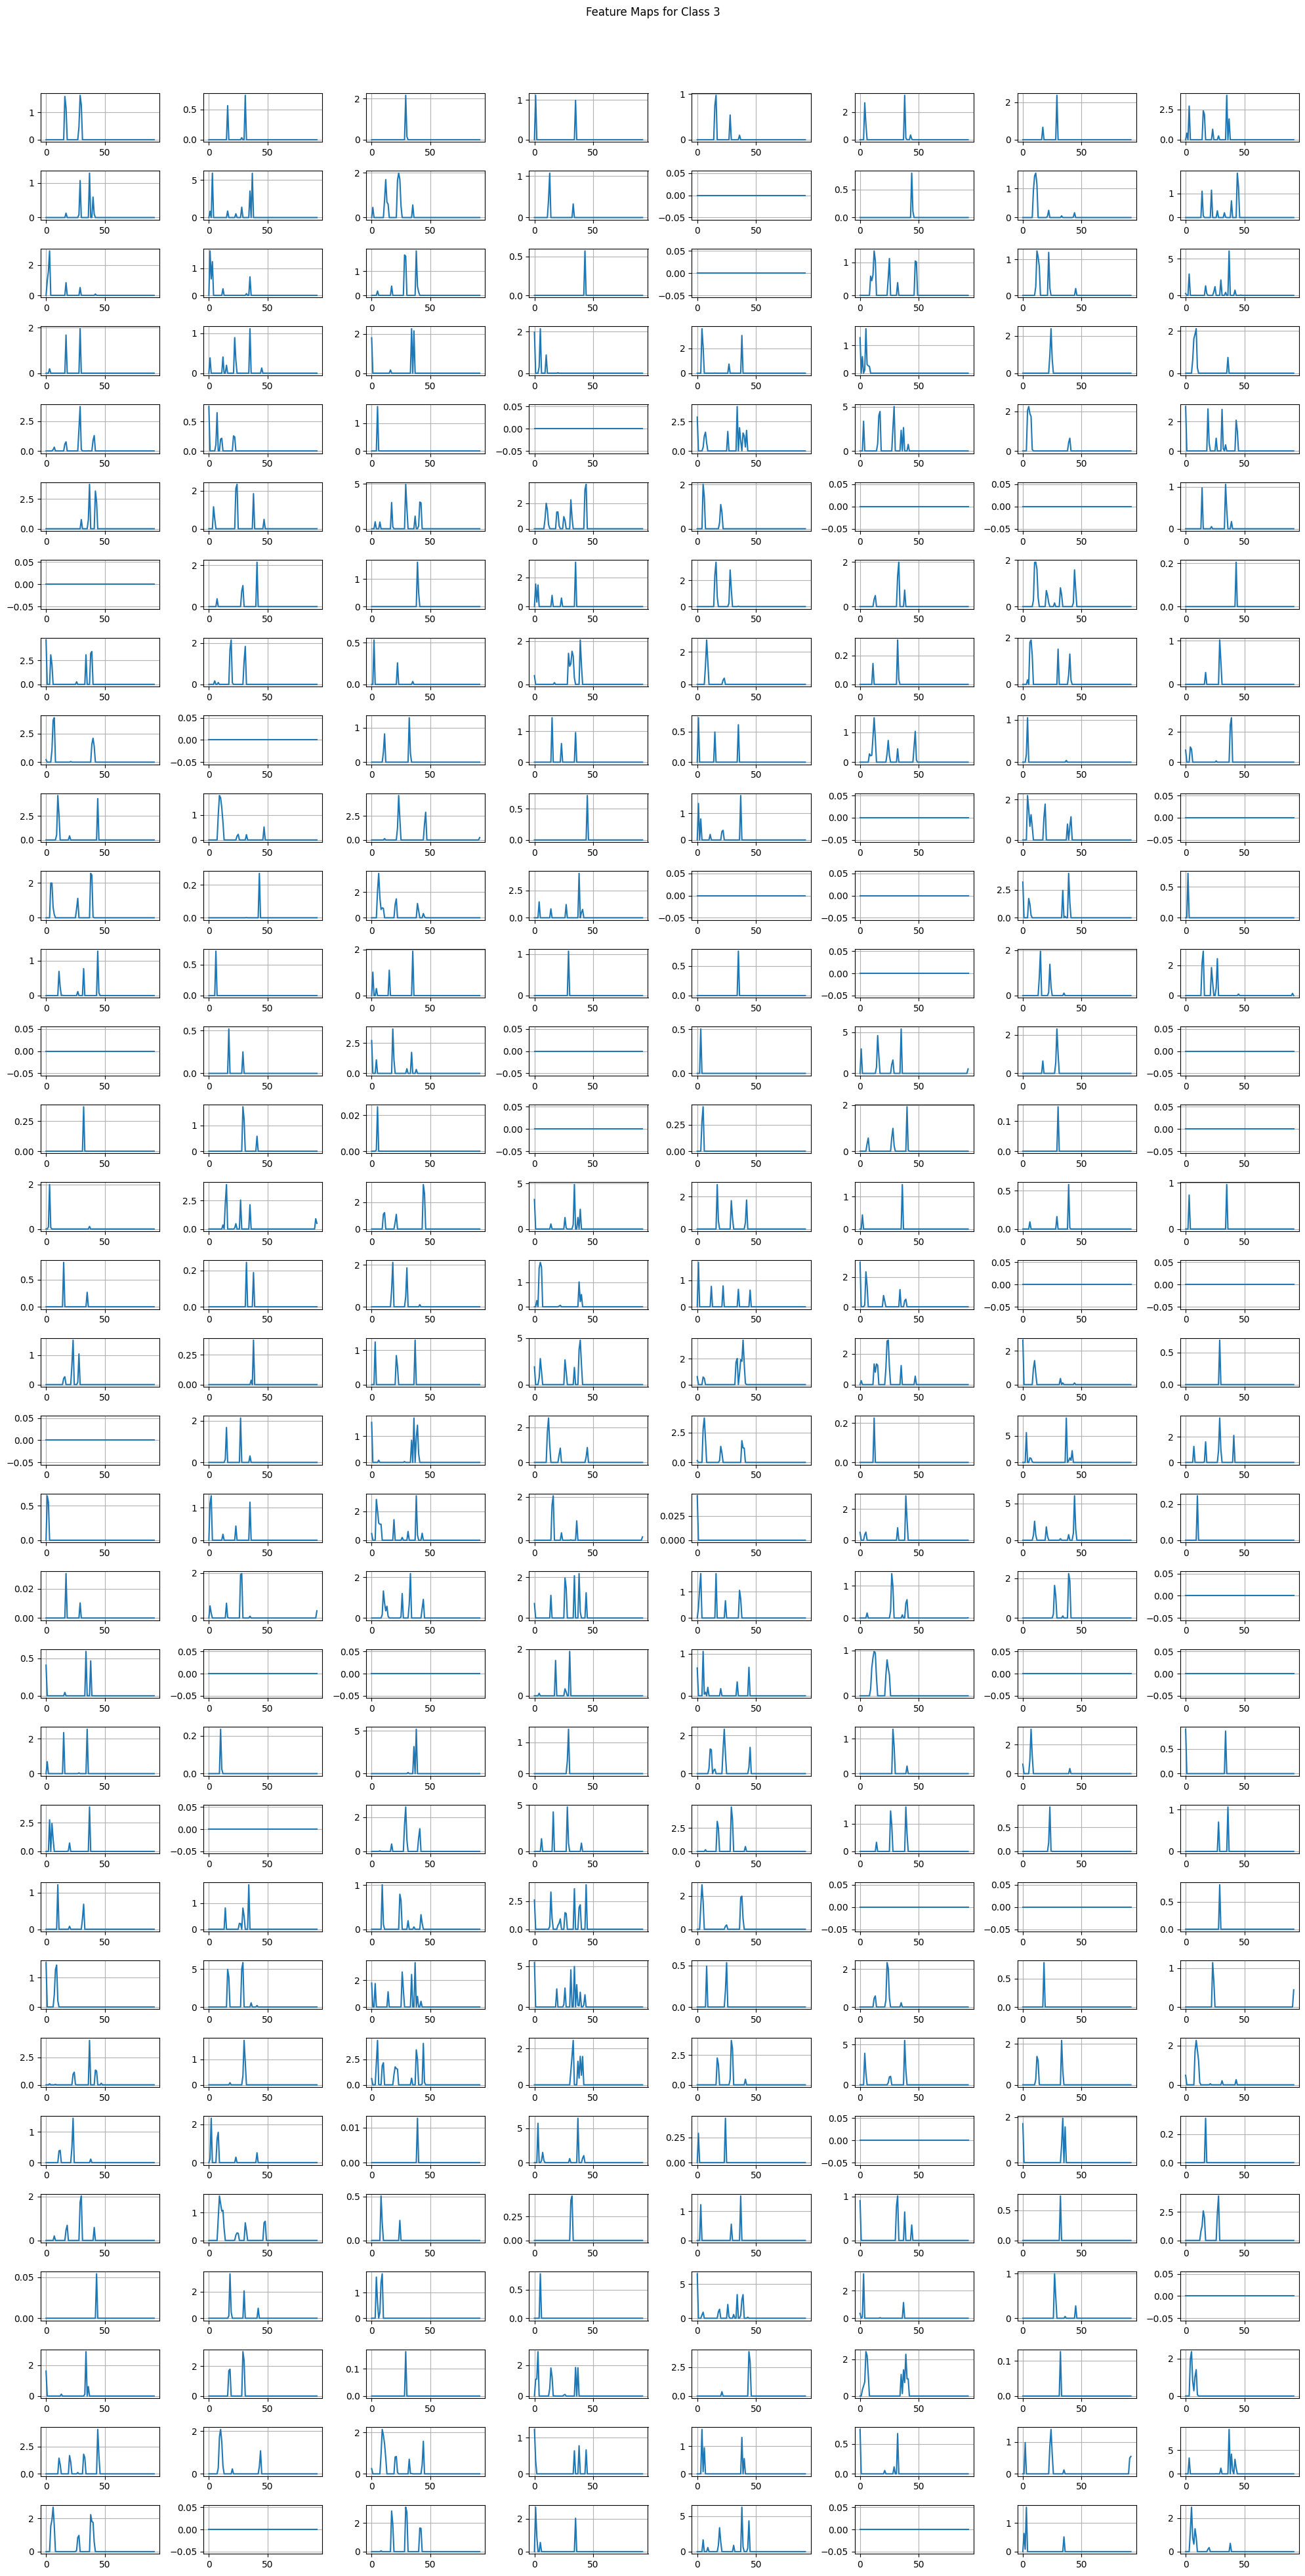

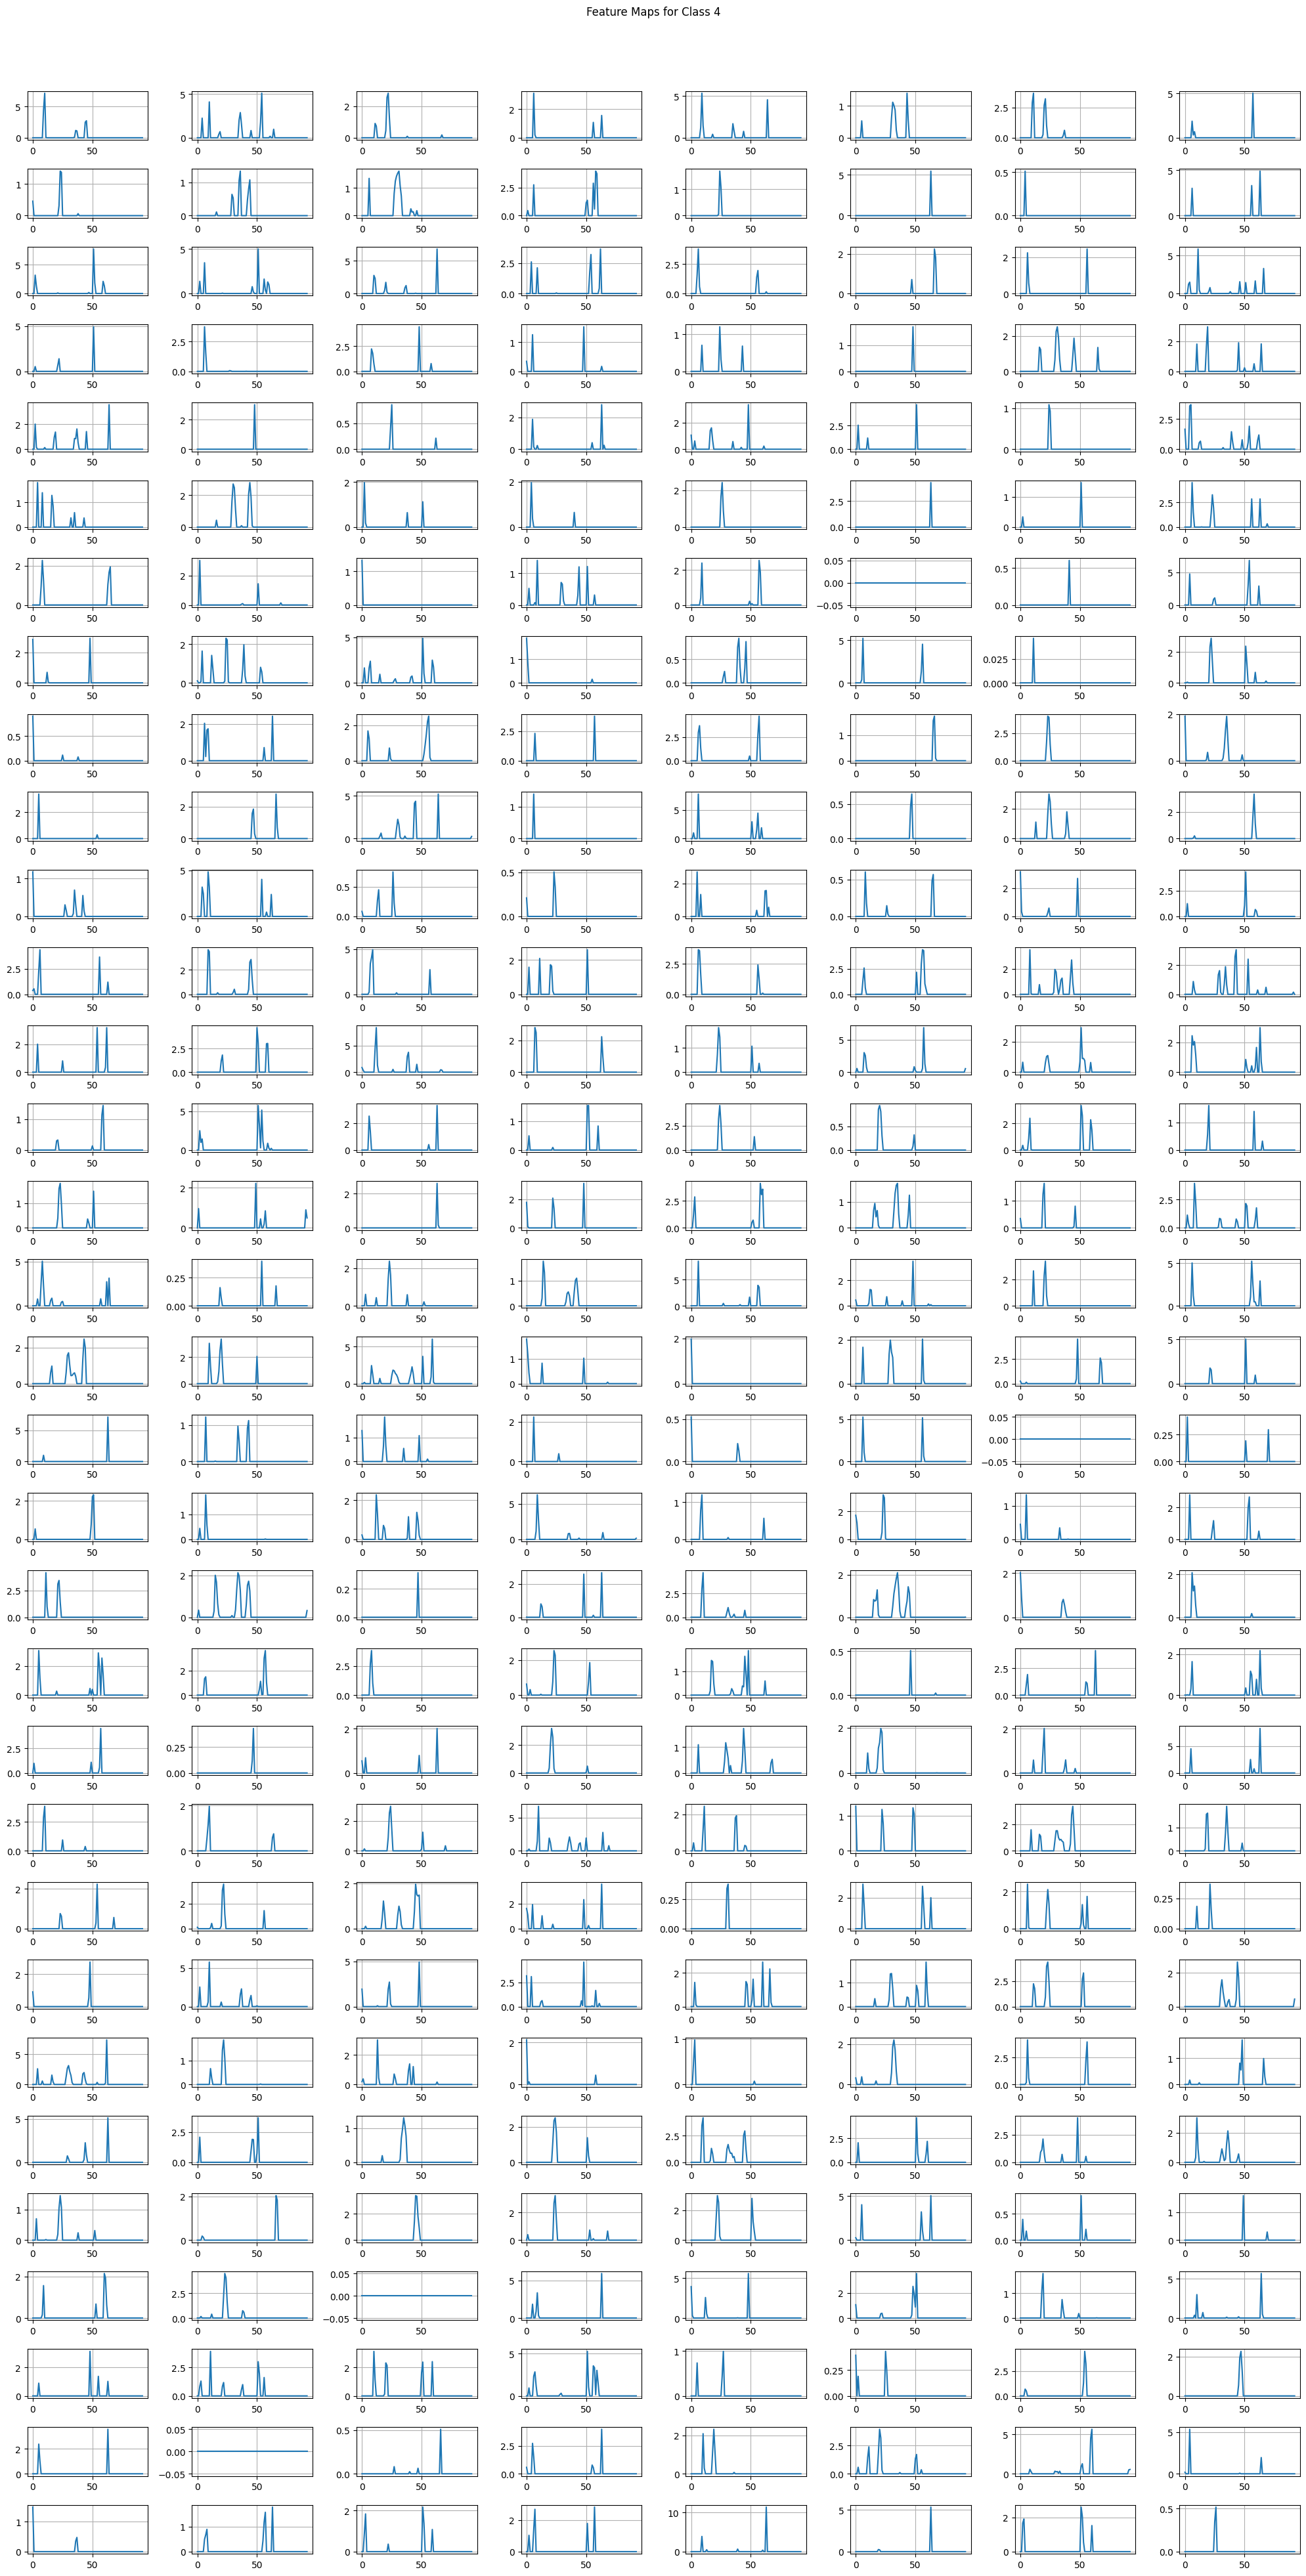

In [193]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import os

# Set the directory to save the images
save_dir = 'feature_maps'
os.makedirs(save_dir, exist_ok=True)

feature_map = feature_maps[0] 

# Number of classes and kernels
num_classes = feature_map.size(0)
num_kernels = feature_map.size(1)

# Create a figure for each class
for cls in range(num_classes):
    plt.figure(figsize=(20, 40))
    
    # Plot each kernel in a 10x10 grid
    for kernel in range(num_kernels):
        plt.subplot(32,8 , kernel + 1)
        plt.plot(feature_map[cls, kernel, :].cpu().numpy())  # Plot the kernel's feature map
        plt.grid()
    
    plt.suptitle(f'Feature Maps for Class {cls}', fontsize=12)
    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to make room for the title
    
    # Save the figure as a PNG file
    plt.savefig(os.path.join(save_dir, f'feature_maps_class_{cls}.png'))
    plt.show()